In [2]:
path_to_postprocessing_tools_1 = '/home/ron/research/ron_postptv_code'
path_to_postprocessing_tools_2 = '/home/ron/Desktop/Research/post_3D_PTV'
path_to_trajectories = '/home/ron/Oct2017_windtunnel_campaign/smoothed_connected_traj' #'/home/ron/Desktop/Research/iibr/Oct2017_wt_analysis/trajectories'

path_to_fluct_traj = '/home/ron/Oct2017_windtunnel_campaign/smoothed_connected_traj/Organized_By_subvolume/fluct'

import os
import sys
sys.path.append(path_to_postprocessing_tools_1)
sys.path.append(path_to_postprocessing_tools_2)

import numpy as np
np.set_printoptions(precision=3)

import time

import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib notebook
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

from load_traj_h5 import *
from traj_stats import *
from traj_plots import *
from traj_pairs import *
from my_utilities import *
from xv_retracking import Traj_Conector
from smooth_trajectories import smooth_traj_poly
from traj_stats import list_corelation
from traj_Sij import *
from fluct_traj import *

import pandas as pd
#exp_data = pd.read_csv(os.path.join(path_to_trajectories,'exp_data.csv'), index_col=0)

In [3]:
from matplotlib.ticker import FormatStrFormatter
import matplotlib
import matplotlib.pylab as pylab
from matplotlib.legend import Legend

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4.5),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large',
         'font.family': ['serif'],
         'font.sans-serif' : 'Computer Modern Roman',
         'grid.color': '#c1c1c1',
         'text.usetex' : 'true',
         'legend.framealpha' : '1.0',
         'lines.markersize': '7.0',
         'lines.markeredgewidth': '0.5'}
pylab.rcParams.update(params)

shapes = ['X','o', 'd', 'v', '^', '<', '>', 'P', '8', 's', 'p', '*', 'h', 'H', 'D']

In [4]:
# helper functions:

def calc_eps(r,f):
    c2 = 2.1
    X = sorted(f / c2 / r**(2.0/3.0))
    return np.mean(X[-4:])**(3.0/2.0)


def get_eps(subvol, U):
    S2 = np.load(os.path.join('../small_scales/S2_data', 'S2_%s_%.1f.npz'%(subvol, U)))
    return calc_eps(S2['r'], S2['S2'])


def get_S2(subvol, U):
    S2 = np.load(os.path.join('../small_scales/S2_data', 'S2_%s_%.1f.npz'%(subvol, U)))
    return S2['r'], S2['S2']


def get_Ustats(subvol, U):
    stats = np.load(os.path.join('../small_scales/U_stats', 'U_stats_%s_%.1f.npz'%(subvol, U)))
    return stats['U'], stats['u2'], stats['Urms']



from scipy.optimize import curve_fit
def get_TL(subvol, U, kind = 'none'):
    
    R_sawford = lambda t, T, te: ( np.exp(-t/T)  -  te/T * np.exp(-t/te) ) / (1.0 - te/T)
    p0 = [0.03, 0.01]

    urms = get_Ustats(subvol, U)[2]
    L = 0.03
    Tvol = L / urms
    
    R = np.load(os.path.join('../small_scales/RL_data', 'RL_%s_%.1f.npz'%(subvol, U)))
    if kind == 'none':
        Tl = 0
        for kind in ['x','y','z']:
            R_, N = R['R%s'%kind], R['N%s'%kind]
            tm =  np.arange(len(R_))/500.0
            fit_range = np.where(tm > Tvol/2.0)[0][0]
            stop = np.where(N<40000)[0][0]
            T1,T2 = curve_fit(R_sawford, tm[:stop], R_[:stop], p0 = p0)[0]
            Tl += (T1 + T2)/3.0
            
    else:
        R_, N = R['R%s'%kind], R['N%s'%kind]
        tm =  np.arange(len(R_))/500.0
        fit_range = np.where(tm > Tvol/2.0)[0][0]
        stop = np.where(N<40000)[0][0]
        T1,T2 = curve_fit(R_sawford, tm[:stop], R_[:stop], p0 = p0)[0]
        Tl = (T1 + T2)
    
    return Tl



subvolumes = []
for h in ['a','b','c','d']:
    for v in range(1,6):
        subvolumes.append(h+str(v))
        
FPS = 500.0
nu = 1.5e-5



def get_R(subvol,U, kind = 'U'):
    R = np.load(os.path.join('../small_scales/RL_data', 'RL_%s_%.1f.npz'%(subvol, U)))
    tm = np.arange(len(R['R'+kind]))/500.0
    return R['R'+kind], tm, R['N'+kind]


from scipy.optimize import curve_fit
R_sawford = lambda t, T, te: ( np.exp(-t/T)  -  te/T * np.exp(-t/te) ) / (1.0 - te/T)
p0 = [0.03, 0.01]


In [5]:

U = np.load('../velocity_analysis/3D_mean_velocity_field.npz')

x,y,z = U['x'], U['y'], U['z']
Vx,Vy,Vz = U['Vx'], U['Vy'], U['Vz']



def interp_field(p, x,y,z,Vx,Vy,Vz):
    
    ix1 = np.where( np.abs(x - p[0]) == sorted(np.abs(x - p[0]))[0])[0][0], sorted(np.abs(x - p[0]))[0]
    ix2 = np.where( np.abs(x - p[0]) == sorted(np.abs(x - p[0]))[1])[0][-1], sorted(np.abs(x - p[0]))[1]
    iy1 = np.where( np.abs(y - p[1]) == sorted(np.abs(y - p[1]))[0])[0][0], sorted(np.abs(y - p[1]))[0]
    iy2 = np.where( np.abs(y - p[1]) == sorted(np.abs(y - p[1]))[1])[0][-1], sorted(np.abs(y - p[1]))[1]
    iz1 = np.where( np.abs(z - p[2]) == sorted(np.abs(z - p[2]))[0])[0][0], sorted(np.abs(z - p[2]))[0]
    iz2 = np.where( np.abs(z - p[2]) == sorted(np.abs(z - p[2]))[1])[0][-1], sorted(np.abs(z - p[2]))[1]
    
    den_x, den_y, den_z = 0.0 , 0.0 , 0.0 
    mon = 0
    for i in [ix1,ix2]:
        for j in [iy1,iy2]:
            for k in [iz1,iz2]:
                den_x += Vx[i[0],j[0],k[0]] / (i[1]**2 + j[1]**2 + k[1]**2)**2.0
                den_y += Vy[i[0],j[0],k[0]] / (i[1]**2 + j[1]**2 + k[1]**2)**2.0
                den_z += Vz[i[0],j[0],k[0]] / (i[1]**2 + j[1]**2 + k[1]**2)**2.0
                mon += 1.0 / (i[1]**2 + j[1]**2 + k[1]**2)**2.0
    vx = den_x/mon
    vy = den_y/mon
    vz = den_z/mon
    return np.array([vx,vy,vz])

Flow = lambda p: interp_field(p, x,y,z,Vx,Vy,Vz)



def get_S(subvol, flow):
    '''
    returns an estimate of the mean shear rate at the 
    given the subvolume
    
    subvol - str label for the subvolume
    flow - a fucntion that rerturns the mean velocity at point
    '''
    a = -0.075/2, 0.0
    b = -0.075/2*3, 0.0
    c = -0.075/2, -0.5
    d = -0.075/2*3, -0.5

    Hori = [a,b,c,d]
    Vert = [0.06 + 0.02*i for i in range(5)]

    H_ind = ['a','b','c','d'].index(subvol[0])
    V_ind = int(subvol[1])-1
    
    dy = 0.01
    
    p1 = [ Hori[H_ind][0] , Vert[V_ind]+dy/2 , Hori[H_ind][1]]
    p2 = [ Hori[H_ind][0] , Vert[V_ind]-dy/2 , Hori[H_ind][1]]
    
    S = -1*(flow(p1)[0] - flow(p2)[0]) / dy
    return S

### The Markovian Model:

$$ d u_i = a_i(\vec{x}, \vec{u}, t) \, dt + b_{ij}(\vec{x}, \vec{u}, t) \, d\xi_{j}$$ 


$$ d x_i = u_i \, dt$$ 

The main question is what are $a$ and $b$. In the homogeneous isotropic case and at infinite Re, such that Kolmogorov scaling works, then - 

$$ b_{ij} = \delta_{ij} \, C_0 \epsilon \tau $$

In addition, if the velocity at each point is Normally distributed, then $a$ is a linear function of the velocity $u_i$ (Borgas and Sawford (1994)) -

$$ a_i = -\frac{u_i}{\tau} $$


The questions that rise are 
1. what are the effects of finite Re number?
2. what are the effects of intermittency (e.g. non Gaussian velocity distrivution)

<br>

### empirical estimate:

Taking the average and looking at the small time expantion, Thomson 1987 showed that:

(1) $\quad \overline{\left[u_i(\tau)-u_i(0) \right]} = a_i(\vec{x}(0),\vec{u}(0),\tau) \tau + \mathcal{O}(\tau^2)$

(2) $\quad \overline{[u_i(\tau)-u_i(0)] [u_j(\tau)-u_j(0)]} = 2 B_{ij}(\vec{x}(0),\vec{u}(0),\tau) \tau + \mathcal{O}(\tau^2)$

(3) $\quad \overline{[x_i(\tau)-x_i(0)]} = u(0) \, \tau + \frac{1}{2} a_i(\vec{x}(0),\vec{u}(0),\tau) \tau^2 + \mathcal{O}(\tau^3)$

(4) $\quad \overline{[x_i(\tau)- \overline{x_i(\tau)}] [x_j(\tau)- \overline{x_j(\tau)}]} = \frac{2}{3} B_{ij}(\vec{x}(0),\vec{u}(0),\tau) \tau^3 + \mathcal{O}(\tau^4)$

Here we shall condition particles on their velocity $u_i$ and make empirical estimates of the coefficients $a$ and $b$.

# Load Trajectories

the approach is to examine subvolumes as quazi-homogeneous process. i.e. particles at the same subvolumes are regarded as having the same $\vec{x}(0)$. In this respect the average velocity at $\vec{x}(0)$ is simply the average velocityat times $\tau=0$ -

$$ U [ \vec{x}(0) ] :=  \frac{1}{N} \sum_{i=0}^N v_i(0) $$

The turbulent fluctuations are then defined naively as - 

$$ v'[\vec{x}(0), \, \tau] = v[\vec{x}(0), \, \tau]  -  U[\vec{x}(0)]$$

In [5]:
subvol = 'b3'
U = 2.5

In [6]:
dirname = os.path.join('../small_scales','Trajectories',)

t = get_traj_list( os.path.join(dirname, '%s_%.1f.h5'%(subvol,U)) )
print len(t)

74156


In [6]:
V = np.zeros(3)
N = len(t)

for tr in t:
    V += tr.velocity()[0,:] / N
    
print 'V = '+str(V)

V = [-0.354  0.093 -0.056]


<IPython.core.display.Javascript object>


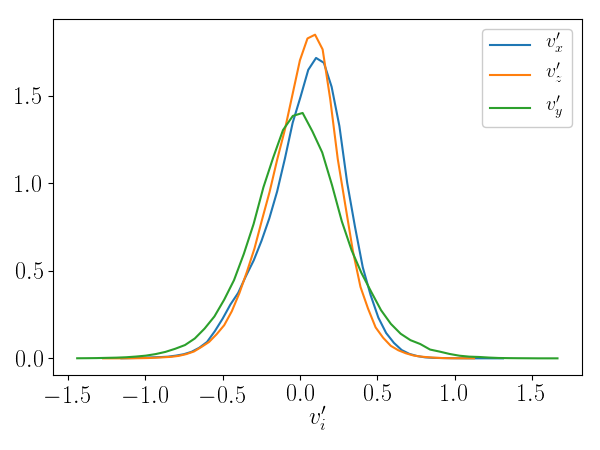

In [7]:
vx, vz, vy = [], [], []
v = [vx,vy,vz]

for tr in t:
    v_ = tr.velocity() - V
    for i in range(3):
        for j in range(len(tr)):
            v[i].append(v_[j,i])

sx, sy, sz = np.std(vx), np.std(vy), np.std(vz)
s = [sx, sz, sy]
            

fig, ax = plt.subplots()

lbls = [r"$v'_x$", r"$v'_z$", r"$v'_y$"]
for i in range(3):
    x,y = hist_lines(v[i], 50)
    ax.plot(x,y, label = lbls[i])

ax.set_xlabel(r"$v'_i$")
ax.legend()
plt.tight_layout()

In [33]:
#subvol,U = 'b3', 2.5
eps = get_eps(subvol,U)
nu = 1.5e-5
eta = (nu**3 / eps)**0.25
t_eta = (nu / eps)**0.5

In [11]:
#t_jhu = get_traj_list('/home/ron/research/jhu_for_pair_dispersion/JHU_Lagrangian_traj/data/jhu_traj_t4_n150.h5')
#t_jhu = get_traj_list('/home/ron/Desktop/Research/jhu_for_pair_dispersion/JHU_Lagrangian_traj/data/jhu_traj_t4_n150.h5')
#print len(t_jhu)
FPS_jhu = 37.5
t_eta_jhu = 0.045
eps_jhu = 0.092


#for tr in t_jhu:
#    calc_velocity(tr, FPS_jhu)
#    calc_accel(tr, FPS_jhu)

# Estimatioin of $a$ using relation (1)

in the chosen subvolue (i.e at the fixed $\vec{x}(0)$) -

$a_i(u_i(0),\tau) \approx a_i(v_i(0),\tau) = \frac{\overline{\left[v'_i(\tau) - v'_i(0) \right]}}{\tau} + \mathcal{O}(\tau)$


<IPython.core.display.Javascript object>


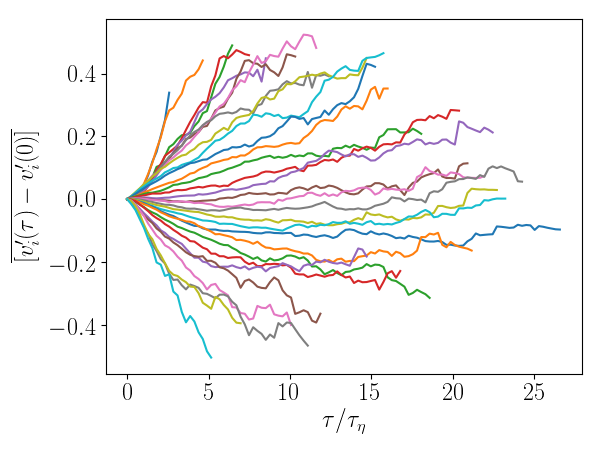

In [11]:
i = 0

v0_min, v0_max = -3*s[i], 3*s[i]
N_bins = 30

v_ensambles = [[] for j in range(N_bins)]

for tr in t:
    v_ = tr.velocity()[:,i] - V[i]
    
    if v_[0] < v0_min or v_[0] > v0_max:
        continue
    
    ind = int((v_[0] - v0_min) / (v0_max - v0_min) * N_bins)
    v_ensambles[ind].append(v_ - v_[0])
    

    
fig, ax = plt.subplots()
dv_lst = []
for v_lst in v_ensambles:
    dv, N_ = average_lists(v_lst, get_N=True)
    stop = np.where( np.array(N_) < 10)[0][0]
    tm = np.arange(stop)/FPS / t_eta
    
    ax.plot(tm, dv[:stop])
    
    dv_lst.append(dv[:stop])
    
ax.set_ylabel(r"$\overline{\left[v'_i(\tau) - v'_i(0) \right]}$")
ax.set_xlabel(r'$\tau / \tau_\eta$')
plt.tight_layout()

<IPython.core.display.Javascript object>


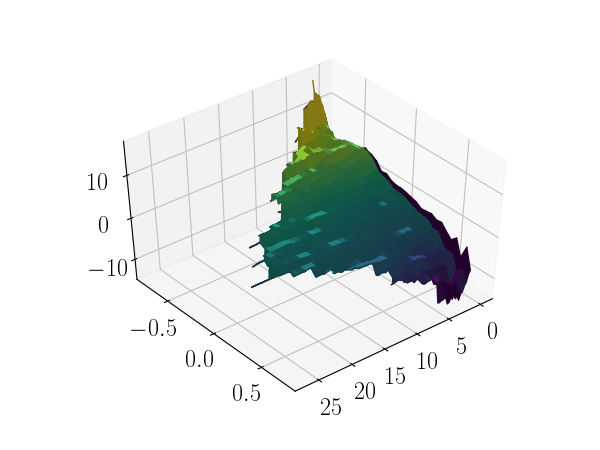

/home/ron/anaconda/lib/python2.7/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


In [12]:
N_t = len(max(dv_lst, key = len))

a = np.empty( (N_bins, N_t) )
a[:] = np.nan

for i,dv in enumerate(dv_lst):
    for j in range(1,len(dv)):
        a[i,j] = dv[j] / (j/FPS)
        
        

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

tm = np.arange(N_t) / 500.0
dvb = (v0_max - v0_min)/N_bins
v0 = np.array( [v0_min + (i+0.5)*dvb for i in range(N_bins)])
X, Y = np.meshgrid(tm / t_eta ,v0)


from matplotlib import cm
my_col = cm.viridis(a/20.0+0.5)

ax.plot_surface(X, Y, a, facecolors = my_col)

In [183]:
ax.set_zlabel(r"$a(v'(0), \tau)$")
ax.set_xlabel(r'$\tau / \tau_\eta$')
ax.set_ylabel(r"$v'(0)$")
plt.tight_layout()

<IPython.core.display.Javascript object>


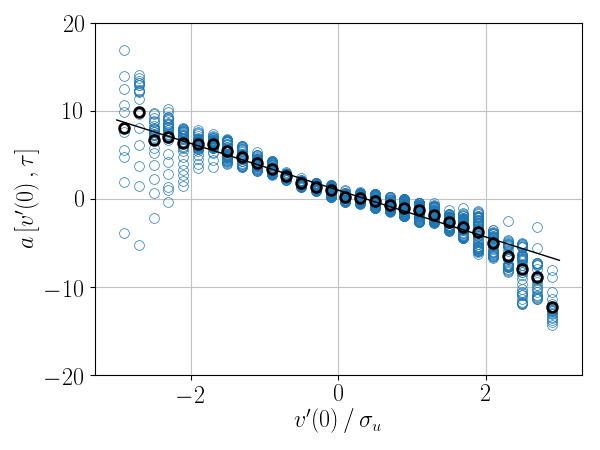

/home/ron/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in divide
  


In [200]:
fig, ax = plt.subplots()

e = 0
for i in range(len(dv_lst))[::1] :
    tm = np.arange(len(dv_lst[i])) / FPS
    a = dv_lst[i] / tm
    X = np.ones(len(a))*v0[i]
    ax.plot(X/sx, a, shapes[1], color = colors[0], fillstyle='none', mew=.5)
    ax.plot(X[:1]/sx, [np.mean(a[~np.isnan(a)])], shapes[1], color = 'k', fillstyle='none', mew=2)
    e+=1
    
x = np.linspace(-3, 3)
ax.plot(x, x*-10.5*sx + 1, 'k-', lw = 1)

ax.set_xlim([-3.3,3.3])
ax.set_ylim([-20,20])

ax.set_ylabel(r"$a \, [v'(0) \, , \tau]$")
ax.set_xlabel(r"$v'(0) \, / \, \sigma_u$")
ax.grid()
plt.tight_layout()

### Observations:

1. there is a clear dependence of $a$ on $v(0)$.
2. whether the dependence is linear is un clear.
3. there is a non zero intersept. does this imply a non zero mean acceleration?
4. at the ends of the distribution the deviations from linear dependence seems less likely.

# Estimatioin of $B$ using relation (2)

in the chosen subvolue (i.e at the fixed $\vec{x}(0)$) -

$ B_{ij}(\vec{x}(0),\vec{u}(0),\tau) \approx B_{ij}(v'_i(0),\tau) =  \frac{ \overline{[v'_i(\tau)-v'_i(0)] [v'_j(\tau)-v'_j(0)]} }{2 \tau} + \mathcal{O}(\tau)$

<IPython.core.display.Javascript object>


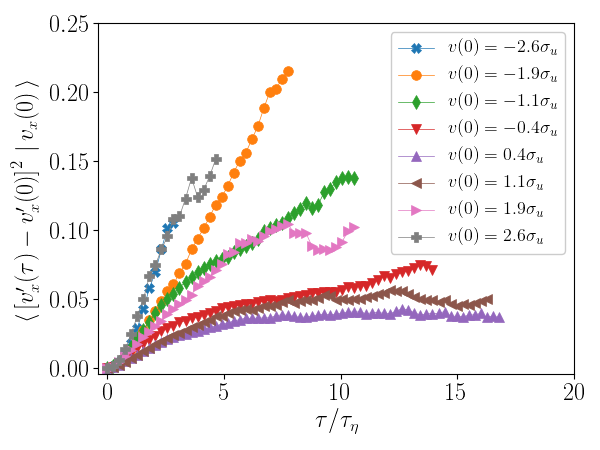

In [56]:
i = 0
FPS = 500.0
v0_min, v0_max = -3*s[i], 3*s[i]
N_bins = 8

v_ensambles = [[] for j in range(N_bins)]

for tr in t:
    v_ = tr.velocity()[:,i] - V[i]
    
    if v_[0] < v0_min or v_[0] > v0_max:
        continue
    
    ind = int((v_[0] - v0_min) / (v0_max - v0_min) * N_bins)
    v_ensambles[ind].append( (v_ - v_[0])*(v_ - v_[0]) )
    

dvb = (v0_max - v0_min) / N_bins

fig, ax = plt.subplots()
dv2_lst = []
e=0
for v_lst in v_ensambles:
    dv, N_ = average_lists(v_lst, get_N=True)
    stop = np.where( np.array(N_) < 150)[0][0]
    tm = np.arange(stop) / FPS / t_eta
    
    lbl = r'$v(0) = %.1f \sigma_u$'%(((e+0.5)*dvb + v0_min) / s[i])
    
    ax.plot(tm, dv[:stop], shapes[e]+'-',lw=.5, label = lbl)
    
    dv2_lst.append(dv[:stop])
    e+=1

ax.legend(ncol=1,fontsize = 13)
ax.set_xlim([-.4,20])
ax.set_ylim([-.004,.25])
ax.set_ylabel(r"$\langle \, \left[v'_x(\tau) - v'_x(0) \right]^2 \, | \, v_x(0) \, \rangle$")
ax.set_xlabel(r'$\tau / \tau_\eta$')
plt.tight_layout()
fig.savefig('B_v0_b3_25.pdf')

<IPython.core.display.Javascript object>


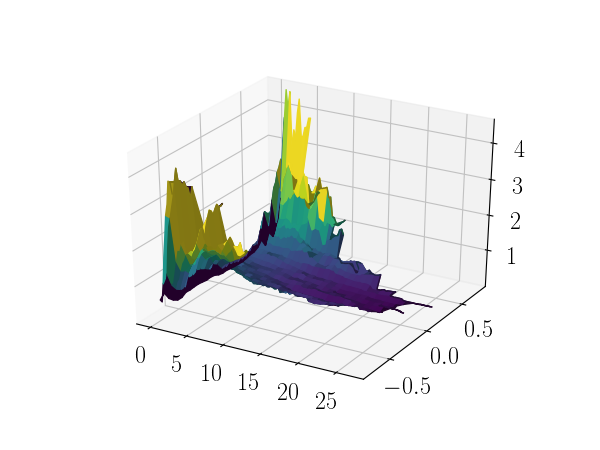

In [14]:
N_t = len(max(dv_lst, key = len))

B = np.empty( (N_bins, N_t) )
B[:] = np.nan

for i,dv2 in enumerate(dv2_lst):
    for j in range(1,len(dv2)):
        B[i,j] = dv2[j] / (j/FPS) / 2.0
        
        

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

tm = np.arange(N_t) / 500.0
dvb = (v0_max - v0_min)/N_bins
v0 = np.array( [v0_min + (i+0.5)*dvb for i in range(N_bins)])
X, Y = np.meshgrid(tm / t_eta ,v0)


from matplotlib import cm
my_col = cm.viridis(B/2.0)

ax.plot_surface(X, Y, B, facecolors = my_col)

<IPython.core.display.Javascript object>


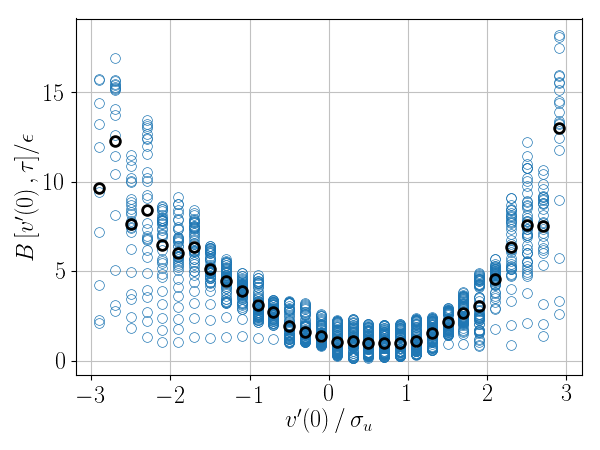

/home/ron/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in divide
  import sys


In [15]:
fig, ax = plt.subplots()

e = 0
for i in range(len(dv2_lst))[::1] :
    
    tm = np.arange(len(dv2_lst[i])) / FPS
    b = dv2_lst[i] / tm / 2.0 / eps
    
    X = np.ones(len(b))*v0[i]
    ax.plot(X/sx, b, shapes[1], color = colors[0], fillstyle='none', mew=.5)
    ax.plot(X[:1]/sx, [np.mean(b[~np.isnan(b)])], shapes[1], color = 'k', fillstyle='none', mew=2)
    e+=1
    
#x = np.linspace(-3, 3)
#ax.plot(x, np.ones(len(x))*2.1, 'k-', lw = 1)



ax.set_ylabel(r"$B \, [v'(0) \, , \tau] / \epsilon$")
ax.set_xlabel(r"$v'(0) \, / \, \sigma_u$")
ax.grid()
plt.tight_layout()

###### trajectories of $v'(\tau) - v'(0)$

<IPython.core.display.Javascript object>


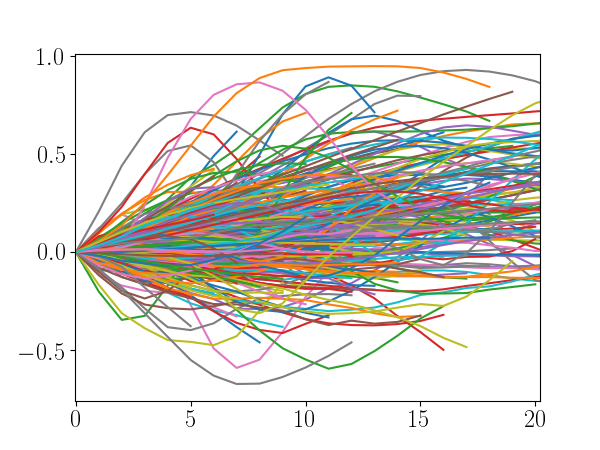

In [247]:
fig, ax = plt.subplots()

e = 0
for tr in t:
    v_ = tr.velocity()[:,0] - V[0]
    if len(tr)>5:
        if -0.45<v_[0]<-0.4:
            ax.plot( v_ - v_[0] )
            e+=1 
    if e>= 500:
        break
    

###### $B$ with no regard to the initial velocity:

<IPython.core.display.Javascript object>


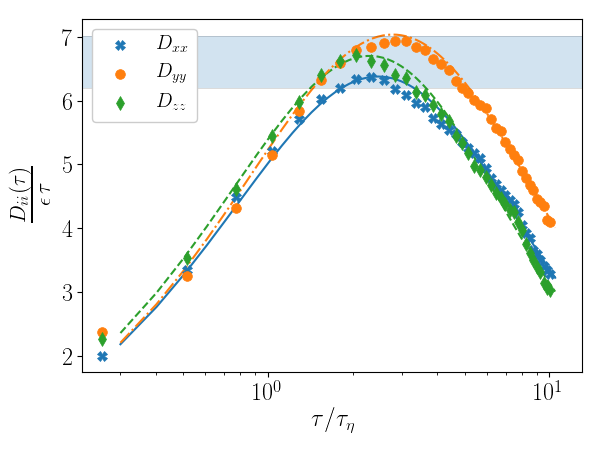

/home/ron/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in divide


In [25]:
fig, ax = plt.subplots()


# Sawford's second order model:
from scipy.optimize import curve_fit
R_sawford = lambda t, T, te: ( np.exp(-t/T)  -  te/T * np.exp(-t/te) ) / (1.0 - te/T)
D_sawford = lambda t, T, te, s: 2*s*(1 - R_sawford(t, T, te))



DL = np.load(os.path.join('DL_data','DL_b3_25.npz'))
tm = np.arange(DL['DL'].shape[0])/FPS




T = get_TL('b3', 2.5,kind='x')
eps = get_eps('b3',2.5)
nu = 1.5e-5
te = (nu / eps)**0.5
t_eta = te
s = get_Ustats('b3',2.5)[1][0]#**0.5

tm_model = np.linspace(0.3*t_eta, 1.3*T,num=100)


res, cov = curve_fit(D_sawford, tm[:40], DL['DL'][:40,0], p0=( T*0.8, te, s))
ax.semilogx(tm_model/ t_eta, D_sawford(tm_model, res[0], res[1]*.95, res[2])/tm_model/eps,
            '-', color=colors[0])

res, cov = curve_fit(D_sawford, tm[:40], DL['DL'][:40,1], p0=( T*0.5, te, s))
ax.semilogx(tm_model/ t_eta, D_sawford(tm_model, res[0], res[1]*.95, res[2])/tm_model/eps,
            '--', color=colors[2])

res, cov = curve_fit(D_sawford, tm[:40], DL['DL'][:40,2], p0=( T*0.5, te, s))
ax.semilogx(tm_model/ t_eta, D_sawford(tm_model, res[0], res[1]*.95, res[2])/tm_model/eps,
            '-.', color=colors[1])



eta = (nu**3 / eps)**0.5
t_eta = (nu / eps)**0.5




# shaded region:
y1 = 7.02; y2 = 6.2
ax.plot([0.01, 50], [y1, y1], 'k-', alpha = 0.2, lw=0.5)
ax.plot([0.01, 50], [y2, y2], 'k-', alpha = 0.2, lw=0.5)
ax.fill_between([0.01, 50], [y1, y1], y2=[y2, y2], alpha = 0.2)

# plot the D_ii
e=0
lbls = [r'$D_{xx}$', r'$D_{yy}$', r'$D_{zz}$']
for axes in [0,2,1]:
    B = DL['DL'][:,axes]
    stop = 40
    ax.semilogx(tm[:stop] / t_eta, B[:stop]/tm[:stop] / eps,
                shapes[e], lw = 0.5, label = lbls[e])
    e+=1


    
ax.legend(loc=2)
    
ax.set_xlim(0.22,13)
ax.set_ylabel(r"$ \frac{D_{ii}(\tau)}{\epsilon \, \tau}$", fontsize=22)
ax.set_xlabel(r"$ \tau / \tau_\eta $")

plt.tight_layout()
fig.savefig('DLL_b3_25.pdf')

In [6]:
DL = np.load(os.path.join('DL_data','DL_b3_25.npz'))
tm = np.arange(DL['DL'].shape[0])/FPS
Dx = DL['DL'][:,0]

res, cov = curve_fit(D_sawford, tm[:40], Dx[:40], p0=( T*0.8, te, s))

fig, ax = plt.subplots()
ax.plot(tm[:40], Dx[:40])
ax.plot(tm[:40], D_sawford(tm[:40],res[0], res[1], res[2]))

err = Dx[:40] - D_sawford(tm[:40],res[0], res[1], res[2])
print np.mean(err**2)**0.5 

NameError: name 'D_sawford' is not defined

<IPython.core.display.Javascript object>


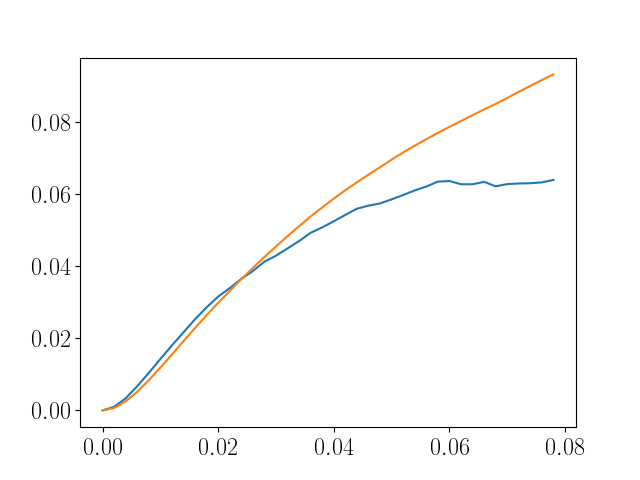

In [71]:
fig, ax = plt.subplots()

R = get_R('b3', 2.5, kind = 'x')

DL = np.load(os.path.join('DL_data','DL_b3_25.npz'))
Dx = DL['DL']


s = get_Ustats('b3',2.5)[1][0]#**0.5
ax.plot(R[1][:40], Dx[:40,0] )
ax.plot(R[1][:40], 2*s*(1-R[0][:40]))

In [76]:


axes = 0
dv2_lst = []
dv4_lst = []
dv6_lst = []

for tr in filter(lambda tr: len(tr)>2, t):
    v_ = tr.velocity()[:,axes] - V[axes]
    dv2_lst.append( (v_ - v_[0])**2 )
    dv4_lst.append( (v_ - v_[0])**4 )
    dv6_lst.append( (v_ - v_[0])**6 )
    
B2, N2 = average_lists(dv2_lst, get_N=True)
B4, N4 = average_lists(dv4_lst, get_N=True)
B6, N6 = average_lists(dv6_lst, get_N=True)

/home/ron/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/home/ron/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in divide
  


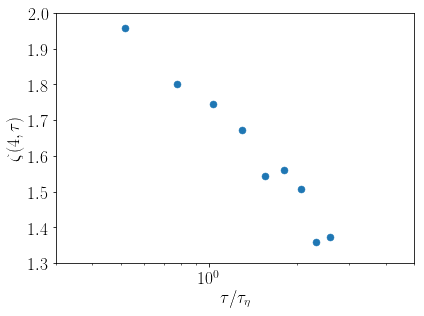

In [78]:
B2 = np.array(B2); B4 = np.array(B4); B6 = np.array(B6)

fig, ax = plt.subplots()

stop = 13
tm = np.arange(stop)/FPS

get_z = lambda x,tm: np.gradient( np.log(x))/ np.gradient( np.log(tm))

z2 = get_z(B2[:stop],tm[:stop]); z4 = get_z(B4[:stop],tm[:stop]); z6 = get_z(B6[:stop],tm[:stop])

#ax.loglog(tm[1:stop] / t_eta, z2[1:stop])
#ax.loglog(tm[1:stop] / t_eta, z4[1:stop])

ax.semilogx(tm[1:stop] / t_eta,  z4[1:stop] / z2[1:stop], 'o')
ax.set_xlim(0.3,5)
ax.set_ylim(1.3,2)
ax.set_xlabel(r'$\tau / \tau_\eta$')
ax.set_ylabel(r'$\zeta(4,\tau)$')
plt.tight_layout()

#ax.loglog(tm[1:stop] / t_eta, z6[1:stop])
#fig.savefig('z4.pdf')

# Try with the JHU dataset:

<IPython.core.display.Javascript object>


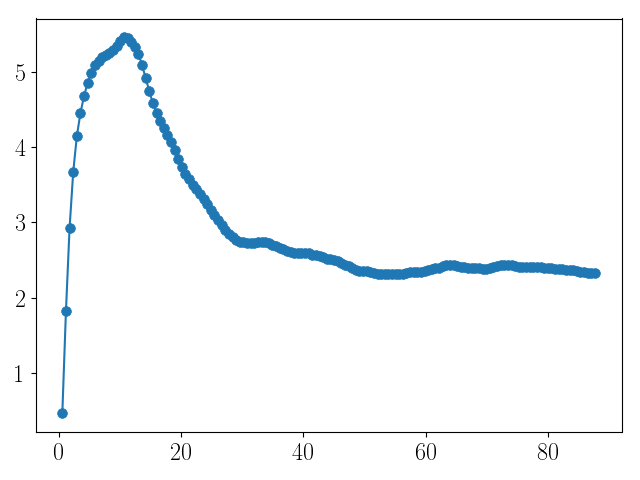

/home/ron/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


In [77]:
axes = 0
dv2_lst = []

for tr in t_jhu:
    v_ = tr.velocity()[:,axes] * FPS
    dv2_lst.append( (v_ - v_[0]) * (v_ - v_[0]) )

B, N = average_lists(dv2_lst, get_N=True)

stop = 149
tm = np.arange(stop)/FPS

eps, t_eta = 0.092, 0.045

fig, ax = plt.subplots()
ax.plot(tm / t_eta, B[:stop]/tm / eps, 'o-')

#ax.set_ylabel(r" \langle [v'_i(\tau)-v'_i(0)]^2} \rangle \, \, \cdot \, \, (\epsilon \, \tau)^{-1}")
#ax.set_xlabel(r" \tau / \tau_\eta ")

plt.tight_layout()

<IPython.core.display.Javascript object>


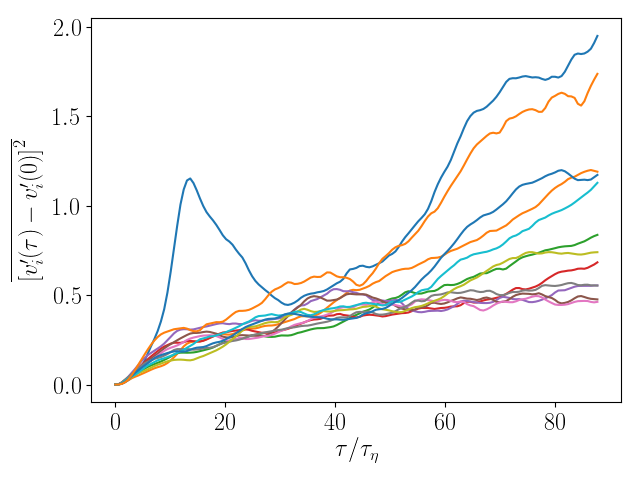

In [99]:
s = 0.75

v0_min, v0_max = -2*s, 2*s
N_bins = 12

v_ensambles = [[] for j in range(N_bins)]

for tr in t_jhu:
    v_ = tr.velocity()[:,0] * FPS
    
    if v_[0] < v0_min or v_[0] > v0_max:
        continue
    
    ind = int((v_[0] - v0_min) / (v0_max - v0_min) * N_bins)
    v_ensambles[ind].append( (v_ - v_[0])*(v_ - v_[0]) )
    

    
fig, ax = plt.subplots()
dv2_lst = []
for v_lst in v_ensambles:
    dv, N_ = average_lists(v_lst, get_N=True)
    stop = 149
    tm = np.arange(stop)/FPS
    
    ax.plot(tm / t_eta, dv[:stop])
    
    dv2_lst.append(dv[:stop])
    
ax.set_ylabel(r"$\overline{\left[v'_i(\tau) - v'_i(0) \right]^2}$")
ax.set_xlabel(r'$\tau / \tau_\eta$')
plt.tight_layout()

<IPython.core.display.Javascript object>


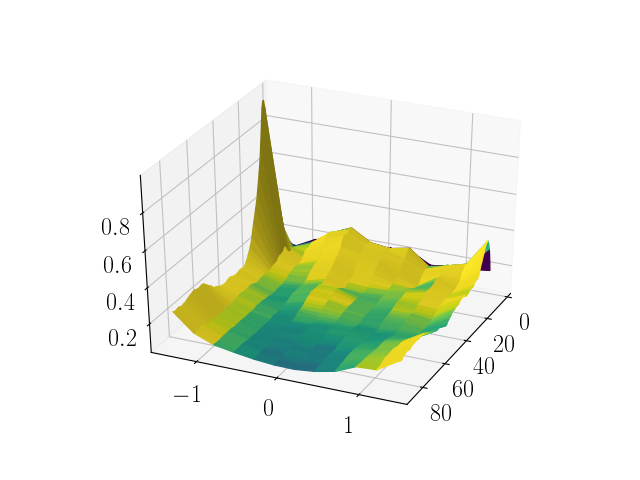

In [100]:
N_t = len(max(dv2_lst, key = len))

B = np.empty( (N_bins, N_t) )
B[:] = np.nan

for i,dv2 in enumerate(dv2_lst):
    for j in range(1,len(dv2)):
        B[i,j] = dv2[j] / (j/FPS) / 2.0
        
        

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

tm = np.arange(N_t)/FPS 
dvb = (v0_max - v0_min)/N_bins
v0 = np.array( [v0_min + (i+0.5)*dvb for i in range(N_bins)])
X, Y = np.meshgrid(tm / t_eta ,v0)


from matplotlib import cm
my_col = cm.viridis(B/0.15)

ax.plot_surface(X[:,5:], Y[:,5:], B[:,5:], facecolors = my_col)

<IPython.core.display.Javascript object>


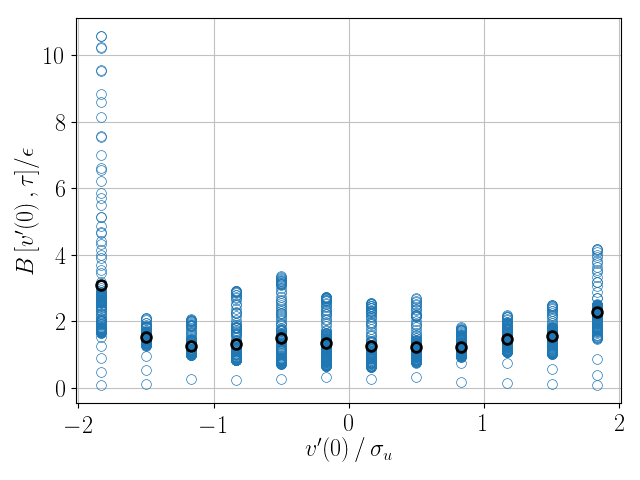

/home/ron/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in divide
  import sys


In [101]:
fig, ax = plt.subplots()

e = 0
for i in range(len(dv2_lst))[::1] :
    
    tm = np.arange(len(dv2_lst[i]))/FPS
    b = dv2_lst[i] / tm / 2.0 
    
    X = np.ones(len(b))*v0[i]
    ax.plot(X/s, b/eps, shapes[1], color = colors[0], fillstyle='none', mew=.5)
    ax.plot(X[:1]/s, [np.mean(b[~np.isnan(b)])/eps], shapes[1], color = 'k', fillstyle='none', mew=2)
    e+=1
    
#x = np.linspace(-3, 3)
#ax.plot(x, np.ones(len(x))*2.1, 'k-', lw = 1)



ax.set_ylabel(r"$B \, [v'(0) \, , \tau] / \epsilon$")
ax.set_xlabel(r"$v'(0) \, / \, \sigma_u$")
ax.grid()
plt.tight_layout()

# Try out the Sawford 1991 LSM:


$$ T_L \, da + A_1 \, a(t) \, dt +  A_2(t) \,\, dt =  A_3 \, d\xi$$

$$ A_1 = ( 1 + Re^{* \, 1/2}) $$

$$ A_2(t) = \frac{Re^{* \, 1/2}}{T_L} \int_0^t a(\tau)  d\tau $$

$$ A_3 = \sqrt{\frac{2 \sigma}{T_L} Re^{* \, 1/2} \left( 1 + Re^{* \, -1/2} \right)} $$

$$ Re^{*} = \frac{16 a_0^2}{C_0^4} \left(\frac{T_e}{\tau_\eta}\right)^2 $$


In [16]:
class particle(object):
    
    """
    a stochastic flight model that will integrate particle trajectories
    see above the full formula. 
    TL - integral time scale
    tk - dissipation timescale
    Re - the Reynolds number
    S - the std of the velocity
    dt - integration time step
    """
    
    def __init__(self, TL, tk, Re, S, dt):
        
        self.TL = TL
        self.tk = tk
        self.Re = Re
        self.S = S
        self.dt = dt
        
        self.t = np.array([0])
        self.x = np.array([0])
        self.v = np.array([0])
        self.a = np.array([0])
        
        
    def progress(self, n):
        
        for i in range(n):
            A1 = (1 + self.Re**0.5)
            A2 = self.Re**0.5 / self.TL * np.trapz(self.a, self.t)
            A3 = ( 2*self.S**2 /self.TL * self.Re**0.5 * (1 + self.Re**(-0.5)) )**0.5
        
            da = A3* np.random.normal(0,self.dt**0.5) - A2 * self.dt - A1 * self.a[-1] * self.dt
            dv = self.a[-1] * self.dt
            dx = self.v[-1] * self.dt
            
            
            self.a = np.append(self.a, da + self.a[-1])
            self.v = np.append(self.v, dv + self.v[-1])
            self.x = np.append(self.x, dx + self.x[-1])
            self.t = np.append(self.t, self.dt + self.t[-1])
            
            
            
            
            
def calc_Dt(particle_list, i0 = 0):
    '''
    given a list of particles this will return the lagrangian 
    second order structure function
    '''
    dv2 = []
    
    for p in particle_list:
        for i in range(len(p.t[i0:])):
            i += i0
            dv2.append( (p.v[i0:] - p.v[i0])**2 )
            
    return average_lists(dv2)

In [56]:
TL = get_TL('b3', 2.5,kind='x')
eps = get_eps('b3',2.5)
nu = 1.5e-5

#TL = 

tk = (nu / eps)**0.5 
Re = 40.0
S = get_Ustats('b3', 2.5)[1][0]**0.5
dt = tk / 2.0

Np = 1000
n = 100
p_lst = [particle(TL, tk, Re, S, dt) for i in range(Np)]
for p in p_lst:
    p.progress(n)

#### fit $D_{ii}$ to my data:

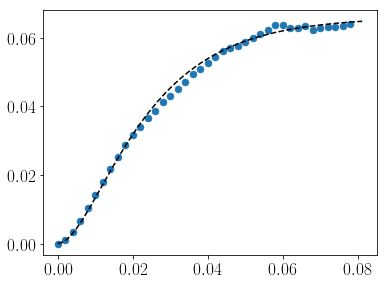

In [97]:
from scipy.optimize import curve_fit
R_sawford = lambda t, T, te: ( np.exp(-t/T)  -  te/T * np.exp(-t/te) ) / (1.0 - te/T)
D_sawford = lambda t, T, te, s: 2*s*(1 - R_sawford(t, T, te))


T = get_TL('b3', 2.5,kind='x')
eps = get_eps('b3',2.5)
nu = 1.5e-5
te = (nu / eps)**0.5 
s = get_Ustats('b3',2.5)[1][0]#**0.5



DL = np.load(os.path.join('DL_data','DL_b3_25.npz'))
tm = np.arange(DL['DL'].shape[0])/FPS


fig, ax = plt.subplots()
tm_model = np.linspace(0,1.3*T)


ax.plot(tm[:40], DL['DL'][:40,0], 'o')
ax.plot(tm_model, D_sawford(tm_model, T/3.5, te, s/1.95), 'k--')

# Calaulate $D_L^2(\tau)$ over the subvolumes

In [98]:
def get_DL(traj_list):
    V = np.zeros(3)
    N = len(traj_list)

    for tr in traj_list:
        V += tr.velocity()[0,:] / N
    
    dv2_lst = []

    for tr in traj_list:
        v_ = tr.velocity() - V
        dv2_lst.append( (v_ - v_[0]) * (v_ - v_[0]) )

    B, N = average_lists(dv2_lst, get_N=True)
    return np.array(B), np.array(N)

In [113]:
dirname = os.path.join('../small_scales','Trajectories',)
savedir = 'DL_data'

sv = [j+i for j  in ['a', 'b', 'c', 'd'] for i in ['1','2','3','4','5']]


for subvol in sv[1:]:
    for U in [2.5, 4.0]:
        t = get_traj_list( os.path.join(dirname, '%s_%.1f.h5'%(subvol,U)) )
        D, N  = get_DL(t)
        np.savez( os.path.join(savedir, 'DL_%s_%d.npz'%(subvol, U*10) ), N = N, DL = D )

<IPython.core.display.Javascript object>


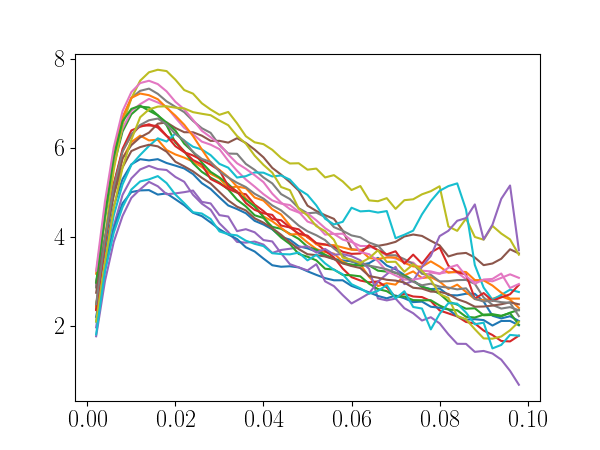

/home/ron/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in divide
  # Remove the CWD from sys.path while we load stuff.


In [121]:
fig, ax = plt.subplots()


for subvol in sv:
    data = np.load( os.path.join(savedir, 'DL_%s_%d.npz'%(subvol, U*10) ) )
    
    eps = get_eps(subvol, U)

    tm = np.arange(50)/FPS
    ax.plot(tm, data['DL'][:50,1] / tm / eps)

<IPython.core.display.Javascript object>


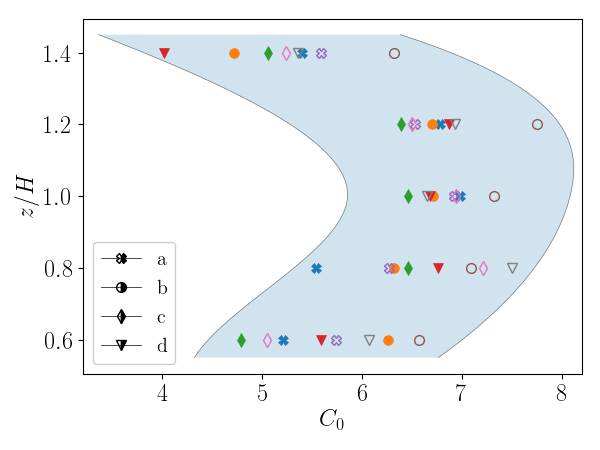

In [56]:
fig, ax = plt.subplots()
savedir = 'DL_data'
U=2.5

e = 0
z_lst = [0.6,0.8,1.0,1.2, 1.4]

c_min, c_max = [100 for i in z_lst], [0 for i in z_lst]

for A in ['a','b','c','d']:
    
    c0_lst = []
    j = 0
    for B in ['1','2','3','4','5']:
        
        subvol = A+B
        
        data = np.load( os.path.join(savedir, 'DL_%s_%d.npz'%(subvol, U*10) ) )
    
        eps = get_eps(subvol, U)

        tm = np.arange(50)/FPS
    
        c0 = max(data['DL'][1:50,1] / tm[1:] / eps)
        c0_lst.append(c0)
        
        if c0 < c_min[j]: c_min[j] = c0
        if c0 > c_max[j]: c_max[j] = c0
        j+=1
        
    ax.plot(c0_lst, z_lst, ''+shapes[e], lw = 0.5)
    e += 1
    
    
    
    
U=4.0
e = 0
for A in ['a','b','c','d']:
    
    c0_lst = []
    j=0
    
    for B in ['1','2','3','4','5']:
        
        subvol = A+B
        
        data = np.load( os.path.join(savedir, 'DL_%s_%d.npz'%(subvol, U*10) ) )
    
        eps = get_eps(subvol, U)

        tm = np.arange(50)/FPS
    
        c0 = max(data['DL'][1:50,1] / tm[1:] / eps)
        c0_lst.append(c0)
        
        if c0 < c_min[j]: c_min[j] = c0
        if c0 > c_max[j]: c_max[j] = c0
        j+=1
        
    ax.plot(c0_lst, z_lst, ''+shapes[e], lw = 0.5, fillstyle='none', mew=1)
    e += 1
    
    
env_min = []
env_max = []
for B in ['1','2','3','4','5']:
    
    c0_lst = []
    
    for A in ['a','b','c','d']:
        for U in [2.5,4.0]:
            subvol = A+B
            data = np.load( os.path.join(savedir, 'DL_%s_%d.npz'%(subvol, U*10) ) )
            eps = get_eps(subvol, U)
            tm = np.arange(50)/FPS
            c0 = max(data['DL'][1:50,1] / tm[1:] / eps)
            c0_lst.append(c0)
    env_min.append(min(c0_lst))
    env_max.append(max(c0_lst))

    
# plot envelope:
env_min = np.array(env_min); env_max = np.array(env_max); z_lst = np.array(z_lst)
from scipy.interpolate import interp1d
x_min, y_min = [4.3, 5.5, 5.6, 3.3], [0.55, .85, 1.1, 1.45]
x_max, y_max = [7.0, 7.9, 7.9, 6.6], [0.55, .95, 1.2, 1.45]
z_new = np.linspace(.55 ,1.45 ,num=50)


from scipy.interpolate import interp1d

zz = [0.55,0.8,1.0,1.2, 1.45]

c_max[2] = 7.85; c_max[4] = 6.2
env_max = interp1d(zz, np.array(c_max)*1.03, kind='cubic')

c_min[0] = 4.5 ; c_min[2] = 6.1;  c_min[3] = 5.5; c_min[4] = 3.5
env_min = interp1d(zz, np.array(c_min)*0.96, kind='cubic')

z_new = np.linspace(zz[0], zz[-1])
ax.plot(env_min(z_new), z_new, 'k-', lw = 0.5, fillstyle='none', alpha=.5)
ax.plot(env_max(z_new), z_new, 'k-', lw = 0.5, fillstyle='none', alpha=.5)
ax.fill_betweenx(z_new, env_min(z_new), x2=env_max(z_new), alpha=.2)
    
    
    
for e,hloc in enumerate(['a','b','c','d']):
    ax.plot([],[],'k-'+shapes[e],lw = 0.5, fillstyle = 'right', label = hloc,mew=1)
ax.legend(loc=3)
    
ax.set_xlabel(r'$C_0$')
ax.set_ylabel(r'$z/H$')
ax.set_xlim([3.2, 8.2])
plt.tight_layout()

fig.savefig('c0.pdf')

# Lagrangian velocity correlation and $T_L$:

<IPython.core.display.Javascript object>


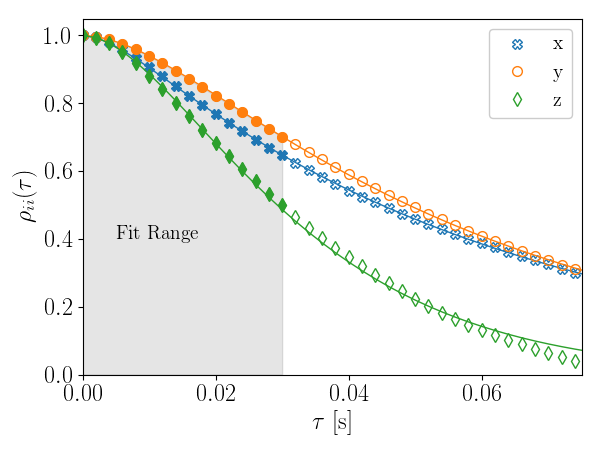

/home/ron/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in divide


In [20]:
from scipy.optimize import curve_fit
R_sawford = lambda t, T, te: ( np.exp(-t/T)  -  te/T * np.exp(-t/te) ) / (1.0 - te/T)
p0 = [0.03, 0.01]



#fig, ax = plt.subplots()


#for sv_h in ['1','2','3','4','5']:
    
#    R, tm, N = get_R('a'+sv_h, 2.5, kind = 'x')
#    stop = np.where(N<8000)[0][0]
#    ax.plot(tm[:stop], R[:stop], label = sv_h)
    
#ax.legend()


urms = get_Ustats(subvol, 2.5)[2]
L = 0.03
Tvol = L / urms


fig, ax = plt.subplots()

R, tm, N = get_R('b3', 2.5, kind = 'x')
fit_range = np.where(tm > Tvol/2.0)[0][0]
stop = np.where(N<40000)[0][0]

ax.plot(tm[:stop], R[:stop], shapes[0], lw=.5, label = 'x', mew=1, fillstyle='none')
ax.plot(tm[:fit_range], R[:fit_range], shapes[0], color=colors[0])

T1,T2 = curve_fit(R_sawford, tm[:stop], R[:stop], p0 = p0)[0]
ax.plot(tm[:stop], R_sawford( tm[:stop][:stop], T1, T2), '-', color=colors[0], lw=1)




R, tm, N = get_R('b3', 2.5, kind = 'y')
ax.plot(tm[:stop], R[:stop], shapes[1], color=colors[1], mew=1, label = 'y', fillstyle='none')
ax.plot(tm[:fit_range], R[:fit_range], shapes[1], color=colors[1])

T1,T2 = curve_fit(R_sawford, tm[:stop], R[:stop], p0 = p0)[0]
ax.plot(tm[:stop], R_sawford( tm[:stop][:stop], T1, T2), '-', color=colors[1], lw=1)

ax.fill_between(tm[:fit_range], y1=R[:fit_range] , color='k', alpha =0.1)


R, tm, N = get_R('b3', 2.5, kind = 'z')
ax.plot(tm[:stop], R[:stop], shapes[2], color=colors[2], mew=1, label = 'z', fillstyle='none')
ax.plot(tm[:fit_range], R[:fit_range], shapes[2], color=colors[2])

T1,T2 = curve_fit(R_sawford, tm[:stop], R[:stop], p0 = p0)[0]
ax.plot(tm[:stop], R_sawford( tm[:stop][:stop], T1, T2), '-', color=colors[2], lw=1)


x = np.linspace(0,0.078)
ax.plot(x, x/x*0, 'k-', lw = 0.5)

ax.set_xlim([-0.00, 0.075])
ax.set_ylim([-0.0, 1.05])
ax.legend()

ax.text(0.005,0.4, 'Fit Range', fontsize=14)

ax.set_xlabel(r'$\tau$ [s]')
ax.set_ylabel(r'$\rho_{ii}(\tau)$')
plt.tight_layout()

fig.savefig('RL_b3_25.pdf')

<IPython.core.display.Javascript object>


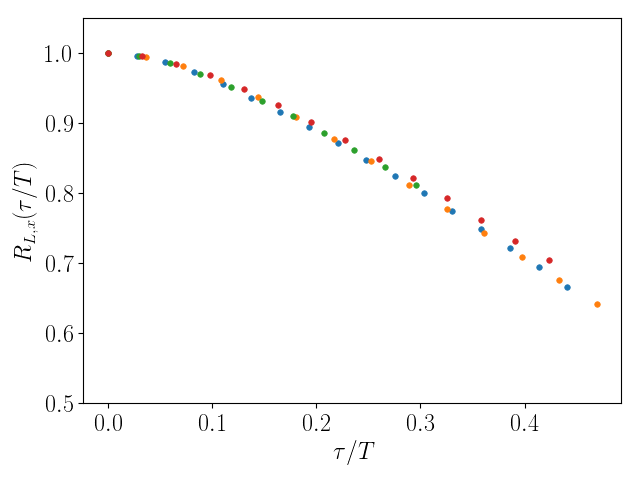

0.073, 0.0002
0.055, 0.0003
0.068, 0.0002
0.061, 0.0002


In [112]:
from scipy.optimize import curve_fit

R_sawford = lambda t, T, te: ( np.exp(-t/T)  -  te/T * np.exp(-t/te) ) / (1.0 - te/T)

p0 = [0.02, 0.01]
fig, ax = plt.subplots()

U = 4.0
e = 0
for h_ in ['a', 'b', 'c', 'd']:
    sv = h_ + '5'
    R, tm ,N = get_R(h_+'5', U, kind = 'x')
    urms = get_Ustats(sv, U)[2]
    L = 0.03
    Tvol = L / urms
        
    fit_range = np.where(tm > Tvol/2.0)[0][0]

    popt, pcov = curve_fit(R_sawford, tm[:fit_range], R[:fit_range], p0 = p0)
    T = popt[0] + popt[1]
    #if sv == 'b5':
    #    T = T*1.25
    err = np.mean((R_sawford(tm[:fit_range],popt[0], popt[1]) - R[:fit_range])**2 / R[:fit_range]**2)**0.5
    print '%.3f, %.4f'%(T, err)
    V = get_Ustats(sv, U)[0][0]
    #print '%.3f'%(-V)
    
    
    stop = np.where(N<20000)[0][0]
    ax.plot(tm[:stop] / T, R[:stop], 'o', color = colors[e], ms = 4, lw = 1)
    #ax.plot(tm[:stop], R_sawford(tm[:stop],popt[0], popt[1]), color = colors[e], lw = 1)
    
    
    e+=1

#ax.set_xlim([-.05,2.1])
ax.set_ylim([.5,1.05])
ax.set_xlabel(r'$\tau / T$')
ax.set_ylabel(r'$R_{L,x}(\tau / T)$')
plt.tight_layout()

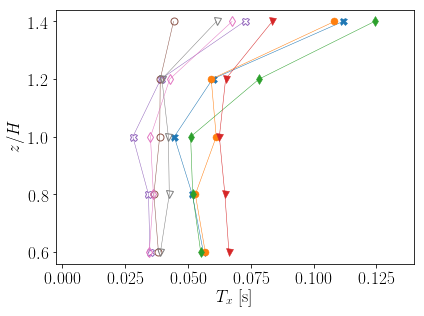

In [35]:
from scipy.optimize import curve_fit
R_sawford = lambda t, T, te: ( np.exp(-t/T)  -  te/T * np.exp(-t/te) ) / (1.0 - te/T)
p0 = [0.03, 0.01]


fig, ax = plt.subplots()
z_lst = [0.6,0.8,1.0,1.2, 1.4]

kind = 'x'

e=0
for hloc in ['a','b','c','d']:
    T_lst = []
    for h_ in ['1','2','3','4','5']:
        R, tm ,N = get_R(hloc+h_, 2.5, kind = kind)
        
        urms = get_Ustats(hloc+h_, 2.5)[2]
        L = 0.03
        Tvol = L / urms
        
        stop = np.where(tm > Tvol/2.0)[0][0]

        popt, pcov = curve_fit(R_sawford, tm[:stop], R[:stop], p0 = p0)
        T = popt[0] + popt[1]
        T_lst.append(T)
    
    ax.plot(T_lst, z_lst, '-'+shapes[e], color = colors[e], lw = 0.5)
    e+=1
    

e=0
for hloc in ['a','b','c','d']:
    T_lst = []
    for h_ in ['1','2','3','4','5']:
        R, tm ,N = get_R(hloc+h_, 4.0, kind = kind)
        
        urms = get_Ustats(hloc+h_, 4.0)[2]
        L = 0.03
        Tvol = L / urms
        
        stop = np.where(tm > Tvol/2.0)[0][0]

        popt, pcov = curve_fit(R_sawford, tm[:stop], R[:stop], p0 = p0)
        T = popt[0] + popt[1]
        T_lst.append(T)
    
    ax.plot(T_lst, z_lst, '-'+shapes[e], mew=1.0, color = colors[e+4], lw = 0.5, fillstyle = 'none')
    e+=1
    

for e,hloc in enumerate(['a','b','c','d']):
    ax.plot([],[],'k-'+shapes[e],lw = 0.5, fillstyle = 'right', label = r'$\lambda$'+hloc)
    
#ax.text(0.075, 1.1,r'$Re_\lambda = 1.6\times 10^4$',fontsize = 15)
#ax.text(0.0, 1.4 ,r'$Re_\lambda = 2.6\times 10^4$',fontsize = 15)

    
#ax.legend(loc=4)
ax.set_xlabel(r'$T_{%s}$ [s]'%kind)
ax.set_ylabel(r'$z/H$')
ax.set_xlim([-0.0025,0.14])
plt.tight_layout()
fig.savefig('TL_%s.pdf'%kind)

0.6519533333716838


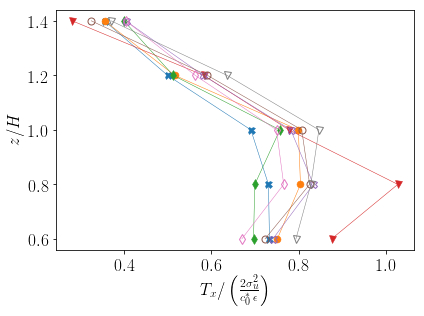

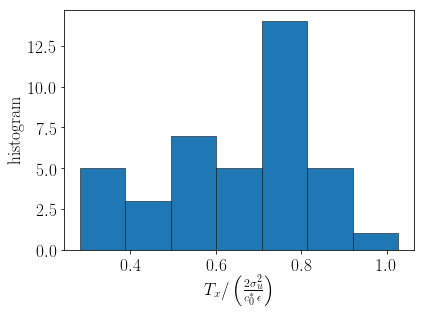

In [6]:
fig, ax = plt.subplots()
z_lst = [0.6,0.8,1.0,1.2, 1.4]

T_normed = []

e=0
for hloc in ['a','b','c','d']:
    T_lst = []
    for h_ in ['1','2','3','4','5']:
        R, tm ,N = get_R(hloc+h_, 2.5, kind = 'x')
        
        urms = get_Ustats(hloc+h_, 2.5)[2]
        L = 0.03
        Tvol = L / urms
        
        stop = np.where(tm > Tvol/2.0)[0][0]

        popt, pcov = curve_fit(R_sawford, tm[:stop], R[:stop], p0 = p0)
        T = popt[0] + popt[1]
        
        data = np.load( os.path.join('DL_data', 'DL_%s_%d.npz'%(hloc+h_, 25) ) )
        eps = get_eps(hloc+h_, 2.5)
        tm = np.arange(50)/FPS
        c0 = max(data['DL'][1:50,1] / tm[1:] / eps)
        
        v2 = get_Ustats(hloc+h_, 2.5)[1][0]
        T_normed.append(T * eps * c0 / 2 / v2)
        T_lst.append(T * eps * c0 / 2 / v2)
        
    ax.plot(T_lst, z_lst, '-'+shapes[e], lw = 0.5)
    e+=1
    
    
    
    
e=0
for hloc in ['a','b','c','d']:
    T_lst = []
    for h_ in ['1','2','3','4','5']:
        R, tm ,N = get_R(hloc+h_, 4.0, kind = 'x')
        urms = get_Ustats(hloc+h_, 4.0)[2]
        L = 0.03
        Tvol = L / urms
        
        stop = np.where(tm > Tvol/2.0)[0][0]

        popt, pcov = curve_fit(R_sawford, tm[:stop], R[:stop], p0 = p0)
        T = popt[0] + popt[1]
        
        data = np.load( os.path.join('DL_data', 'DL_%s_%d.npz'%(hloc+h_, 40) ) )
        eps = get_eps(hloc+h_, 4.0)
        tm = np.arange(50)/FPS
        c0 = max(data['DL'][1:50,1] / tm[1:] / eps)
        
        v2 = get_Ustats(hloc+h_, 4.0)[1][0]
        
        T_normed.append(T * eps * c0 / 2 / v2)
        T_lst.append(T * eps * c0 / 2 / v2)
        
    ax.plot(T_lst, z_lst, '-'+shapes[e], lw = 0.5, mew=1, fillstyle = 'none')
    e+=1

ax.set_xlabel(r"$T_x / \left( \frac{ 2 \sigma_u^2}{ c_0^* \, \epsilon} \right) $")
ax.set_ylabel(r'$z/H$')
#ax.set_xlim([0.2,0.55])
plt.tight_layout()
#fig.savefig('TL_normalized_largescale.pdf')

fig, ax = plt.subplots()
ax.hist(T_normed, bins='auto', edgecolor='black', linewidth=0.5)
ax.set_xlabel(r"$T_x / \left( \frac{ 2 \sigma_u^2}{ c_0^* \, \epsilon} \right) $")
ax.set_ylabel('histogram')
plt.tight_layout()
#fig.savefig('TL_normalized_largescale_hist.pdf')

print np.mean(T_normed)

<IPython.core.display.Javascript object>


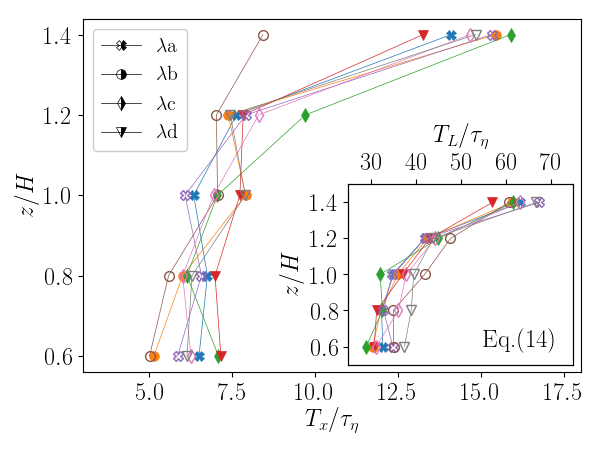

<IPython.core.display.Javascript object>


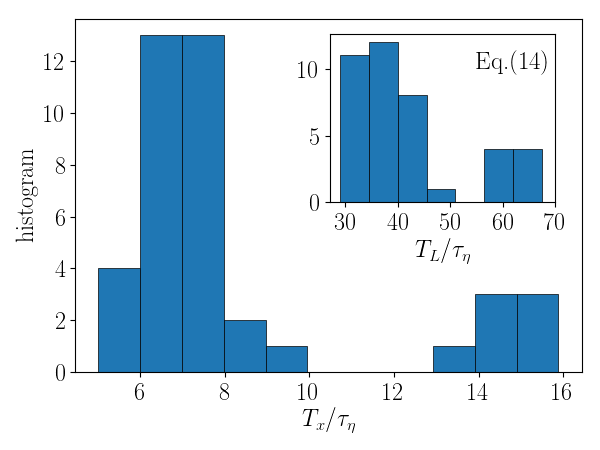

In [22]:
fig, ax = plt.subplots()

inset = fig.add_axes((.58, .19, .375,.4))
top = inset.twiny()
top.set_xlabel(r'$T_L/\tau_\eta$')
inset.set_ylabel(r'$z/H$')

z_lst = [0.6,0.8,1.0,1.2, 1.4]

eq14 = lambda R: ( 4.77 + (R / 12.6)**(4.0/3.0))**(3.0/4.0)
T_normed = []
x_hist = []
e=0
for hloc in ['a','b','c','d']:
    T_lst = []
    x = []
    for h_ in ['1','2','3','4','5']:
        R, tm ,N = get_R(hloc+h_, 2.5, kind = 'x')

        urms = get_Ustats(hloc+h_, 2.5)[2]
        L = 0.03
        Tvol = L / urms
        
        stop = np.where(tm > Tvol/2.0)[0][0]

        popt, pcov = curve_fit(R_sawford, tm[:stop], R[:stop], p0 = p0)
        T = popt[0] + popt[1]
        v2 = get_Ustats(hloc+h_, 2.5)[2]#[1][0]
        eps = get_eps(hloc+h_, 2.5)
        t_eta = (nu/eps)**0.5
        T_lst.append(T / t_eta)
        T_normed.append(T / t_eta)
        
        
        lmda = (15.0 * nu/eps *urms**2)**0.5
        Re = lmda * urms / nu
        x.append(eq14(Re))
        x_hist.append(eq14(Re))
        
    ax.plot(T_lst, z_lst, '-'+shapes[e], lw = 0.5)
    top.plot(x, z_lst, '-'+shapes[e], lw = 0.5)
    e+=1
    
    
    
    
e=0
for hloc in ['a','b','c','d']:
    T_lst = []
    x = []
    for h_ in ['1','2','3','4','5']:
        R, tm ,N = get_R(hloc+h_, 4.0, kind = 'x')

        urms = get_Ustats(hloc+h_, 4.0)[2]
        L = 0.03
        Tvol = L / urms
        
        stop = np.where(tm > Tvol/2.0)[0][0]
        popt, pcov = curve_fit(R_sawford, tm[:stop], R[:stop], p0 = p0)
        T = popt[0] + popt[1]
        v2 = get_Ustats(hloc+h_, 4.0)[2]**2#[1][0]
        eps = get_eps(hloc+h_, 4.0)
        t_eta = (nu/eps)**0.5
        T_lst.append(T / t_eta)
        T_normed.append(T / t_eta)
        
        lmda = (15.0 * nu/eps *urms**2)**0.5
        Re = lmda * urms / nu
        x.append(eq14(Re))
        x_hist.append(eq14(Re))
        
    ax.plot(T_lst, z_lst, '-'+shapes[e], mew=1.0, lw = 0.5, fillstyle = 'none')
    top.plot(x, z_lst, '-'+shapes[e], mew=1.0, lw = 0.5, fillstyle = 'none')
    e+=1
    
    
for e,hloc in enumerate(['a','b','c','d']):
    ax.plot([],[],'k-'+shapes[e],lw = 0.5, fillstyle = 'right', label = r'$\lambda$'+hloc)
ax.legend(loc=2)

ax.set_xlabel(r"$T_x / \tau_\eta $")
ax.set_ylabel(r'$z/H$')
ax.set_xlim([3,18])

inset.set_yticks(z_lst)
inset.set_ylim(.5,1.5)
top.set_xlim(25,75)
top.set_xticks([30,40,50,60,70])
inset.set_xticks([])
top.text(55,.6,'Eq.(14)', fontsize=18)
plt.tight_layout()
#fig.savefig('TL_normalized_smallscale.pdf')


fig, ax = plt.subplots()
inset = fig.add_axes((.55, .55, .375,.375))
ax.hist(T_normed, bins='auto', edgecolor='black', linewidth=0.5)
ax.set_xlabel(r"$T_x / \tau_\eta $")
ax.set_ylabel('histogram')

inset.hist(x_hist, bins='auto', edgecolor='black', linewidth=0.5)
inset.text(55,10,'Eq.(14)', fontsize=18)
inset.set_xticks([30,40,50,60,70])
inset.set_xlabel(r'$T_L / \tau_\eta$')
plt.tight_layout()
fig.savefig('TL_normalized_smallscale_hist.pdf')

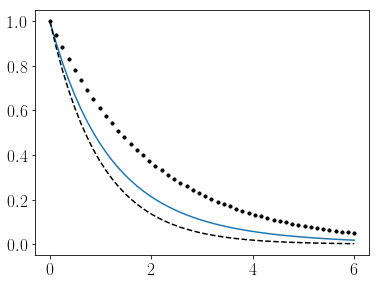

In [84]:
a = 0.5; t1 = 1.0; t2 = 2.0
x = np.linspace(0,6)
y = 1/(1+a)*np.exp(-x/t1) + a/(1+a)*np.exp(-x/t2)

fig, ax = plt.subplots()
ax.plot(x,y)
ax.plot(x, np.exp(-x/t1), 'k--')
ax.plot(x, np.exp(-x/t2), 'k.')

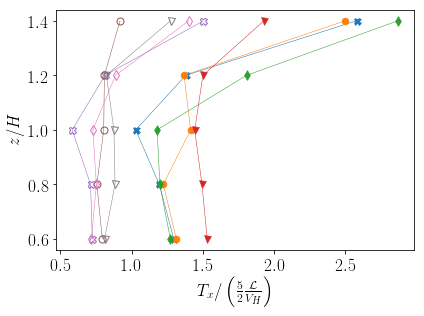

In [28]:
from scipy.optimize import curve_fit

R_sawford = lambda t, T, te: ( np.exp(-t/T)  -  te/T * np.exp(-t/te) ) / (1.0 - te/T)

p0 = [0.03, 0.01]


fig, ax = plt.subplots()
z_lst = [0.6,0.8,1.0,1.2, 1.4]
VH = get_Ustats('a3', 2.5)[0][0]*-1
e=0
for hloc in ['a','b','c','d']:
    T_lst = []
    for h_ in ['1','2','3','4','5']:
        R, tm ,N = get_R(hloc+h_, 2.5, kind = 'x')
        
        urms = get_Ustats(hloc+h_, 2.5)[2]
        L = 0.03
        Tvol = L / urms
        
        stop = np.where(tm > Tvol/2.0)[0][0]

        popt, pcov = curve_fit(R_sawford, tm[:stop], R[:stop], p0 = p0)
        T = popt[0] + popt[1]
        
        data = np.load( os.path.join('DL_data', 'DL_%s_%d.npz'%(hloc+h_, 25) ) )
        eps = get_eps(hloc+h_, 2.5)
        tm = np.arange(50)/FPS
        c0 = max(data['DL'][1:50,1] / tm[1:] / eps)
        
        v2 = get_Ustats(hloc+h_, 2.5)[2]**2#[1][0]
        V = get_Ustats(hloc+h_, 2.5)[0][0]*-1
        T_lst.append(T * VH * 2 / 0.004 / 5)
        
    ax.plot(T_lst, z_lst, '-'+shapes[e], lw = 0.5)
    e+=1
    
    
    
    
e=0
VH = get_Ustats('a3', 4.0)[0][0]*-1
for hloc in ['a','b','c','d']:
    T_lst = []
    for h_ in ['1','2','3','4','5']:
        R, tm ,N = get_R(hloc+h_, 4.0, kind = 'x')
        urms = get_Ustats(hloc+h_, 4.0)[2]
        L = 0.03
        Tvol = L / urms
        
        stop = np.where(tm > Tvol/2.0)[0][0]

        popt, pcov = curve_fit(R_sawford, tm[:stop], R[:stop], p0 = p0)
        T = popt[0] + popt[1]
        
        data = np.load( os.path.join('DL_data', 'DL_%s_%d.npz'%(hloc+h_, 40) ) )
        eps = get_eps(hloc+h_, 4.0)
        tm = np.arange(50)/FPS
        c0 = max(data['DL'][1:50,1] / tm[1:] / eps)
        
        v2 = get_Ustats(hloc+h_, 4.0)[2]**2#[1][0]
        V = get_Ustats(hloc+h_, 4.0)[0][0]*-1
        T_lst.append(T * VH * 2 / 0.004 / 5)
        
    ax.plot(T_lst, z_lst, '-'+shapes[e], lw = 0.5, mew=1, fillstyle = 'none')
    e+=1

ax.set_xlabel(r"$T_x / \left( \frac{5}{2} \frac{\mathcal{L}}{V_H} \right) $")
ax.set_ylabel(r'$z/H$')
#ax.set_xlim([0.2,0.55])
plt.tight_layout()
#fig.savefig('TL_normalized_largescale.pdf')

0.23069314759249776

# Acceleration correlation:

In [73]:
# canopy trajectories:

ax = []
for tr in t:
    if len(tr)>8:
        ax.append(tr.accel()[:,0])
        
Ra, Sa, Na = list_corelation(ax)

vx = []
for tr in t:
    if len(tr)>8:
        vx.append(tr.velocity()[:,0])
        
Rv, Sv, Nv = list_corelation(vx)

In [74]:
# JHU trajectories:

ax = []
for tr in t_jhu:
    ax.append(tr.accel()[:80,0])
    
Ra_jhu, Sa, Na = list_corelation(ax)



vx = []
for tr in t:
    if len(tr)>8:
        vx.append(tr.velocity()[:80,0])
        
Rv_jhu, Sv_jhu, Nv_jhu = list_corelation(vx)

<IPython.core.display.Javascript object>


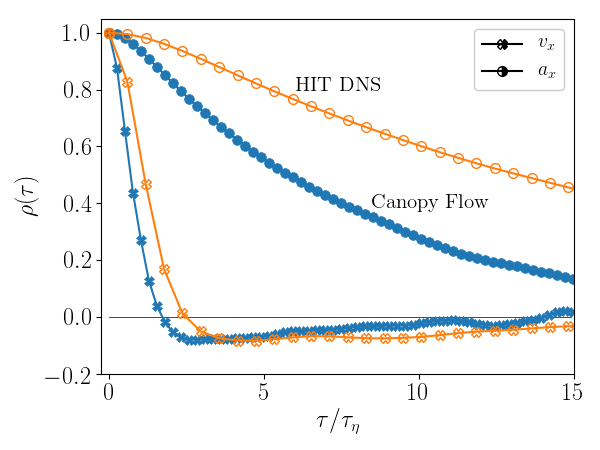

In [89]:
fig, ax = plt.subplots()


ax.plot([0,14.9],[0,0], 'k-', lw = .5)

FPS = 500.0
tm = np.arange(len(Ra))/FPS
ax.plot(tm / t_eta, Ra, '-'+shapes[0], color = colors[0])
ax.plot(tm / t_eta, Rv, '-'+shapes[1], color = colors[0])



tm = np.arange(len(Ra_jhu))/FPS_jhu
ax.plot(tm / t_eta_jhu, Ra_jhu, '-'+shapes[0], color = colors[1], fillstyle = 'none', mew=1)
ax.plot(tm / t_eta_jhu, Rv_jhu, '-'+shapes[1], color = colors[1], fillstyle = 'none', mew=1)

ax.plot([],[], 'k-'+shapes[0], fillstyle = 'right', mew=1, label = r'$v_x$')
ax.plot([],[], 'k-'+shapes[1], fillstyle = 'right', mew=1, label = r'$a_x$')

ax.set_xlim([-0.25,15])
ax.set_ylim([-0.2,1.05])

ax.legend()

ax.text(6.0,0.79, 'HIT DNS', fontsize=15)
ax.text(8.5,0.38, 'Canopy Flow', fontsize=15)

ax.set_xlabel(r'$\tau / \tau_\eta$')
ax.set_ylabel(r'$\rho(\tau)$')
plt.tight_layout()

fig.savefig('vel_accel_cor.pdf')

<IPython.core.display.Javascript object>


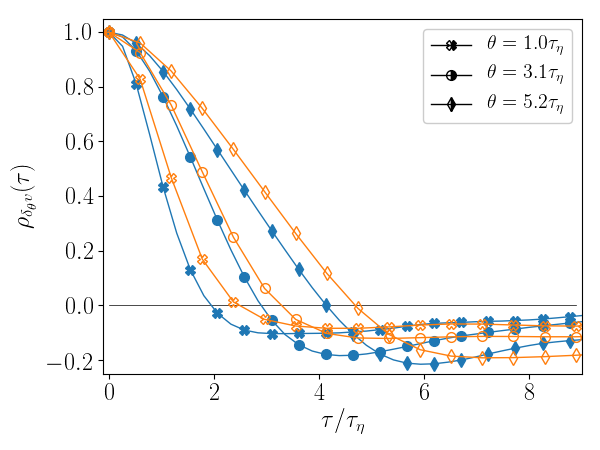

In [70]:
FPS_jhu = 37.5
t_eta_jhu = 0.045
FPS = 500.0


fig, ax = plt.subplots()

ax.plot([0,8.9],[0,0], 'k-', lw = .5)

e = 0
for delta in [4, 12, 20]:
    dv = []
    for tr in t:
        if len(tr)>8 and len(tr)>delta:
            dv.append( tr.velocity()[delta:,0] - tr.velocity()[:-delta, 0] )
        
    Rdv, Sdv, Ndv = list_corelation(dv)
    tm = np.arange(len(Rdv))/FPS
    
    ax.plot(tm / t_eta, Rdv, '-', lw=1, mew=1.5, color = colors[0])
    ax.plot(tm[::2] / t_eta, Rdv[::2], shapes[e], lw=1, mew=1.0, color = colors[0])
    
    lbl = r'$\theta = %.1f \tau_\eta$'%(tm[delta]/t_eta)
    ax.plot([], [], 'k-'+shapes[e], lw=1, mew=1.0, fillstyle = 'right', label = lbl)
    
    e+=1
    
    
    
e = 0
for delta in [2, 5, 9]:  
    dv_jhu = []
    for tr in t_jhu:
        v = tr.velocity()[:80,:]
        dv_jhu.append( v[delta:,0] - v[:-delta,0] )
        
    Rdv_jhu, Sdv_jhu, Ndv_jhu = list_corelation(dv_jhu)
    tm = np.arange(len(Rdv_jhu))/FPS_jhu
    ax.plot(tm / t_eta_jhu, Rdv_jhu, '-'+shapes[e], lw=1, mew=1.0, fillstyle = 'none', color = colors[1])
    e += 1
    

ax.set_xlim([-0.12,9])
ax.set_ylim([-0.25,1.05])
    


ax.set_xlabel(r'$\tau / \tau_\eta$')
ax.set_ylabel(r'$\rho_{\delta_\theta v}(\tau)$')
ax.legend()
plt.tight_layout()

In [71]:
fig.savefig('R_dv.pdf')

# convolutness:

In [258]:
def get_s(traj):
    dx = np.diff(traj.pos(), axis = 0)
    ds = np.sum(dx**2, axis = 1)**0.5
    s = np.array([0])
    for i in range(len(ds)):
        s = np.append(s, s[-1] + ds[i])
    return s




    

r_s = [[1],[]]

for tr in t[:]:
    
    if len(tr)<20:
        continue
        
    while len(r_s) < len(tr):
        r_s.append([])
    
    r = np.sum((tr.pos() - tr.pos()[0,:])**2, axis = 1)**0.5
    s = get_s(tr)
    
    for i in range(len(r)-1):
        r_s[i+1].append(r[i+1]/s[i+1])
        

<IPython.core.display.Javascript object>


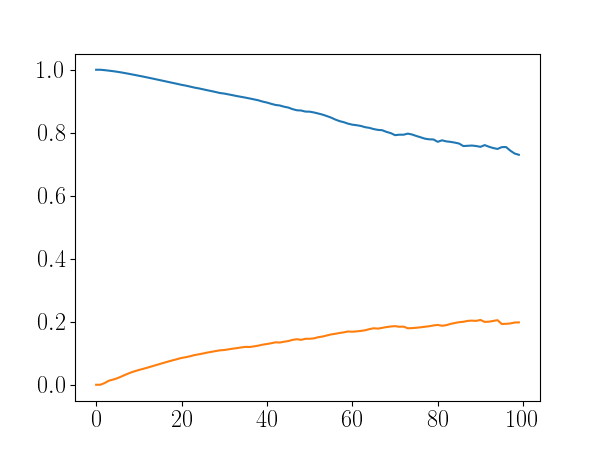

In [255]:
av_r_s = np.array([np.mean(x) for x in r_s])
std_r_s = np.array([np.std(x) for x in r_s])

fig, ax = plt.subplots()

ax.plot(av_r_s[:100])
ax.plot(std_r_s[:100])

In [259]:
def get_p_flct(traj, V):
    tm = np.arange(len(tr))/FPS
    v_ = tr.velocity() - V

    x, y, z = [], [], []
    for i in range(len(tr)):
        x.append(np.trapz(v_[:i,0],tm[:i]))
        y.append(np.trapz(v_[:i,1],tm[:i]))
        z.append(np.trapz(v_[:i,2],tm[:i]))

    return np.transpose(np.array([x,y,z]))




def get_s_p(p):
    dx = np.diff(p, axis = 0)
    ds = np.sum(dx**2, axis = 1)**0.5
    s = np.array([0])
    for i in range(len(ds)):
        s = np.append(s, s[-1] + ds[i])
    return s





r_s_flct = [[1],[]]

for tr in t[:]:
    
    if len(tr)<20:
        continue
        
    while len(r_s_flct) < len(tr):
        r_s_flct.append([])
    
    p = get_p_flct(tr, V)
    
    r = np.sum((p - p[0,:])**2, axis = 1)**0.5
    s = get_s_p(p)
    
    for i in range(len(r)-1):
        r_s_flct[i+1].append(r[i+1]/s[i+1])

/home/ron/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


<IPython.core.display.Javascript object>


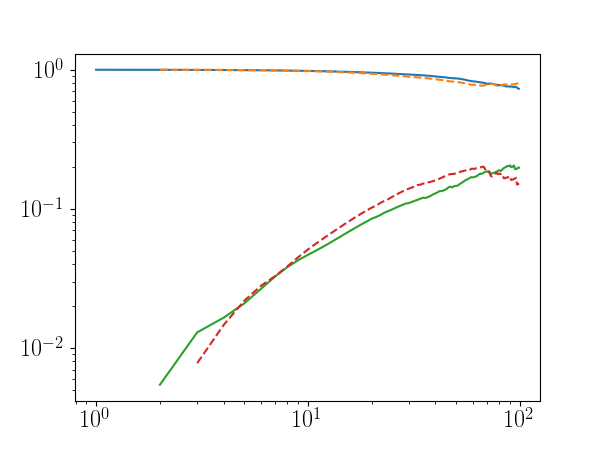

In [265]:
av_r_s_flct = np.array([np.mean(x) for x in r_s_flct])
std_r_s_flct = np.array([np.std(x) for x in r_s_flct])

fig, ax = plt.subplots()

ax.loglog(av_r_s[:100])
ax.loglog(av_r_s_flct[:100],'--')

ax.plot(std_r_s[:100])
ax.plot(std_r_s_flct[:100],'--')

<IPython.core.display.Javascript object>


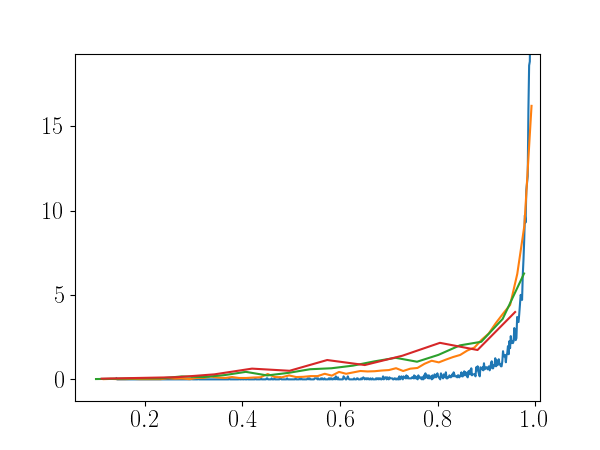

In [262]:
fig, ax = plt.subplots()

for i in [10,30,50,70]:
    x,y = hist_lines(r_s_flct[i], 'auto')
    ax.plot(x,y)

##### with the Sawford 1991 model:

In [333]:
TL = 10.0
tk = 0.1
Re = 150.0
S = 1.0
dt = 0.05

Np = 500
n = 1000
p_lst = [particle(TL, tk, Re, S, dt) for i in range(Np)]
for p in p_lst:
    p.progress(n)

/home/ron/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in divide
  if sys.path[0] == '':


<IPython.core.display.Javascript object>


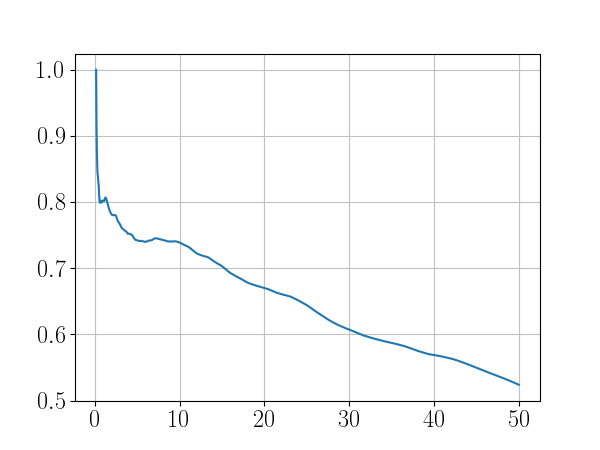

In [334]:

h_lst = [[] for j in range(n+1)]


for p in p_lst:

    dx = np.append([0], np.diff(p.x))
    r = np.cumsum(dx)
    d = np.abs(r)
    s = np.cumsum( np.abs(dx) )

    h = d/s
    
    for j in range(len(h)):
        h_lst[j].append(h[j])

av_h = np.array( [np.mean(hj) for hj in h_lst] )
fig,ax=plt.subplots()

tm = np.arange(n+1)*dt
ax.plot(tm, av_h)
ax.grid()

<IPython.core.display.Javascript object>


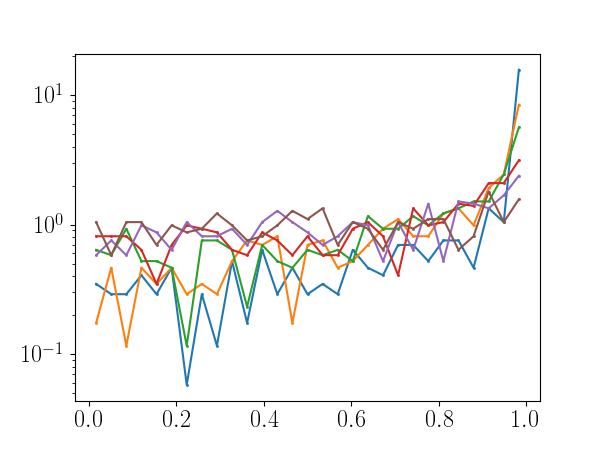

In [335]:
fig,ax=plt.subplots()

for j in [10,200,400,600,800,1000]:
    x,y = hist_lines(h_lst[j], np.linspace(0,1,num=30))
    ax.semilogy(x,y,'-o',ms=1.5)

###### with the JHU DNS:

In [ ]:
fname = '/home/ron/research/jhu_for_pair_dispersion/JHU_Lagrangian_traj/data/jhu_traj_t4_n150.h5'
t_DNS = get_traj_list(fname)

<IPython.core.display.Javascript object>


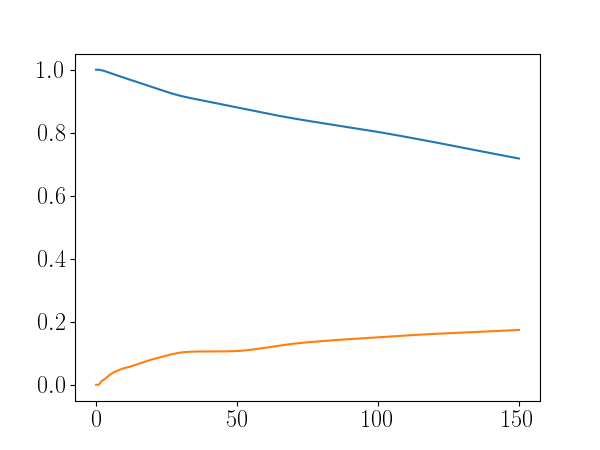

<IPython.core.display.Javascript object>


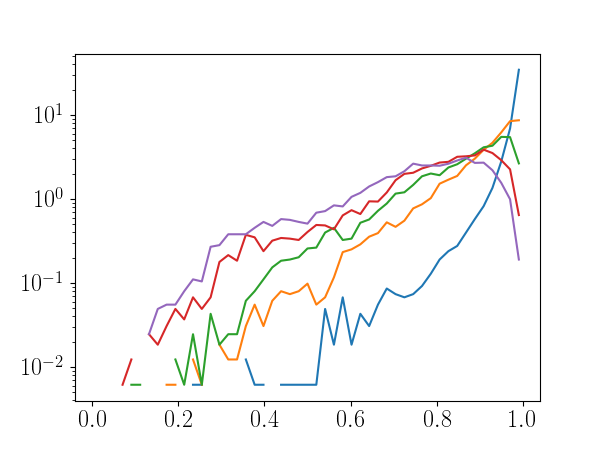

In [337]:


h_lst = [[1],[]]

for tr in t_DNS[:]:
    
    while len(h_lst) < len(tr):
        h_lst.append([])
    
    r = np.sum((tr.pos() - tr.pos()[0,:])**2, axis = 1)**0.5
    s = get_s(tr)
    
    for i in range(len(r)-1):
        h_lst[i+1].append(r[i+1]/s[i+1])
        
        
        
        
av_h = np.array([np.mean(x) for x in h_lst])
std_h = np.array([np.std(x) for x in h_lst])

fig, ax = plt.subplots()

ax.plot(av_h)
ax.plot(std_h)





fig, ax = plt.subplots()

for i in [10,40,70,110,140]:
    x,y = hist_lines(h_lst[i], np.linspace(0,1,num=50))
    ax.semilogy(x,y)


# Smoothing effects

smooth trajectories and see the effect on the root mean acceleration

In [86]:
t_ = filter(lambda tr: len(tr)>20, t)
len(t_)

16567

In [87]:

#a_ms_lst = []
#window = [1,3,5,7,9,11,13,15,17,21,31,41,51]

#for w in window:
#    a_lst = []
#    for tr in t_[:]:
#        if w == 1 : a = tr.accel()[:,0]
#        elif w>len(tr)-1: continue
#        else: a = smooth_traj_poly(tr, w, 2, 500.0).accel()[:,0]
            
#        for val in a:
#            a_lst.append(val**2)
#    a_ms_lst.append(np.mean(a_lst))


    
#
#window_jhu = [1,3,5,7,9,11,13,15,17,23]
#a_ms_jhu_lst = []

#for w in window_jhu:
#    a_lst = []
#    for tr in t_jhu[:]:
#        if w == 1: a = tr.accel()[:,0]
#        else: a = smooth_traj_poly(tr, w, 2, FPS_jhu).accel()[:,0]
            
#        for val in a:
#            a_lst.append(val**2)
#    a_ms_jhu_lst.append(np.mean(a_lst))

In [88]:

np.savez('filtered_accel_rms/filtered_accel_rms_%s.npz'%(subvol), a_rms = a_ms_lst, window = window)
#np.savez('filtered_accel_rms/filtered_accel_rms_jhu.npz', a_rms = a_ms_jhu_lst, window = window_jhu)


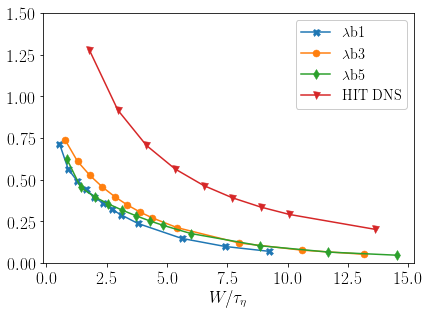

In [25]:
#fig, ax = plt.subplots()

#fltr = np.array(window)/FPS/t_eta
#ax.plot(fltr, np.array(a_ms_lst) / a_ms_lst[0],'o-', label = 'Canopy')

#fltr_jhu = np.array(window_jhu)/FPS_jhu/t_eta_jhu
#ax.plot(fltr_jhu, np.array(a_ms_jhu_lst) / a_ms_jhu_lst[0],'o-', label = 'HIT DNS')

#ax.set_xlabel(r'$W / \tau_\eta$')
#ax.set_ylabel(r'$\langle a^2 \rangle_W / \langle a^2 \rangle_0$')
#ax.legend()
#plt.tight_layout()



fig, ax = plt.subplots()

for e,sv in  enumerate(['b1', 'b3', 'b5']):
    
    data = np.load('filtered_accel_rms/filtered_accel_rms_%s.npz'%(sv))
    a_ms_lst = data['a_rms'][1:]
    window = data['window'][1:]
    
    eps = get_eps(sv, 2.5)
    t_eta = (nu / eps)**0.5
    
    a0 = a_ms_lst / a0_rms[e]#/ a_ms_lst[0]
    #a0 = a_ms_lst / eps**(3.0/2.0) * nu**(0.5)
    fltr = np.array(window)/FPS/t_eta
    lbl = r'$\lambda$' + sv 
    ax.plot(fltr, a0 ,'-'+shapes[e], label = lbl)

    
    
FPS_jhu = 37.5
t_eta_jhu = 0.045
eps_jhu = 0.092
    
data = np.load('filtered_accel_rms/filtered_accel_rms_%s.npz'%('jhu'))
a_ms_jhu_lst = data['a_rms'][1:]
window_jhu = data['window'][1:]

nu_jhu = eps_jhu * t_eta_jhu**2
a0_jhu = a_ms_jhu_lst / a0_rms_jhu #/ a_ms_jhu_lst[0] 
#a0_jhu = a_ms_jhu_lst / eps_jhu**(3.0/2.0) * nu_jhu**0.5
fltr_jhu = window_jhu / FPS_jhu / t_eta_jhu
ax.plot(fltr_jhu, a0_jhu, '-'+shapes[e+1], label = 'HIT DNS')

ax.set_xlabel(r'$W / \tau_\eta$')
#ax.set_ylabel(r'$\langle a^2 \rangle_W / \langle a^2 \rangle_0$')
ax.legend()

ax.set_ylim([0,1.5])

plt.tight_layout()

#fig.savefig('filtered_a_rms.pdf')

In [20]:
a0_rms = []

dirname = os.path.join('../small_scales','Trajectories',)

for e,sv in  enumerate(['b1', 'b3', 'b5']):
    
    Scn = Scene(os.path.join(dirname, '%s_%.1f.h5'%(sv,2.5)))
    ax_2 = []
    
    for tr in Scn.iter_trajectories():
        for i in range(len(tr)):
            ax_2.append( tr.accel()[i,0]**2 )
    
    eps = get_eps(sv, 2.5)
    a0_rms.append(np.mean(ax_2))
    a0 = a0_rms[-1] / eps**(3.0/2.0) * nu**(0.5)
    print '%s: %.3f'%( sv , a0 )

b1: 8.105
b3: 6.182
b5: 5.867


In [24]:
Scn = Scene('/home/ron/Desktop/Research/jhu_for_pair_dispersion/JHU_Lagrangian_traj/data/jhu_traj_t4_n150.h5')
ax_2 = []
    
for tr in Scn.iter_trajectories():
    calc_velocity(tr,FPS_jhu)
    calc_accel(tr,FPS_jhu)
    for i in range(len(tr)):
        ax_2.append( tr.accel()[i,1]**2 )
        
a0_rms_jhu = np.mean(ax_2) 
print a0_rms_jhu

8.313878992796264


##### Calculate and save filtered trajectories at $\Lambda b3$:

In [195]:

# ======  b3 trajs ======== #
window = [0,7,11,15,19,23,27,31,35]
filtered_trajs = [[] for i in window]

Scn = Scene(os.path.join(dirname, 'b3_2.5.h5'))


count = 0
for tr in Scn.iter_trajectories():
    
    if len(tr)<35: continue
    
    e=0
    for w in window:
        if w == 0: filtered_trajs[e].append(tr)
        else:
            filtered_trajs[e].append(smooth_traj_poly(tr, w, 2, 500.0))
        e+=1
        count += 1
    if count >= 10000:
        break
        
        
for i in range(len(window)):
    save_particles_table( 'smoothed_trajectories_2/b3_2.5_filtered_%02d.h5'%window[i],  filtered_trajs[i])

    

    
# ====== jhu trajs ======== #
window = [0,3,5,7,9,11,13,15,17]
filtered_trajs = [[] for i in window]
Scn = Scene('/home/ron/Desktop/Research/jhu_for_pair_dispersion/JHU_Lagrangian_traj/data/jhu_traj_t4_n150.h5')

for i,tr in enumerate(Scn.iter_trajectories()):
    if i%5 != 0 : continue
    e=0
    for w in window:
        if w == 0: filtered_trajs[e].append(tr)
        else:
            filtered_trajs[e].append(smooth_traj_poly(tr, w, 2, FPS_jhu))
        e+=1
        
for i in range(len(window)):
    save_particles_table( 'smoothed_trajectories_2/jhu_filtered_%02d.h5'%window[i],  filtered_trajs[i])

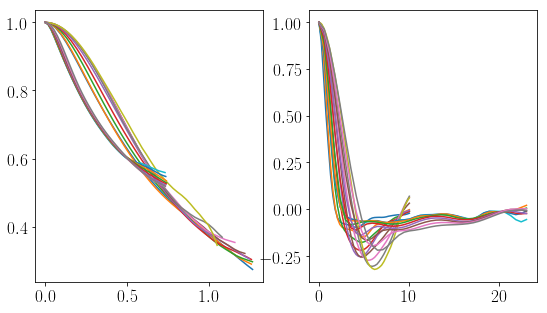

In [6]:
smoothed_files = sorted(os.listdir('smoothed_trajectories_2'))

b3_files = filter(lambda x: x[:2] == 'b3', smoothed_files) 
jhu_files = filter(lambda x: x[:3] == 'jhu', smoothed_files) 


from scipy.optimize import curve_fit
R_sawford = lambda t, T, te: ( np.exp(-t/T)  -  te/T * np.exp(-t/te) ) / (1.0 - te/T)
p0 = [0.02, 0.01]


fig, ax = plt.subplots(1,2)
fig.set_size_inches(9,5)

eps = get_eps('b3', 2.5)

Tv, Ta = [], []
for f_ in b3_files:
    Scn = Scene( os.path.join('smoothed_trajectories_2', f_) )
    vx = [tr.velocity()[:,0] for tr in Scn.iter_trajectories()]
    R, S, N = list_corelation(vx)
    t_eta = (nu / eps)**0.5
    tm = np.arange(40) / FPS 
    sol0,sol1 = curve_fit(R_sawford, tm[:40], R[:40], p0=p0)
    T_v = sol0[0] + sol0[1]
    Tv.append(T_v)
    ax[0].plot(tm[:40]/T_v, R[:40])
    
    ax_ = [tr.accel()[:,0] for tr in Scn.iter_trajectories()]
    R, S, N = list_corelation(ax_)
    ax[1].plot(tm[:40]/t_eta, R[:40])
    T_a = find_crossing(R[:40], tm[:40], 0)[0]
    Ta.append(T_a)

Tv, Ta = np.array(Tv), np.array(Ta)
Tv_over_Ta = Tv / Ta


Tv_jhu, Ta_jhu = [], []
for f_ in jhu_files:
    Scn = Scene( os.path.join('smoothed_trajectories_2', f_) )
    vx, ax_ = [], []
    
    for tr in Scn.iter_trajectories():
        calc_velocity(tr, FPS_jhu)
        calc_accel(tr, FPS_jhu)
        
        vx.append(tr.velocity()[10:50,0])
        vx.append(tr.velocity()[70:110,0])
        vx.append(tr.velocity()[120:,0])
        
        ax_.append(tr.accel()[10:50,0])
        ax_.append(tr.accel()[70:110,0])
        ax_.append(tr.accel()[120:,0])
        
    R, S, N = list_corelation(vx)
    tm = np.arange(40) / FPS_jhu 
    sol0,sol1 = curve_fit(R_sawford, tm[:40], R[:40], p0=p0)
    T_v = sol0[0] + sol0[1]
    Tv_jhu.append(T_v)
    ax[0].plot(tm[:40]/T_v, R[:40])
    
    R, S, N = list_corelation(ax_)
    ax[1].plot(tm[:40]/t_eta_jhu, R[:40])
    T_a = find_crossing(R[:40], tm[:40], 0)[0]
    Ta_jhu.append(T_a)
Tv_jhu, Ta_jhu = np.array(Tv_jhu), np.array(Ta_jhu)
Tv_over_Ta_jhu = Tv_jhu / Ta_jhu

    

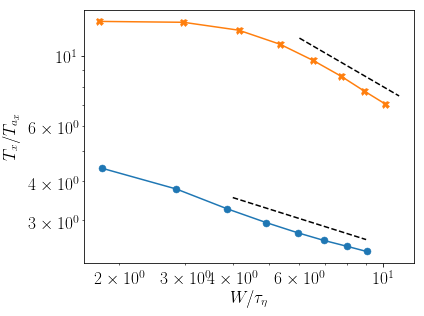

In [19]:
#fig, ax = plt.subplots(1,2)
#fig.set_size_inches(10,4)

fig, ax = plt.subplots()
    
w = np.array([0,7,11,15,19,23,27,31,35]) / FPS / t_eta
ax.plot(w[1:], Tv_over_Ta[1:] , 'o-')
#ax[1].plot(w, Tv / Tv[0], 'o-')
#ax[1].plot(w, Ta / Ta[0], 'o-')


w_jhu = np.array([0,3,5,7,9,11,13,15,17]) / FPS_jhu / t_eta_jhu
ax.plot(w_jhu[1:], Tv_over_Ta_jhu[1:] , 'X-')
#ax[1].plot(w_jhu, Tv_jhu / Tv_jhu[0], 'X-')
#ax[1].plot(w, Ta_jhu / Ta_jhu[0], 'X-')
ax.set_xlabel(r'$W / \tau_\eta$')
ax.set_ylabel(r'$T_x / T_{a_x}$')



x = np.linspace(4,9)
ax.plot(x, 6*x**-.38, 'k--')
x = np.linspace(6,11)
ax.plot(x, 40*x**-.7, 'k--')

#ax.set_xticks([2,3,4,6,10])
#ax.set_xticklabels([2,3,4,6,10])


#from matplotlib.ticker import FormatStrFormatter
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))

ax.set_xscale('log')
ax.set_yscale('log')

plt.tight_layout()



In [205]:
smoothed_files = sorted(os.listdir('smoothed_trajectories_2'))

b3_files = filter(lambda x: x[:2] == 'b3', smoothed_files) 
jhu_files = filter(lambda x: x[:3] == 'jhu', smoothed_files) 



eps = get_eps('b3', 2.5)
v_rms_lst, a_rms_lst = [], []
w = []
for f_ in b3_files:
    t_ = get_traj_list(os.path.join('smoothed_trajectories_2', f_))
    w.append(int(f_[-5:-3]))
    V_ = get_mean_velocity(t_)
    v_, a_ = [], []
    for tr in t_:
        for i in range(len(tr)):
            v_.append( (tr.velocity()[i,0] - V_[0])**2 )
            a_.append(  tr.accel()[i,0]**2 )
    v_rms_lst.append( np.mean(v_) )
    a_rms_lst.append( np.mean(a_) )

print w

v_rms_lst_jhu, a_rms_lst_jhu = [], []
w_jhu = []
for f_ in jhu_files:
    t_ = get_traj_list(os.path.join('smoothed_trajectories_2', f_))
    V_ = get_mean_velocity(t_)
    w_jhu.append(int(f_[-5:-3]))
    v_ , a_= [], []
    for tr in t_:
        calc_velocity(tr, FPS_jhu)
        calc_accel(tr, FPS_jhu)
        for i in range(len(tr)):
            v_.append( (tr.velocity()[i,0] - V_[0])**2 )
            a_.append( tr.accel()[i,0]**2 )
    
    v_rms_lst_jhu.append( np.mean(v_) )
    a_rms_lst_jhu.append( np.mean(a_) )

print w_jhu

[0, 7, 11, 15, 19, 23, 27, 31, 35]
[0, 3, 5, 7, 9, 11, 13, 15, 17]


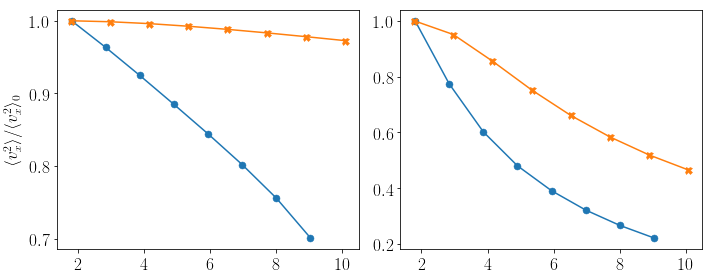

In [210]:

    
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,4)

w_ = np.array(w) / FPS / t_eta
ax[0].plot(w_[1:], np.array(v_rms_lst[1:]) / v_rms_lst[1], 'o-')
ax[1].plot(w_[1:], np.array(a_rms_lst[1:]) / a_rms_lst[1], 'o-')



w_ = np.array(w_jhu) / FPS_jhu / t_eta_jhu
ax[0].plot(w_[1:], np.array(v_rms_lst_jhu[1:])/v_rms_lst_jhu[1], 'X-')
ax[1].plot(w_[1:], np.array(a_rms_lst_jhu[1:])/a_rms_lst_jhu[1], 'X-')

#ax.set_xlabel(r'$W / \tau_\eta$')
ax[0].set_ylabel(r'$\langle v_x^2 \rangle / \langle v_x^2 \rangle_0 $')

plt.tight_layout()

# Coarse Grained signal, $\hat{U}$:

see also a separate notebook

In [440]:
Tvs = 0.1/2.5 * 5
ax.plot([Tvs,Tvs], [0,1], 'k--', lw = 1)
Tvs

In [364]:
def get_frame_seq(traj_list, n, th = 100):
    '''
    returns lists of ids of trajectories that are densly separated in time with spaces no 
    larger than n frame number with zero particles.
    will make a list only if there are at least th such n-separated consecutive frames.
    '''
    ft = get_frame_traj(traj_list)
    frames = sorted(ft.keys())
    diffs = np.where(np.diff(frames) > n)[0]
    seqs = []
    
    for i in range(len(diffs)-1):
        
        if frames[diffs[i+1]] - frames[diffs[i]+1] >= th:
            seqs.append([])
            
            for k in range( int(frames[diffs[i]+1]), int(frames[diffs[i+1]]) ):
                if ft.has_key(k):
                    for id_ in ft[k]:
                        if id_ not in seqs[-1]:
                            seqs[-1].append(id_)
    return seqs
        
    

    
def get_space_time_mean_velocity(traj_list, n, th):
    
    seqs = get_frame_seq(traj_list, n ,th)
    
    U_lst, tm_lst = [], []
    
    for seq in seqs:
        t_ = get_traj_by_id(seq, traj_list)
        
        tm = np.array([tr.time()[0] for tr in t_])
        t0 = min(tm)
        tmax = max(tm)
        Nbins = int((tmax-t0)/n + 1)
        
        a_bins = [[] for i in range(Nbins)]

        for tr in t_:
            for i in range(len(tr)):
                if tr.time()[i]>=tmax:continue
                ind = int((tr.time()[i] - t0) / (tmax - t0)*Nbins)
                a_bins[ind].append(tr.velocity()[i,0])

        M = np.array([np.mean(a) for a in a_bins])
        U_lst.append(M)
        
        dt = n/FPS
        tm_lst.append(np.arange(Nbins)*dt)
    
    return U_lst, tm_lst
        

In [365]:
U, tm = get_space_time_mean_velocity(t[:], 20, 1000)
print len(U), len(tm)

45 45


<IPython.core.display.Javascript object>


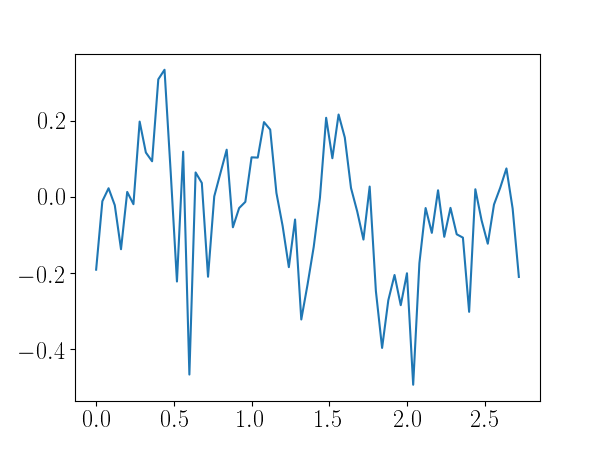

In [239]:
fig, ax = plt.subplots()
V = get_Ustats(subvol, 2.5)[0][0]
ax.plot(tm[10], U[10]-V)



<IPython.core.display.Javascript object>


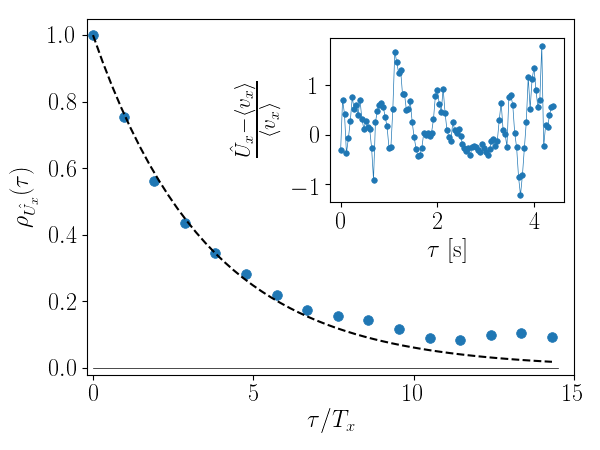

In [242]:
T = get_TL('b3',2.5)
V = get_Ustats('b3', 2.5)[0][0]

u_ = [np.array(x[:-1])-V for x in U]
R,S,N = list_corelation(u_)

fig, ax = plt.subplots()
ax.plot(tm[0][:40]/T, R[:40], 'o')

x = np.linspace(0,.6)
ax.plot(x/T, np.exp(-x/0.15), 'k--')
ax.plot([0,14.5], [0,0], 'k-', lw=.5)
ax.set_xlim([-0.2,15])
ax.set_ylim([-0.02,1.05])
ax.set_xlabel(r'$\tau / T_x$')
ax.set_ylabel(r'$\rho_{\hat{U_x}}(\tau)$')


inset = fig.add_axes((.55,.55, .39, .365))
inset.plot(tm[0], (U[0]-V)/V, '-o', lw=.5, ms=4)
inset.set_ylabel(r'$\frac{\hat{U}_x - \langle v_x \rangle }{\langle v_x \rangle}$', size=22)
inset.set_xlabel(r'$\tau$ [s]')

plt.tight_layout()
#fig.savefig('U_fltr.pdf')

<IPython.core.display.Javascript object>


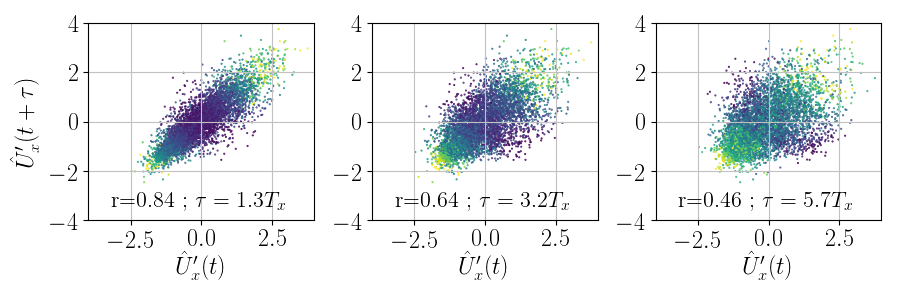

In [367]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(9,3)

#sigma_u = get_Ustats(subvol, 2.5)[1][0]**0.5
#V = get_Ustats(subvol, 2.5)[0][0]

U_ = [np.array(x[:-1]) for x in U]
u_lst = []
for u_ in U_:
    for val in u_:
        u_lst.append(val)

V = np.mean(u_lst)
sigma_u = np.std(u_lst)


for e,d in enumerate([2,5,9]):
#for e,d in enumerate([1,3,6]):
    r = []
    #ax[e].plot([-3,3],[-3,3], 'r-', alpha=.4)
    #ax[e].plot([-3,3],[3,-3], 'r-', alpha=.4)
    ax[e].grid()
    for u_ in U_:
        u_1, u_2 = -1*(u_[d:]-V), -1*(u_[:-d]-V)
        c = u_1*u_2 / sigma_u**2
        ax[e].scatter(u_1/sigma_u, u_2/sigma_u, s=.25, c = c)
    
    
        for val in c:
            r.append(val)
    Tx = get_TL(subvol, 2.5)
    t_ = tm[0][d]/Tx
    ax[e].text(.1,.05, r'r=%.2f  ;  $\tau=%.1fT_x$'%(np.mean(r), t_) , transform=ax[e].transAxes, fontsize=16)
        
    ax[e].set_xlim([-4,4])
    ax[e].set_ylim([-4,4])
    ax[e].set_xlabel(r"$\hat{U}_x'(t)} $")
    #ax[e].set_xlabel(r"$\hat{U}_x'(t)} $",fontsize=22)
    
ax[0].set_ylabel(r"$\hat{U}_x'(t+\tau)} $")
    
plt.tight_layout()
fig.savefig('Uf_scatter_%s.pdf'%subvol)

In [162]:
# Save correlations of hat{U}:

dirname = os.path.join('../small_scales','Trajectories',)

U_ = 4.0

for U_ in [2.5,4.0]:
    for sv in subvolumes:
        t_ = get_traj_list( os.path.join(dirname, '%s_%.1f.h5'%(sv,U_)) )
        V = get_Ustats(sv, U_)[0][0]
        U, tm = get_space_time_mean_velocity(t_, 10, 600)
    
        u_ = [np.array(x[:-1])-V for x in U]
        R,S,N = list_corelation(u_)
    
        fname = 'U_fltr_correlations/with_mean_subtraction/Uf_corr_%s_%d.npz'%(sv,10*U_)
        np.savez(fname, R = R, tm = max(tm, key = len) )




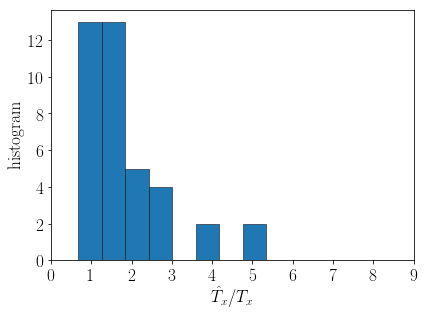

In [6]:
fig, ax = plt.subplots()

f = lambda x,T,a: a + (1-a)*np.exp(-x / T)


T_lst = []
for sv in subvolumes[:]:

    data = np.load('U_fltr_correlations/Uf_corr_%s_25.npz'%(sv))
    tm,R = data['tm'][:20], data['R'][:20] 
    #Tf = -tm[1:4] / np.log(R[1:4])
    Tf,a = curve_fit(f, tm,R)[0]
    Tx = get_TL(sv,2.5)
    if sv!='b3':
        T_lst.append(np.mean(Tf)/Tx)
        
    #ax.plot(tm[1:4], Tf,'o-')
    
    data = np.load('U_fltr_correlations/Uf_corr_%s_40.npz'%(sv))
    tm,R = data['tm'][:15], data['R'][:15]
    #Tf = -tm[1:4] / np.log(R[1:4])
    Tf,a = curve_fit(f, tm,R)[0]
    Tx = get_TL(sv,2.5)
    T_lst.append(np.mean(Tf)/Tx)
    #ax.plot(tm[1:4], Tf,'o-')
    
ax.hist(T_lst, edgecolor='black', linewidth=0.5, bins='auto')
ax.set_xticks(range(10))
ax.set_xlabel(r'$\hat{T}_x/T_x$')
ax.set_ylabel('histogram')

plt.tight_layout()

#fig.savefig('T_fltr.pdf')

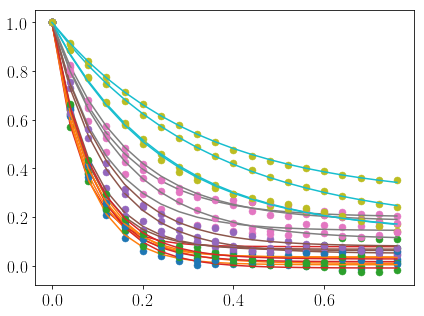

In [5]:
fig, ax = plt.subplots()

f = lambda x,T,a: a + (1-a)*np.exp(-x / T)

shape_dic = dict( zip(['a','b','c','d'],shapes[:4]) )
col_dic1 = dict( zip(['a','b','c','d'] , colors[:4]) )
col_dic2 = dict( zip(['a','b','c','d'] , colors[4:8]) )

T_lst = []
for sv in subvolumes[:]:

    z = (int(sv[-1])-1)*0.2 + 0.6
    H = 0.1
    
    data = np.load('U_fltr_correlations/Uf_corr_%s_25.npz'%(sv))
    tm,R = data['tm'][:20], data['R'][:20] 
    #Tf = np.mean(-tm[1:4] / np.log(R[1:4]))
    Tf,a = curve_fit(f, tm,R)[0]
    Tx = get_TL(sv,2.5)
    if sv!='b3':
        T_lst.append(np.mean(Tf)/Tx)
        
    #ax.plot( Tf/Tx, z, shape_dic[sv[0]], mew = 1, color = col_dic1[sv[0]] )
    ax.plot( tm , R ,'o')
    ax.plot( tm , f(tm,Tf,a) ,'-')
    
    
    
    data = np.load('U_fltr_correlations/Uf_corr_%s_40.npz'%(sv))
    tm,R = data['tm'][:15], data['R'][:15]
    #Tf = np.mean(-tm[1:4] / np.log(R[1:4]))
    Tf,a = curve_fit(f, tm,R)[0]
    Tx = get_TL(sv,2.5)
    T_lst.append(np.mean(Tf)/Tx)
    
    #ax.plot( Tf/Tx, z, shape_dic[sv[0]], fillstyle = 'none', mew = 1, color = col_dic2[sv[0]] )
    #ax.plot( tm , R ,'o')
    #ax.plot( tm , f(tm,Tf,a) ,'-')
#ax.set_xticks([0,1,2,3,4,5,6])

    
    
plt.tight_layout()


### Test on the JHU data:

In [113]:
t_jhu = get_traj_list('/home/ron/Desktop/Research/jhu_for_pair_dispersion/JHU_Lagrangian_traj/data/jhu_traj_t4_n150.h5')
FPS_jhu = 37.5
t_eta_jhu = 0.045

In [42]:
vx = []
for tr in t_jhu:
    #vx.append(tr.velocity()[:73,0])
    vx.append(tr.velocity()[-73:,0])
R,S,N = list_corelation(vx)

(0, 1.05)

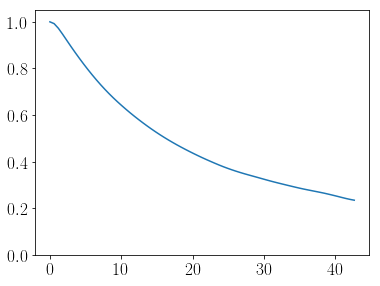

In [43]:
fig, ax = plt.subplots()
tm = np.arange(len(R))/FPS_jhu / t_eta_jhu
ax.plot(tm, R)
ax.set_ylim([0,1.05])

In [37]:
ind = range(0,8200,400)

vf_lst = []
for i in range(len(ind)-1):
    
    t_ = t_jhu[ind[i] : ind[i+1]]
    
    vx = [tr.velocity()[:,0] for tr in t_]
    vf = average_lists(vx)
    vf_lst.append(vf)

In [40]:
R_f,S_f,N_f = list_corelation(vf_lst)


(0, 1.05)

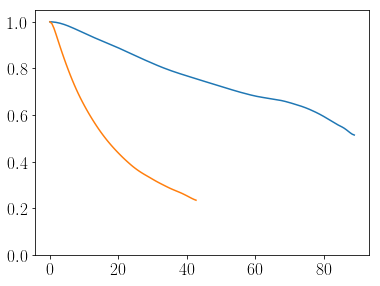

In [44]:
fig, ax = plt.subplots()
tm_f = np.arange(len(R_f))/FPS_jhu / t_eta_jhu
ax.plot(tm_f, R_f)
ax.plot(tm, R)
ax.set_ylim([0,1.05])

### Conclude this - 
both in the JHU and in the canopy experiment averaging of velocities of different particles resulted in a signal of much longer correlation. Thus, this is not a unique feature of the canopy particles.

# Changes in velocity:


$$ \delta_\tau v_i = v_i(\tau)  -  v_i (0)$$

In [83]:
def get_angle(a,b):
    '''
    for two vectors (arrays) a,b this will return the angle between them --
    acrcos( a * b / |a||b| )
    '''
    alpha = np.arccos(np.dot(a,b) / np.linalg.norm(a) / np.linalg.norm(b))
    return alpha



def get_a_para_a_perp(tr):
    '''
    returns the size of acceleration components that are paralel and 
    perpendicular to the trajectory
    '''
    # the trajectory unit vector
    e = tr.velocity() / np.array([np.linalg.norm(tr.velocity(), axis = 1)]).transpose()
    a_para = np.linalg.norm(tr.accel()*e, axis=1)
    a_perp = np.linalg.norm(tr.accel() - np.array([a_para]).transpose() * e, axis = 1)
    return a_para, a_perp

In [108]:
a_paralel, a_perpendicular = [], []

for tr in t[:]:
    
    a_para, a_perp = get_a_para_a_perp(tr)
    for i in range(len(tr)):
        a_paralel.append(a_para[i])
        a_perpendicular.append(a_perp[i])

In [116]:
FPS_jhu = 37.5
t_eta_jhu = 0.045


a_paralel_jhu, a_perpendicular_jhu = [], []

for tr in t_jhu[:]:
    
    a_para, a_perp = get_a_para_a_perp(tr)
    for i in range(len(tr)):
        a_paralel_jhu.append(a_para[i])
        a_perpendicular_jhu.append(a_perp[i])

13.98, 27.98
2.70, 5.63


<IPython.core.display.Javascript object>


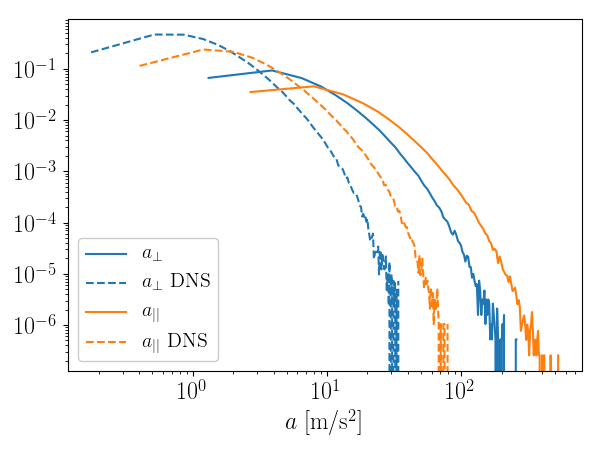

In [126]:
s_para, s_perp = np.mean(np.array(a_paralel)**2)**0.5, np.mean(np.array(a_perpendicular)**2)**0.5
s_para_jhu, s_perp_jhu = np.mean(np.array(a_paralel_jhu)**2)**0.5, np.mean(np.array(a_perpendicular_jhu)**2)**0.5

print '%.2f, %.2f'%(s_para, s_perp)
print '%.2f, %.2f'%(s_para_jhu, s_perp_jhu)

fig, ax = plt.subplots()

x,y = hist_lines(a_paralel, bins = 100)
ax.loglog(x , y , color=colors[0], label = r'$a_\perp$')

x,y = hist_lines(a_paralel_jhu, bins = 100)
ax.loglog(x , y, '--', color=colors[0], label = r'$a_\perp$ DNS')


x,y = hist_lines(a_perpendicular, bins = 100)
ax.loglog(x, y, color = colors[1], label = r'$a_{||}$')

x,y = hist_lines(a_perpendicular_jhu, bins = 100)
ax.loglog(x, y, '--', color=colors[1], label = r'$a_{||}$ DNS')

ax.legend(loc=3)
ax.set_xlabel(r'$a$ [m/s$^2$]')
plt.tight_layout()

In [150]:
a_para_lst, a_perp_lst, A_lst = [], [], []
ax_lst = []

for tr in t[:20000]:
    
    a_para, a_perp = get_a_para_a_perp(tr)
    
    a_para_lst.append(a_para[:40])
    a_perp_lst.append(a_perp[:40])
    A_lst.append( np.linalg.norm(tr.accel()[:40,:],axis =1) )
    ax_lst.append( tr.accel()[:40,0] )
    
R_para, S, N = list_corelation(a_para_lst)
R_perp, S, N = list_corelation(a_perp_lst)
R_A, S, N = list_corelation(A_lst)
R_ax, S, N = list_corelation(ax_lst)



a_para_lst_jhu, a_perp_lst_jhu, A_lst_jhu = [], [], []
ax_lst_jhu = []
for tr in t_jhu:
    
    a_para, a_perp = get_a_para_a_perp(tr)
    
    a_para_lst_jhu.append(a_para[30:50])
    a_perp_lst_jhu.append(a_perp[30:50])
    A_lst_jhu.append( np.linalg.norm(tr.accel()[30:50,:],axis =1) )
    ax_lst_jhu.append( tr.accel()[30:50,0] )
    
R_para_jhu, S, N = list_corelation(a_para_lst_jhu)
R_perp_jhu, S, N = list_corelation(a_perp_lst_jhu)
R_A_jhu, S, N = list_corelation(A_lst_jhu)
R_ax_jhu, S, N = list_corelation(ax_lst_jhu)

<IPython.core.display.Javascript object>


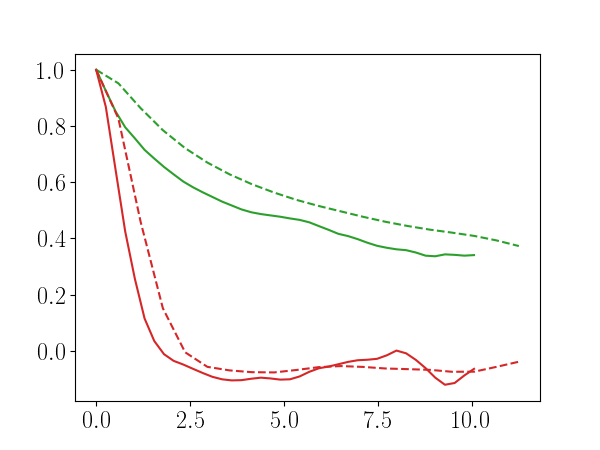

In [152]:
fig, ax = plt.subplots()

tm = np.arange(len(R_para))/FPS/t_eta

#ax.plot(tm, R_para, color = colors[0])
#ax.plot(tm, R_perp, color = colors[1])
ax.plot(tm, R_A, color = colors[2])
ax.plot(tm, R_ax, color = colors[3])


tm = np.arange(len(R_para_jhu))/FPS_jhu/t_eta_jhu

#ax.plot(tm, R_para_jhu, '--', color = colors[0])
#ax.plot(tm, R_perp_jhu, '--', color = colors[1])
ax.plot(tm, R_A_jhu, '--', color = colors[2])
ax.plot(tm, R_ax_jhu, '--', color = colors[3])

In [177]:
V_lst, vx_lst = [], []

for tr in t[:20000]:
    
    V_lst.append( np.linalg.norm(tr.velocity()[:40,:] - V,axis =1) )
    vx_lst.append( tr.velocity()[:40,0] - V[0] )
    
R_V, S, N = list_corelation(V_lst)
R_vx, S, N = list_corelation(vx_lst)


V_lst_jhu, vx_lst_jhu = [], []

for tr in t_jhu:
    
    V_lst_jhu.append( np.linalg.norm(tr.velocity()[30:50,:],axis =1) )
    V_lst_jhu.append( np.linalg.norm(tr.velocity()[60:80,:],axis =1) )
    vx_lst_jhu.append( tr.velocity()[30:50,0] )
    vx_lst_jhu.append( tr.velocity()[60:80,0] )

R_V_jhu, S, N = list_corelation(V_lst_jhu)
R_vx_jhu, S, N = list_corelation(vx_lst_jhu)

<IPython.core.display.Javascript object>


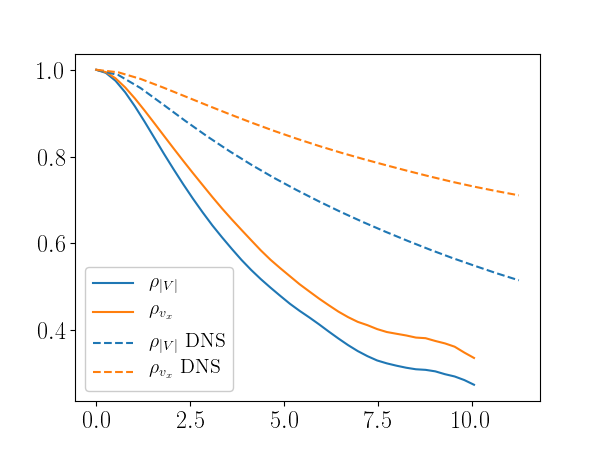

In [178]:
fig, ax = plt.subplots()

tm = np.arange(len(R_V))/FPS/t_eta
ax.plot(tm, R_V, '-', color = colors[0], label = r'$\rho_{|V|}$')
ax.plot(tm, R_vx, '-', color = colors[1], label = r'$\rho_{v_x}$')


tm = np.arange(len(R_V_jhu))/FPS_jhu/t_eta_jhu
ax.plot(tm, R_V_jhu, '--', color = colors[0], label = r'$\rho_{|V|}$ DNS')
ax.plot(tm, R_vx_jhu, '--', color = colors[1], label = r'$\rho_{v_x}$ DNS')

ax.legend()

In [166]:
dV_lst, dvx_lst = [], []

for tr in t[:20000]:
    
    if len(tr)<3: continue
        
    v_ = tr.velocity()[:40]
    dvx_lst.append( v_[1:] - v_[:-1] )
    dV_lst.append( np.abs(v_[1:] - v_[:-1]) )
    
R_dV, S, N = list_corelation(dV_lst)
R_dvx, S, N = list_corelation(dvx_lst)


dV_lst_jhu, dvx_lst_jhu = [], []

for tr in t_jhu:
    
    v_ = tr.velocity()[30:55,0]
    dvx_lst_jhu.append( v_[2:] - v_[:-2] )
    dV_lst_jhu.append( np.abs(v_[2:] - v_[:-2]) )

R_dV_jhu, S, N = list_corelation(dV_lst_jhu)
R_dvx_jhu, S, N = list_corelation(dvx_lst_jhu)

<IPython.core.display.Javascript object>


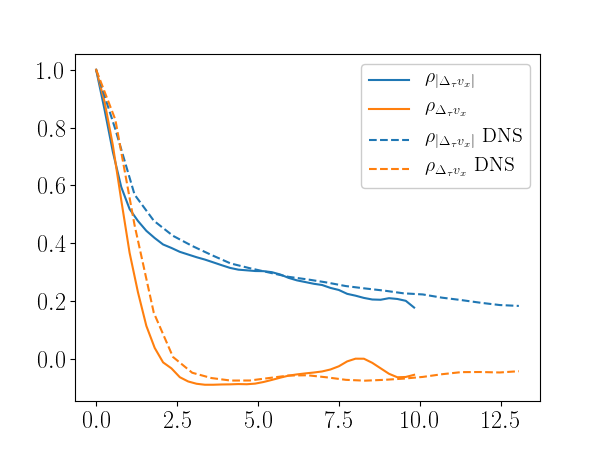

In [168]:
fig, ax = plt.subplots()

tm = np.arange(len(R_dV))/FPS/t_eta
ax.plot(tm, R_dV, '-', color = colors[0], label = r'$\rho_{|\Delta_\tau v_x|}$')
ax.plot(tm, R_dvx, '-', color = colors[1], label = r'$\rho_{\Delta_\tau v_x}$')


tm = np.arange(len(R_dV_jhu))/FPS_jhu/t_eta_jhu
ax.plot(tm, R_dV_jhu, '--', color = colors[0], label = r'$\rho_{|\Delta_\tau v_x|}$ DNS')
ax.plot(tm, R_dvx_jhu, '--', color = colors[1], label = r'$\rho_{\Delta_\tau v_x}$ DNS')

ax.legend()

In [263]:
a_lst = []
for tr in t[:30000]:
    if len(tr)<4:continue
    a = []
    v = tr.velocity() - V
    for i in range(len(tr)-2):
        a.append( get_angle(v[i+2,:], v[i,:]) )
    
    a_lst.append(a[:40])
    
R_a, S, N = list_corelation(a_lst)




a_lst_jhu = []

for tr in t_jhu[:]:
    
    for r0,rn in [(5,26), (30,51), (80,101)]:
        a = []
        for i in range(r0,rn):
            a.append(get_angle(tr.velocity()[i+1,:], tr.velocity()[i,:]))
    
        if np.isnan(a[:]).any(): continue
        a_lst_jhu.append( a[:] )
    
R_a_jhu, S, N = list_corelation(a_lst_jhu)

/home/ron/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in arccos
  


<IPython.core.display.Javascript object>


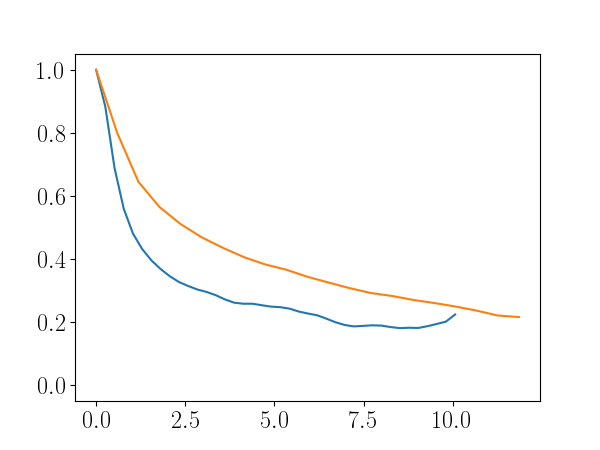

(-0.05, 1.05)

In [265]:
fig, ax = plt.subplots()

tm = np.arange(len(R_a))/FPS/t_eta
ax.plot(tm, R_a, '-', color = colors[0])


tm = np.arange(len(R_a_jhu))/FPS_jhu/t_eta_jhu
ax.plot(tm, R_a_jhu, '-', color = colors[1])

ax.set_ylim([-.05,1.05])

In [266]:
a1_lst = []

for tr in t[:30000]:
    
    if len(tr)<6:continue
    dv = tr.velocity()[2:,:] - tr.velocity()[:-2,:]
    for i in range(len(dv)-2):
        a = get_angle(dv[i+2,:], dv[i,:])
        if np.isnan(a):
            break
        a1_lst.append( a )
        
        
        
        
a1_lst_jhu = []

for tr in t_jhu[:]:
    
    dv = tr.velocity()[1:,:] - tr.velocity()[:-1,:]
    for i in range(len(dv)-1):
        a = get_angle(dv[i+1,:], dv[i,:])
        if np.isnan(a):
            break
        a1_lst_jhu.append( a )

In [267]:
np.std(a1_lst), np.std(a1_lst_jhu) 

(0.5810428631476935, 0.529163)

#### Flight Crash events?

<IPython.core.display.Javascript object>


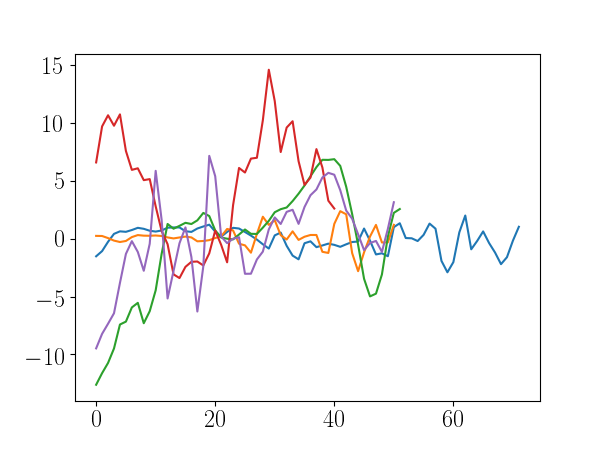

In [69]:
def get_E(tr, V = 0):
    '''
    returns the kinetic energy of a trajectory
    '''
    return np.sum( (tr.velocity() - V)**2, axis = 1)


fig, ax = plt.subplots()

c = 0
for tr in t:
    if len(tr)>40:
        ax.plot( np.gradient(get_E(tr, V=V))*FPS )
        c+=1
    if c>=5:
        break

<IPython.core.display.Javascript object>


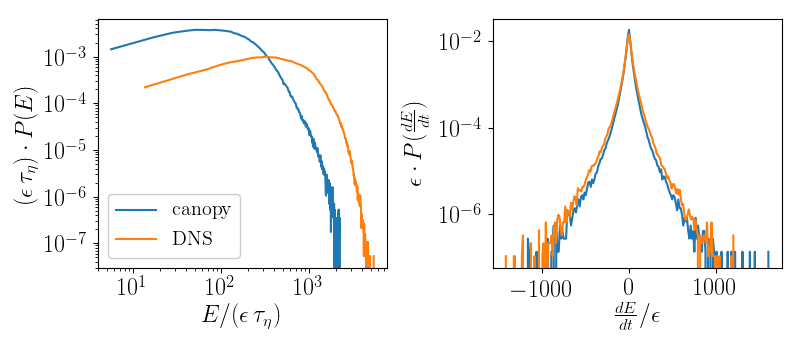

511549
1208000


In [53]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(8,3.5)




E_lst, dEdt_lst = [],  []
for tr in t:
    if len(tr)<3: continue
    E = get_E(tr, V=V)
    for e_ in E:
        E_lst.append(e_)
    for e_ in np.gradient(E)*FPS:
        dEdt_lst.append(e_)


print len(E_lst)

x,y = hist_lines(E_lst, 200)
s = eps * t_eta
ax[0].loglog(x/s, y*s, label = 'canopy')

x,y = hist_lines(dEdt_lst, 200)
s = eps
ax[1].semilogy(x/s, y*s, label = 'canopy')





E_lst_jhu, dEdt_lst_jhu = [],  []
for tr in t_jhu:
    E = get_E(tr)
    for e_ in E:
        E_lst_jhu.append(e_)
    for e_ in np.gradient(E)*FPS_jhu:
        dEdt_lst_jhu.append(e_)

print len(E_lst_jhu)

x,y = hist_lines(E_lst_jhu[:700000], 200)
s = eps * t_eta
ax[0].loglog(x/s, y*s, label = 'DNS')

x,y = hist_lines(dEdt_lst_jhu[:700000], 200)
s = eps_jhu
ax[1].semilogy(x/s, y*s, label = 'DNS')




ax[0].set_xlabel( r'$ E / (\epsilon \, \tau_\eta) $' )
ax[0].set_ylabel( r'$  (\epsilon \, \tau_\eta) \cdot P(E) $' )
ax[1].set_xlabel( r'$ \frac{dE}{dt} / \epsilon $' )
ax[1].set_ylabel( r'$  \epsilon  \cdot P(\frac{dE}{dt}) $' )


ax[0].legend()
plt.tight_layout()







In [54]:
E_jhu = np.mean(dEdt_lst_jhu)
E = np.mean(dEdt_lst)

S_jhu = np.std(dEdt_lst_jhu) 
S = np.std(dEdt_lst)

Sk_jhu = np.mean((np.array(dEdt_lst_jhu) - E_jhu)**3) / np.std(dEdt_lst_jhu)**3
Sk = np.mean((np.array(dEdt_lst) - E)**3) / np.std(dEdt_lst)**3


print 'mean dEdt: %.3f, %.3f'%(E_jhu/eps_jhu, E/eps)
print 'std dEdt:  %.3f, %.3f'%(S_jhu / eps_jhu,  S / eps) 
print 'SKew dEdt: %.3f, %.3f'%(Sk_jhu,  Sk)

mean dEdt: -0.180, -2.703
std dEdt:  71.705, 56.291
SKew dEdt: -0.294, -0.003


<IPython.core.display.Javascript object>


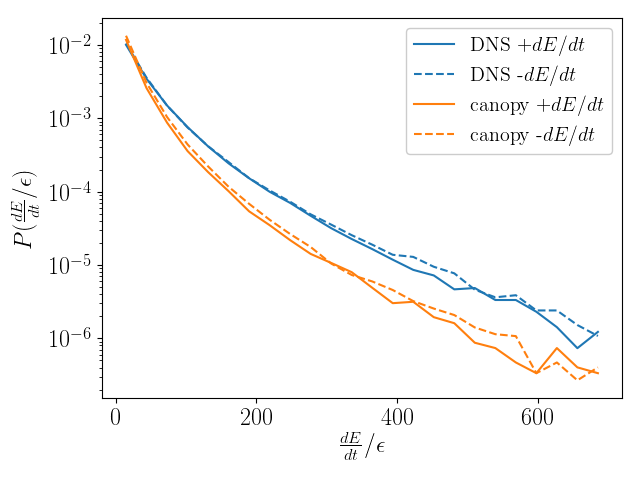

In [104]:
fig, ax = plt.subplots()

a = np.linspace(0,700,num=25)
bins = np.append(a[::-1]*-1, a[1:]) #np.linspace(-700,700,num=51)


x,y = hist_lines( np.array(dEdt_lst_jhu[:700000])/eps_jhu , bins)
s = eps_jhu

x_pos = x[np.where(x>0)]
y_pos = y[np.where(x>0)]
ax.semilogy(x_pos, y_pos, color = colors[0], label = 'DNS +$dE/dt$')

x_neg = x[np.where(x<0)][::-1]
y_neg = y[np.where(x<0)][::-1]
ax.semilogy(-1*x_neg, y_neg, '--', color = colors[0], label = 'DNS -$dE/dt$')

#ax.fill_between(x_pos, y1 = y_pos, y2= y_neg, alpha = .25, color = 'r')


x,y = hist_lines( np.array(dEdt_lst[:700000])/eps, bins)
s = eps

x_pos = x[np.where(x>0)]
y_pos = y[np.where(x>0)]
ax.semilogy(x_pos, y_pos, color = colors[1], label = 'canopy +$dE/dt$')

x_neg = x[np.where(x<0)][::-1]
y_neg = y[np.where(x<0)][::-1]
ax.semilogy(-1*x_neg, y_neg, '--', color = colors[1], label = 'canopy -$dE/dt$')

#whr = np.where(y_pos > y_neg)
#ax.fill_between(x_pos[whr], y1 = y_pos[whr], y2= y_neg[whr], alpha = .25, color = 'g')

ax.legend()
ax.set_xlabel(r'$ \frac{dE}{dt} / \epsilon$')
ax.set_ylabel(r'$ P(\frac{dE}{dt} / \epsilon)$')

plt.tight_layout()

In [109]:
M = np.trapz(x*y, x)
S = np.trapz( (x-M)**2 * y, x)
np.trapz( (x-M)**3 * y, x) / S**(3.0/2.0)

-0.1574786172447463

<IPython.core.display.Javascript object>


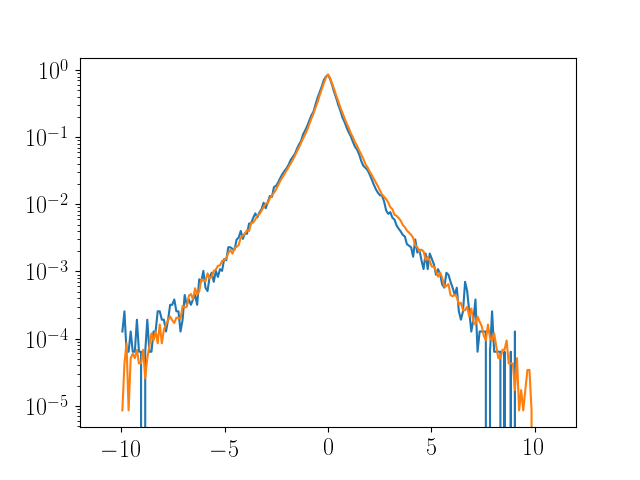

(-12, 12)

In [63]:
W1_lst = []

for tr in t[:]:
    
    if len(tr)<11: continue
    
    E = get_E(tr, V=V)
    
    for w in E[10:]-E[:-10]:
        W1_lst.append(w)
        
        
        
     
        
W1_lst_jhu = []

for tr in t_jhu[:]:
    
    E = get_E(tr)
    
    for w in E[5:]-E[:-5]:
        W1_lst_jhu.append(w)
        
    
    
    
#print 'Sk: %.3f, %.3f'%(get_Sk(W1_lst), get_Sk(W1_lst_jhu))

bins = np.linspace(-10, 10, num=200)   
fig, ax = plt.subplots()

s = np.std(W1_lst)
x,y = hist_lines( np.array(W1_lst)/s , bins)
ax.semilogy(x, y)

s = np.std(W1_lst_jhu)
x,y = hist_lines( np.array(W1_lst_jhu)/s, bins)
ax.semilogy(x, y)

ax.set_xlim([-12,12])

In [64]:
indexes = np.arange(1,25)
W_i_lst = [[] for i in indexes]

for tr in t[:]:
    
    E = get_E(tr, V=V)
    
    for j,i in enumerate(indexes):
        for w in E[i:]-E[:-i]:
            W_i_lst[j].append(w)



   
indexes_jhu = np.arange(1,14)
W_i_lst_jhu = [[] for i in indexes_jhu]

for tr in t_jhu[:]:
    
    E = get_E(tr)
    
    for j,i in enumerate(indexes_jhu):
        for w in E[i:]-E[:-i]:
            W_i_lst_jhu[j].append(w)
        

<IPython.core.display.Javascript object>


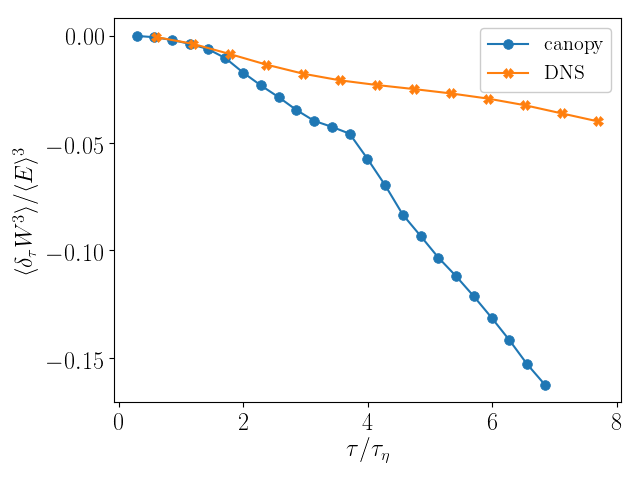

In [65]:
E = np.mean(E_lst)
E_jhu = np.mean(E_lst_jhu)


W3 = np.array([np.mean( np.array(L)**3 )/E**3 for L in W_i_lst])
tm = indexes / FPS / t_eta

W3_jhu = np.array([np.mean( np.array(L)**3 )/E_jhu**3 for L in W_i_lst_jhu])
tm_jhu = indexes_jhu / FPS_jhu / t_eta_jhu



fig, ax = plt.subplots()
ax.plot(tm, W3, 'o-', label = 'canopy')
ax.plot(tm_jhu, W3_jhu, '-X', label = 'DNS')

ax.set_xlabel( r'$\tau / \tau_\eta$' )
ax.set_ylabel( r'$ \langle \delta_\tau W^3  \rangle / \langle E \rangle^3 $' )

plt.tight_layout()
ax.legend()

### save 3rd moments of $\delta_\tau E = E(t+\tau)-E(t)$ by subvolume:

In [66]:
indexes = np.arange(1,25)


for A in ['a','b','c','d']:
    for B in ['1','2','3','4','5']:

        sv = A+B
        
        t_ = get_traj_list( os.path.join(dirname, '%s_%.1f.h5'%(sv, 2.5)) )
        V_ = get_mean_velocity(t_)
        
        
        # get E increments:
        W_i_lst = [[] for i in indexes]
        E_lst = []
        for tr in t_[:]:
    
            E = get_E(tr, V=V_)
            for j,i in enumerate(indexes):
                for w in E[i:]-E[:-i]:
                    W_i_lst[j].append(w)
                
            for e in E:
                E_lst.append(e)
        
        E = np.mean(E_lst)
        W3 = np.array([np.mean( np.array(L)**3 )/E**3 for L in W_i_lst])
        N =  np.array([len(sblst) for sblst in W_i_lst])
        
        fname = os.path.join('W3_data', 'W3_%s_25.npz'%(sv))
        np.savez(fname, E=E, W3 = W3, N=N)

<IPython.core.display.Javascript object>


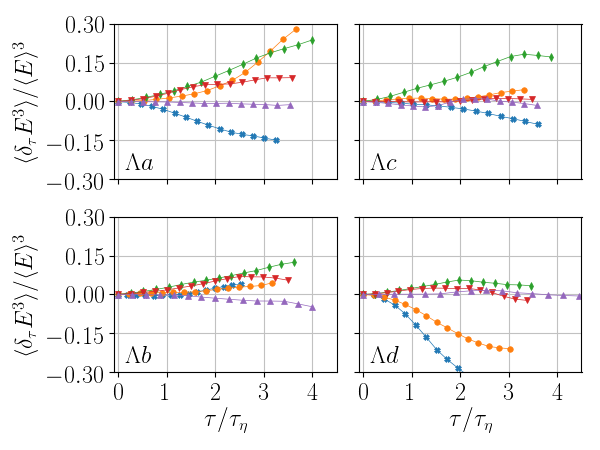

In [70]:
fig, ax_ = plt.subplots(2,2, sharey = True)

fig.set_size_inches(6,4.5)

ax = [ax_[0,0],ax_[1,0], ax_[0,1], ax_[1,1]]

e = 0
for A in ['a','b','c','d']:
    for B in ['1','2','3','4','5']:
        
        h = int(B) - 1
        sv = A+B
        fname = os.path.join('W3_data', 'W3_%s_25.npz'%(sv))
        data = np.load(fname)
        W3 = data['W3'][:15]
        
        eps = get_eps(sv, 2.5)
        tm = np.arange(len(W3)) / FPS / (nu / eps)**0.5
        ax[e].plot(tm, W3  , '-'+shapes[h], ms=4 , lw=.5, color = colors[h])
    
    ax[e].set_xticks([0,1,2,3,4])
    ax[e].set_xlim([-0.1 , 4.5])
    ax[e].text( 0.05 , 0.05, r'$\Lambda %s$'%A, fontsize=18, transform=ax[e].transAxes)
    ax[e].grid()
    e+=1
    
ax[1].set_xlabel(r'$\tau / \tau_\eta$') 
ax[3].set_xlabel(r'$\tau / \tau_\eta$')
ax[0].set_xticklabels([])
ax[2].set_xticklabels([])
ax[0].set_yticks([-.3,-.15,0,.15,.3])
ax[0].set_ylim([-.3, .3])
ax[0].set_ylabel(r'$ \langle \delta_\tau E^3 \rangle / \langle E \rangle^3$')
ax[1].set_ylabel(r'$ \langle \delta_\tau E^3 \rangle / \langle E \rangle^3$')
plt.tight_layout()

### Save skewness of $dE / dt$ by subvolume:

In [305]:
E_lst = []
S_lst = []
Sk_lst = []
N_lst = []
sv_lst = []

for A in ['a','b','c','d']:
    for B in ['1','2','3','4','5']:

        sv = A+B
        t_ = get_traj_list( os.path.join(dirname, '%s_%.1f.h5'%(sv, 4.0)) )
        eps_ = get_eps(sv, 4.0)
        V_ = get_mean_velocity(t_)
    
        dEdt_lst_ = []
        for tr in t_:
            if len(tr)<3: continue
            E = get_E(tr, V=V_)
            for e_ in np.gradient(E)*FPS:
                dEdt_lst_.append(e_)
            
        E_ = np.mean(dEdt_lst_)
        S_ = np.std(dEdt_lst_)
        Sk_ = np.mean((np.array(dEdt_lst_) - E_)**3) / S_**3
        
        E_lst.append(E_)
        S_lst.append(S_)
        Sk_lst.append(Sk_)
        N_lst.append(len(dEdt_lst_))
        sv_lst.append(sv)
    
np.savez('P_moments_40.npz', subvol = sv_lst, Skew = Sk_lst, sigma = S_lst, E = E_lst, N = N_lst)

<IPython.core.display.Javascript object>


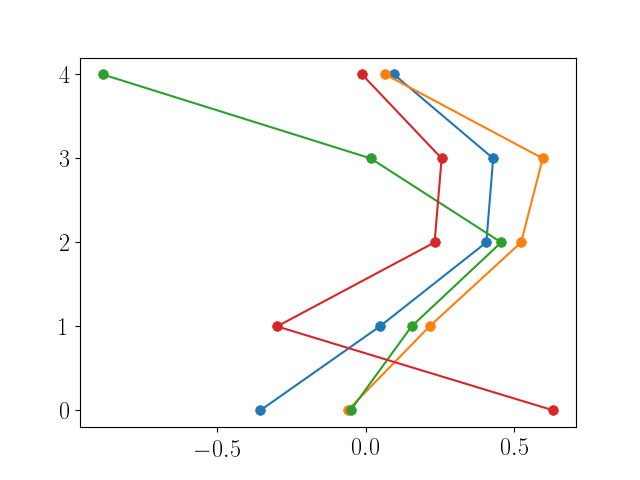

In [112]:
data = np.load('P_moments_25.npz')

fig, ax = plt.subplots()

Sk =  data['Skew']
ax.plot(Sk[:5], range(5), 'o-')
ax.plot(Sk[5:10], range(5), 'o-')
ax.plot(Sk[10:15], range(5), 'o-')
ax.plot(Sk[15:20], range(5), 'o-')



<IPython.core.display.Javascript object>


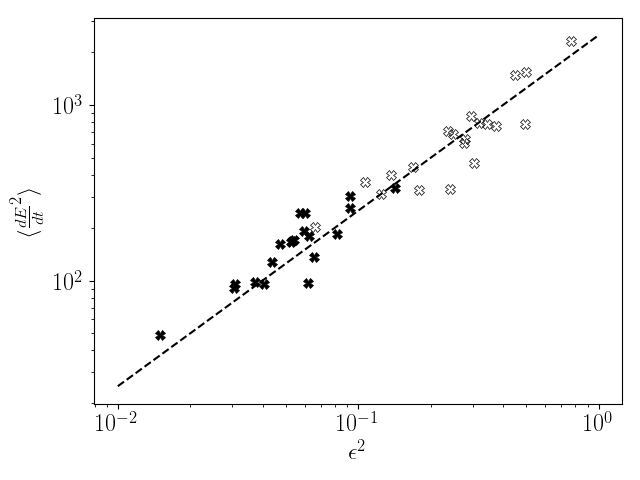

R2 = 0.018


In [118]:
fig, ax = plt.subplots()
R2 = []
data = np.load('P_moments_25.npz')
for e,sv in enumerate(data['subvol']):
    eps = get_eps(sv, 2.5)
    sig = data['sigma'][e]
    
    r = (eps/0.02 - sig)**2 / sig**2
    R2.append(r)
    
    ax.loglog([eps**2], [sig**2], 'kX')

    
data = np.load('P_moments_40.npz')
for e,sv in enumerate(data['subvol']):
    eps = get_eps(sv, 4.0)
    sig = data['sigma'][e]
    
    r = (eps/0.02 - sig)**2 / sig**2
    R2.append(r)
    
    ax.loglog([eps**2], [sig**2], 'kX', fillstyle = 'none')
    
    
print 'R2 = %.3f'%(np.mean(R2))
x = np.linspace(0.01,0.99)
ax.loglog(x, x*2500, 'k--')

#ax.set_xlim([0,0.5])
#ax.set_ylim([0, 25])

ax.set_xlabel(r'$\epsilon^2$')
ax.set_ylabel(r'$\langle \frac{dE}{dt}^2 \rangle$')

plt.tight_layout()
fig.savefig('eps_dEdt.pdf')

## Categorizing by "descending" and "ascending" particles:

In [7]:
def asc_dsc_dz(tr, thrshld):
    '''
    returns 1 if particle is ascending : z[-1] - z[0]  >  threshold
    returns -1 if particle is ascending : z[-1] - z[0] < -threshold
    returns 0 else
    
    if threshold is not given, the standard deviation of 
    translations is taken automatically
    '''
    
    dz = tr.pos()[-1,1] - tr.pos()[0,1] 
    if dz > thrshld: return 1
    elif dz < thrshld*-1: return -1
    else: return 0


def get_threshold(traj_list):
    z_lst = []
    for tr in traj_list:
        if len(tr)<3:
            continue
        z_lst.append(tr.pos()[0,1])
        z_lst.append(tr.pos()[-1,1])

    return np.std(z_lst)


th = get_threshold(t)
    
t_asc = filter(lambda tr: asc_dsc_dz(tr, th)== 1, t)
t_dsc = filter(lambda tr: asc_dsc_dz(tr, th)==-1, t)

print len(t_asc), len(t_dsc)

12414 2381


2927 1364


<IPython.core.display.Javascript object>


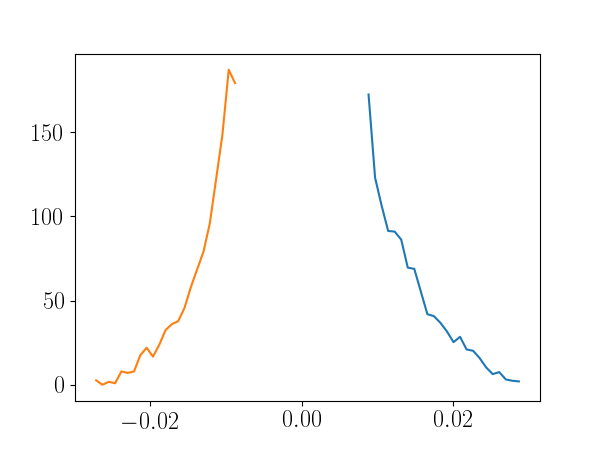

In [76]:

fig, ax = plt.subplots()

dz = [tr.pos()[-1,1] - tr.pos()[0,1] for tr in t_asc]
x,y = hist_lines(dz,'auto')
ax.plot(x,y)


dz = [tr.pos()[-1,1] - tr.pos()[0,1] for tr in t_dsc]
x,y = hist_lines(dz,'auto')
ax.plot(x,y)

##### Skewness of $a_x$:

<IPython.core.display.Javascript object>


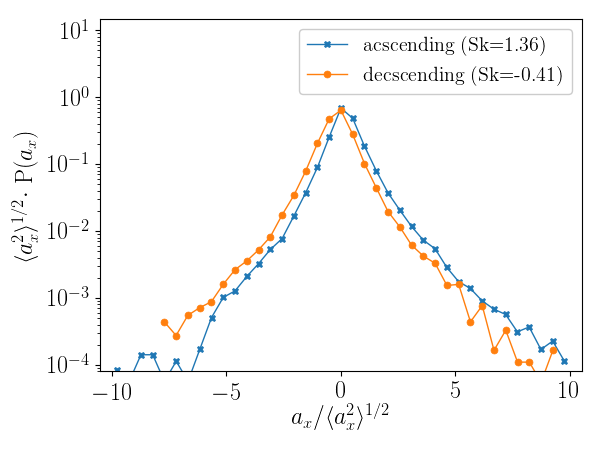

In [67]:
ax_asc = []
ax_dsc = []

for tr in t_asc:
    for i in range(len(tr)):
        ax_asc.append( tr.accel()[i, 0]*-1 )

for tr in t_dsc:
    for i in range(len(tr)):
        ax_dsc.append(tr.accel()[i, 0]*-1 )

        
fig, ax = plt.subplots()
S = np.std(ax_asc)
bins = np.linspace(-10*S,10*S,num=40)

x,y = hist_lines(ax_asc, bins)

M = np.trapz( x*y, x )
S = np.trapz( (x-M)**2 * y, x )**0.5
Sk = np.trapz( (x)**3 * y, x ) / S**(3.0)

ax.semilogy(x/S, y*S, '-'+shapes[0], lw=1, ms=5, color = colors[0], label = 'acscending (Sk=%.2f)'%(Sk))



S = np.std(ax_dsc)
bins = np.linspace(-10*S,10*S,num=40)

x,y = hist_lines(ax_dsc[:], bins)

M = np.trapz( x*y, x )
S = np.trapz( (x-M)**2 * y, x )**0.5
Sk = np.trapz( (x)**3 * y, x ) / S**(3.0)

ax.semilogy(x/S, y*S, '-'+shapes[1], lw=1, ms=5, color = colors[1], label = 'decscending (Sk=%.2f)'%(Sk))



ax.legend(loc=1)
ax.set_ylim(.8e-4, 1.5e1)
ax.set_xlim(-10.5, 10.5)

ax.set_xlabel(r'$a_x / \langle a_x^2 \rangle^{1/2}$')
ax.set_ylabel(r'$\langle a_x^2 \rangle^{1/2} \cdot$ P($a_x$)')

plt.tight_layout()

<IPython.core.display.Javascript object>


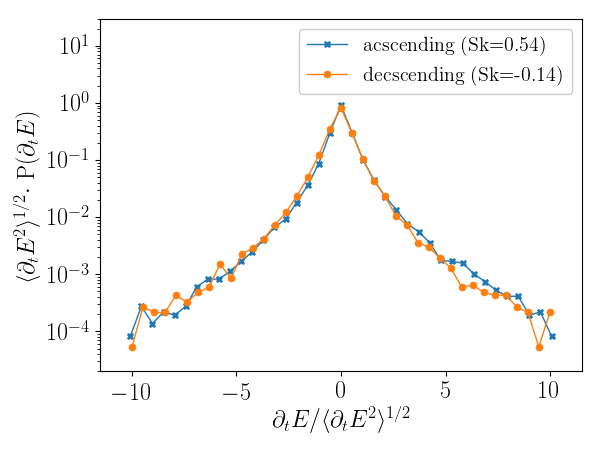

In [71]:
ax_asc = []
ax_dsc = []

for tr in t_asc:
    dEdt =  np.gradient(get_E(tr, V=V)) * FPS
    for i in range(len(tr)):
        ax_asc.append( dEdt[i] )

        
for tr in t_dsc:
    dEdt =  np.gradient(get_E(tr, V=V)) * FPS
    for i in range(len(tr)):
        ax_dsc.append( dEdt[i] )

        
fig, ax = plt.subplots()

S = np.std(ax_asc)
bins = np.linspace(-10*S,10*S,num=40)
x,y = hist_lines(ax_asc[:], bins)

M = np.trapz( x*y, x )
S = np.trapz( (x-M)**2 * y, x )**0.5
Sk = np.trapz( (x)**3 * y, x ) / S**(3.0)

ax.semilogy(x/S, y*S, '-'+shapes[0], lw=1, ms=5, color = colors[0], label = 'acscending (Sk=%.2f)'%(Sk))



S = np.std(ax_dsc)
bins = np.linspace(-10*S,10*S,num=40)
x,y = hist_lines(ax_dsc[:], bins)

M = np.trapz( x*y, x )
S = np.trapz( (x-M)**2 * y, x )**0.5
Sk = np.trapz( (x)**3 * y, x ) / S**(3.0)

ax.semilogy(x/S, y*S, '-'+shapes[1], lw=1, ms=5, color = colors[1], label = 'decscending (Sk=%.2f)'%(Sk))



ax.legend(loc=1)
ax.set_ylim(.2e-4, 3e1)
ax.set_xlim(-11.5, 11.5)

ax.set_xlabel(r'$\partial_t E / \langle \partial_t E^2 \rangle^{1/2}$')
ax.set_ylabel(r'$\langle \partial_t E^2 \rangle^{1/2} \cdot$ P($\partial_t E$)')

plt.tight_layout()

#### Save PDFs of $a_x$ by ascending  and descending:

In [79]:

for A in ['a','b','c','d']:
    for B in ['1','2','3','4','5']:

        sv = A+B
        
        t_ = get_traj_list( os.path.join(dirname, '%s_%.1f.h5'%(sv, 4.0)) )
        V_ = get_mean_velocity(t_)
        
        th = get_threshold(t_)
        

        ax_asc = []
        ax_dsc = []
        N_asc, N_dsc = 0, 0
        
        for tr in t_:
            if len(tr)<3: continue
            ascdsc = asc_dsc_dz(tr, th)
            
            if ascdsc == 1:
                for i in range(len(tr)):
                    ax_asc.append( tr.accel()[i, 0]*-1 )
                    N_asc += 1

            elif ascdsc == -1:
                for i in range(len(tr)):
                    ax_dsc.append( tr.accel()[i, 0]*-1 )
                    N_dsc += 1
                    
            
            
        S = np.std(ax_asc)
        bins = np.linspace(-10*S, 10*S,num=40)
        x_asc,y_asc = hist_lines(ax_asc, bins)

        
        S = np.std(ax_dsc)
        bins = np.linspace(-10*S, 10*S,num=40)
        x_dsc,y_dsc = hist_lines(ax_dsc, bins)

        
        fname = os.path.join('ax_asc_dsc_PDF', 'ax_pdf_%s_40.npz'%sv)
        np.savez(fname, N_asc=N_asc, N_dsc=N_dsc, 
                pdf_x_asc=x_asc, pdf_y_asc=y_asc, pdf_x_dsc=x_dsc, pdf_y_dsc=y_dsc)
        

<IPython.core.display.Javascript object>


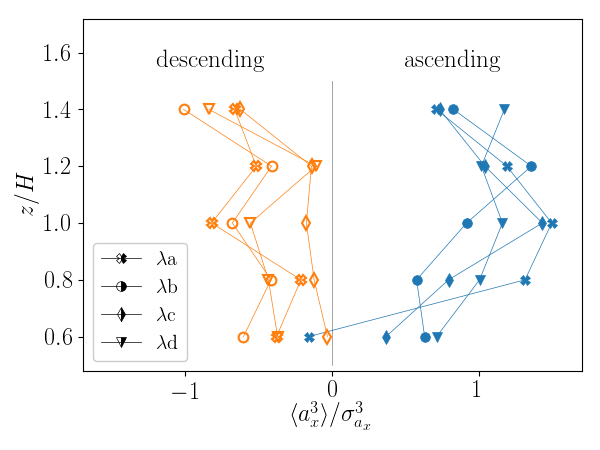

In [4]:
fig, ax = plt.subplots()


z_lst = [0.6,0.8,1.0,1.2, 1.4]

e = 0
for A in ['a','b','c','d']:
    Sk_asc = []
    Sk_dsc = []
    for B in ['1','2','3','4','5']:

        sv = A+B
        fname = os.path.join('ax_asc_dsc_PDF', 'ax_pdf_%s_25.npz'%sv)
        data = np.load(fname)
        
        x, y = data['pdf_x_asc'], data['pdf_y_asc']
        M,S = get_M_S(x,y)
        Sk = np.trapz(y * (x)**3,x)/S**(3.0)
        if np.isnan(Sk):
            Sk_asc.append(0)
        else:
            Sk_asc.append(Sk)
        
        x, y = data['pdf_x_dsc'], data['pdf_y_dsc']
        M,S = get_M_S(x,y)
        Sk = np.trapz(y * (x)**3,x)/S**(3.0)
        if np.isnan(Sk):
            Sk_dsc.append(0)
        else:
            Sk_dsc.append(Sk)

    ax.plot(Sk_asc, z_lst, shapes[e]+'-', lw=.5, color = colors[0])
    ax.plot(Sk_dsc, z_lst, shapes[e]+'-', lw=.5, color = colors[1], fillstyle='none', mew=1.5)
    e+=1
    
    
    
for e,hloc in enumerate(['a','b','c','d']):
    ax.plot([],[],'k-'+shapes[e],lw = 0.5, fillstyle = 'right', label = r'$\lambda$'+hloc)
ax.legend(loc=3)

ax.text(0.5 , 1.55, 'ascending', fontsize = 18)
ax.text(-1.2 , 1.55, 'descending', fontsize = 18)
    
#ax.grid()
ax.plot([0,0], [0.5, 1.5], 'k-', lw=0.5,alpha=0.5)
ax.set_xlim([-1.7,1.7])
ax.set_ylim([0.48,1.72])
ax.set_xlabel(r'$ \langle  a_x^3 \rangle / \sigma_{a_x}^3 $')
ax.set_ylabel(r'$ z / H $')
plt.tight_layout()

#fig.savefig('asc_dsc_ax_Sk.pdf')

<IPython.core.display.Javascript object>


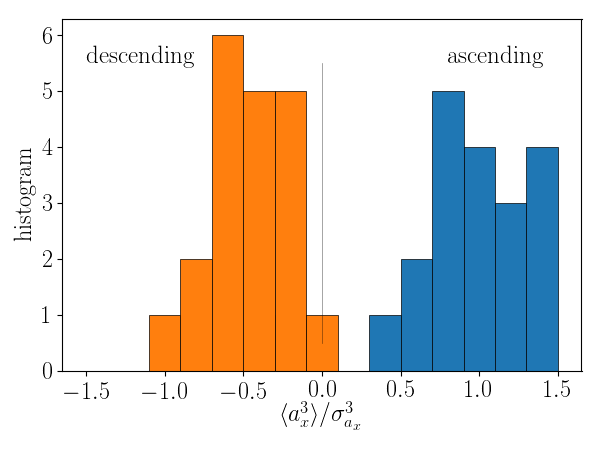

In [29]:
fig, ax = plt.subplots()


z_lst = [0.6,0.8,1.0,1.2, 1.4]

e = 0
Sk_asc = []
Sk_dsc = []
for A in ['a','b','c','d']:
    for B in ['1','2','3','4','5']:

        sv = A+B
        fname = os.path.join('ax_asc_dsc_PDF', 'ax_pdf_%s_25.npz'%sv)
        data = np.load(fname)
        
        x, y = data['pdf_x_asc'], data['pdf_y_asc']
        M,S = get_M_S(x,y)
        Sk = np.trapz(y * (x)**3,x)/S**(3.0)
        if np.isnan(Sk):
            #Sk_asc.append(0)
            pass
        else:
            Sk_asc.append(Sk)
        
        x, y = data['pdf_x_dsc'], data['pdf_y_dsc']
        M,S = get_M_S(x,y)
        Sk = np.trapz(y * (x)**3,x)/S**(3.0)
        if np.isnan(Sk):
            pass
            #Sk_dsc.append(0)
        else:
            Sk_dsc.append(Sk)
    e+=1
    
ax.hist(Sk_asc, bins=np.linspace(-1.5,1.5,16), edgecolor='black', linewidth=0.5)
ax.hist(Sk_dsc, bins=np.linspace(-1.5,1.5,16), edgecolor='black', linewidth=0.5,)
ax.plot([0,0], [0.5, 5.5], 'k-', lw=0.5,alpha=0.5)

ax.set_xticks([-1.5,-1,-0.5,0,.5,1,1.5])
ax.set_xlabel(r'$ \langle  a_x^3 \rangle / \sigma_{a_x}^3 $')
ax.set_ylabel('histogram')

ax.text(0.8 , 5.5, 'ascending', fontsize = 18)
ax.text(-1.5 , 5.5, 'descending', fontsize = 18)

plt.tight_layout()
fig.savefig('asc_dsc_ax_Sk_hist.pdf')

#### Save PDFs of $dE/dt$ by ascending and descending:

In [85]:

for A in ['a','b','c','d']:
    for B in ['1','2','3','4','5']:
        for U_ in [2.5,4.0]:

            sv = A+B
        
            t_ = get_traj_list( os.path.join(dirname, '%s_%.1f.h5'%(sv, U_)) )
            V_ = get_mean_velocity(t_)
        
            th = get_threshold(t_)
        

            dEdt_asc = []
            dEdt_dsc = []
            N_asc, N_dsc = 0, 0
        
            for tr in t_:
                if len(tr)<3: continue
                ascdsc = asc_dsc_dz(tr, th)
                dEdt =  np.gradient( get_E(tr, V=V_) ) * FPS
            
                if ascdsc == 1:
                    for i in range(len(tr)):
                        dEdt_asc.append( dEdt[i] )
                    N_asc += 1

                elif ascdsc == -1:
                    for i in range(len(tr)):
                        dEdt_dsc.append( dEdt[i] )
                    N_dsc += 1
                    
            
            
            S = np.std(dEdt_asc)
            bins = np.linspace(-10*S, 10*S,num=40)
            x_asc,y_asc = hist_lines(dEdt_asc, bins)

        
            S = np.std(dEdt_dsc)
            bins = np.linspace(-10*S, 10*S,num=40)
            x_dsc,y_dsc = hist_lines(dEdt_dsc, bins)

        
            fname = os.path.join('dEdt_asc_dsc_PDF', 'dEdt_pdf_%s_%d.npz'%(sv, U_*10))
            np.savez(fname, N_asc=N_asc, N_dsc=N_dsc, 
                    pdf_x_asc=x_asc, pdf_y_asc=y_asc, pdf_x_dsc=x_dsc, pdf_y_dsc=y_dsc)


<IPython.core.display.Javascript object>


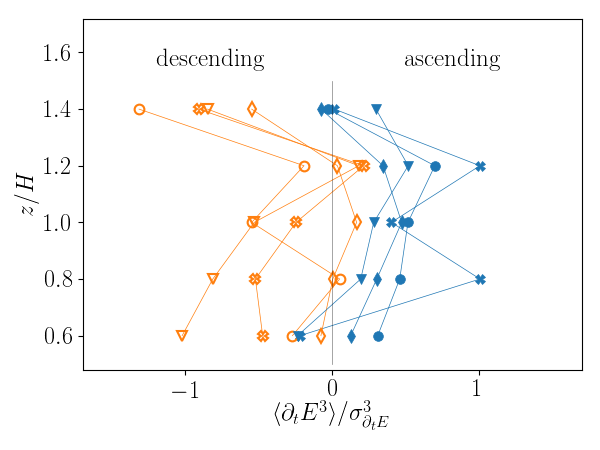

In [5]:
fig, ax = plt.subplots()


z_lst = [0.6,0.8,1.0,1.2, 1.4]

e = 0
for A in ['a','b','c','d']:
    Sk_asc = []
    Sk_dsc = []
    for B in ['1','2','3','4','5']:

        sv = A+B
        fname = os.path.join('dEdt_asc_dsc_PDF', 'dEdt_pdf_%s_25.npz'%sv)
        data = np.load(fname)
        
        x, y = data['pdf_x_asc'], data['pdf_y_asc']
        M,S = get_M_S(x,y)
        Sk = np.trapz(y * (x)**3,x)/S**(3.0)
        if np.isnan(Sk):
            Sk_asc.append(0)
        else:
            Sk_asc.append(Sk)
        
        x, y = data['pdf_x_dsc'], data['pdf_y_dsc']
        M,S = get_M_S(x,y)
        Sk = np.trapz(y * (x)**3,x)/S**(3.0)
        if np.isnan(Sk):
            Sk_dsc.append(0)
        else:
            Sk_dsc.append(Sk)

    ax.plot(Sk_asc, z_lst, shapes[e]+'-', lw=.5, color = colors[0])
    ax.plot(Sk_dsc, z_lst, shapes[e]+'-', lw=.5, color = colors[1], fillstyle='none', mew=1.5)
    e+=1
    
    
    
#for e,hloc in enumerate(['a','b','c','d']):
#    ax.plot([],[],'k-'+shapes[e],lw = 0.5, fillstyle = 'right', label = r'$\lambda$'+hloc)
#ax.legend(loc=3)

ax.text(0.5 , 1.55, 'ascending', fontsize = 18)
ax.text(-1.2 , 1.55, 'descending', fontsize = 18)
    
#ax.grid()
ax.plot([0,0], [0.5, 1.5], 'k-', lw=0.5,alpha=0.5)
ax.set_xlim([-1.7,1.7])
ax.set_ylim([0.48,1.72])
ax.set_xlabel(r'$ \langle  \partial_t E^3 \rangle / \sigma_{\partial_t E}^3 $')
ax.set_ylabel(r'$ z / H $')
plt.tight_layout()

#fig.savefig('asc_dsc_dEdt_Sk.pdf')

<IPython.core.display.Javascript object>


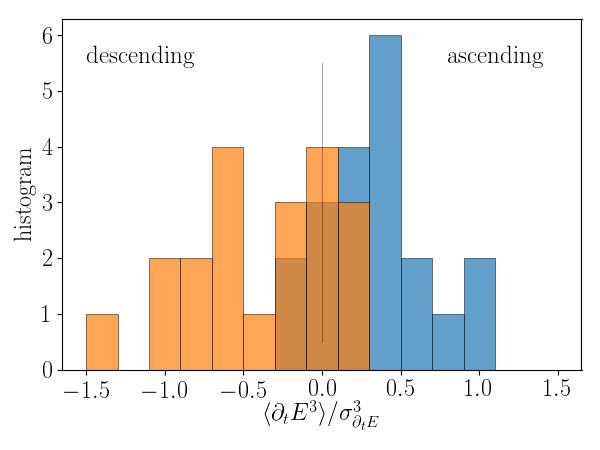

In [6]:
fig, ax = plt.subplots()


z_lst = [0.6,0.8,1.0,1.2, 1.4]

e = 0
Sk_asc = []
Sk_dsc = []
for A in ['a','b','c','d']:

    for B in ['1','2','3','4','5']:

        sv = A+B
        fname = os.path.join('dEdt_asc_dsc_PDF', 'dEdt_pdf_%s_25.npz'%sv)
        data = np.load(fname)
        
        x, y = data['pdf_x_asc'], data['pdf_y_asc']
        M,S = get_M_S(x,y)
        Sk = np.trapz(y * (x)**3,x)/S**(3.0)
        if np.isnan(Sk):
            pass
            #Sk_asc.append(0)
        else:
            Sk_asc.append(Sk)
        
        x, y = data['pdf_x_dsc'], data['pdf_y_dsc']
        M,S = get_M_S(x,y)
        Sk = np.trapz(y * (x)**3,x)/S**(3.0)
        if np.isnan(Sk):
            pass
            #Sk_dsc.append(0)
        else:
            Sk_dsc.append(Sk)

    e+=1
    
data = [Sk_asc,Sk_dsc]
    
#ax.hist(data, bins=np.linspace(-1.5,1.5,16), edgecolor='black', linewidth=0.5)
    
ax.hist(Sk_asc, bins=np.linspace(-1.5,1.5,16), edgecolor='black', linewidth=0.5, alpha=.7)
ax.hist(Sk_dsc, bins=np.linspace(-1.5,1.5,16), edgecolor='black', linewidth=0.5, alpha=.7)
ax.plot([0,0], [0.5, 5.5], 'k-', lw=0.5,alpha=0.5)

ax.set_xticks([-1.5,-1,-0.5,0,.5,1,1.5])
ax.set_xlabel(r'$\langle  \partial_t E^3 \rangle / \sigma_{\partial_t E}^3 $')
ax.set_ylabel('histogram')

ax.text(0.8 , 5.5, 'ascending', fontsize = 18)
ax.text(-1.5 , 5.5, 'descending', fontsize = 18)

plt.tight_layout()

fig.savefig('asc_dsc_dEdt_Sk_hist.pdf')

##### velocity corelations of $v_x$ for ascending / descending:

In [9]:
vx_asc, vx_dsc, vx_ = [], [] ,[]

threshold = get_threshold(t)

for tr in t:
    
    
    state = asc_dsc_dz(tr, threshold)
    
    if state == 1:
        vx_asc.append(tr.velocity()[:,0])
        
    elif state == -1:
        vx_dsc.append(tr.velocity()[:,0])
        
    elif state == 0:
        vx_.append(tr.velocity()[:,0])
    

R_asc, S, N = list_corelation(vx_asc)
R_dsc, S, N = list_corelation(vx_dsc)
R_, S, N = list_corelation(vx_)
    

0.0623627332724
0.0536001472951
0.0576878910384


<IPython.core.display.Javascript object>


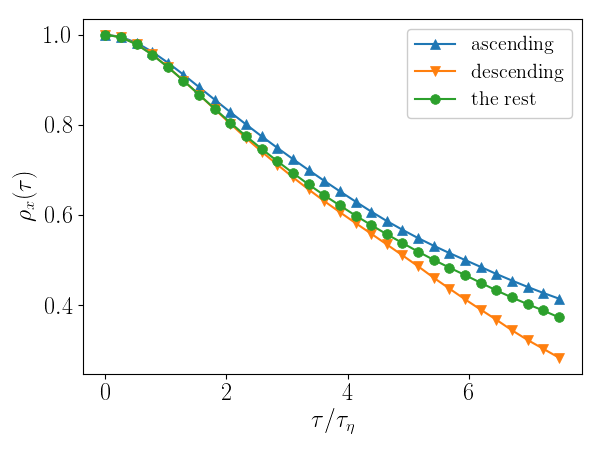

In [85]:
from scipy.optimize import curve_fit

R_sawford = lambda t, T, te: ( np.exp(-t/T)  -  te/T * np.exp(-t/te) ) / (1.0 - te/T)

p0 = [0.02, 0.01]

tm = np.arange(30)/FPS

popt, pcov = curve_fit(R_sawford, tm[:20], R_asc[:20], p0 = p0)
print popt[0] + popt[1]
popt, pcov = curve_fit(R_sawford, tm[:20], R_dsc[:20], p0 = p0)
print popt[0] + popt[1]
popt, pcov = curve_fit(R_sawford, tm[:20], R_[:20], p0 = p0)
print popt[0] + popt[1]


nrm = (nu / get_eps('b3',2.5))**0.5

fig, ax = plt.subplots()
ax.plot(tm/nrm, R_asc[:30], '-^', label='ascending')
ax.plot(tm/nrm, R_dsc[:30], '-v', label='descending')
ax.plot(tm/nrm, R_[:30], '-o', label='the rest')

ax.legend()

ax.set_xlabel(r'$\tau / \tau_\eta$')
ax.set_ylabel(r'$\rho_x(\tau)$')
plt.tight_layout()

fig.savefig('corr_asc_dsc.pdf')

Ascendng / Descending particles dont have a very different velocity decorrelation times :/

# Velocity decorrelation times vs. Acceleration decorrelation times (in canopy and DNS):

In [18]:
vx, ax = [], []
vx_jhu, ax_jhu = [], []

threshold = get_threshold(t)

for tr in t:
    vx.append(tr.velocity()[:,0])
    ax.append(tr.accel()[:,0])
        
        
for tr in t_jhu:
    vx_jhu.append(tr.velocity()[:50,0])
    ax_jhu.append(tr.accel()[:50,0])
    
    vx_jhu.append(tr.velocity()[50:100,0])
    ax_jhu.append(tr.accel()[50:100,0])
    
    vx_jhu.append(tr.velocity()[100:150,0])
    ax_jhu.append(tr.accel()[100:150,0])
    
    
R_vx, S, N = list_corelation(vx)
R_ax, S, N = list_corelation(ax)
R_vx_jhu, S, N = list_corelation(vx_jhu)
R_ax_jhu, S, N = list_corelation(ax_jhu)

4.71021149625
13.4480382384


/home/ron/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


<IPython.core.display.Javascript object>


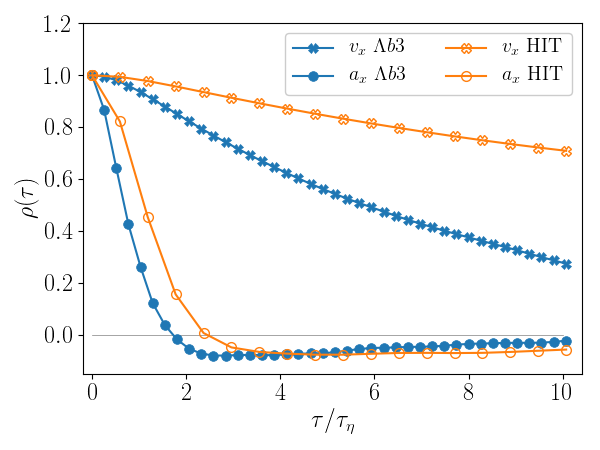

In [56]:
from scipy.optimize import curve_fit
R_sawford = lambda t, T, te: ( np.exp(-t/T)  -  te/T * np.exp(-t/te) ) / (1.0 - te/T)
p0 = [0.02, 0.01]


tm = np.arange(200) / FPS
tm_jhu = np.arange(200) / FPS_jhu


sol0,sol1 = curve_fit(R_sawford, tm[:40], R_vx[:40], p0=p0)
T_vx = sol0[0]+sol0[1]
T_ax = find_crossing(R_ax[:40], tm[:40], 0)[0]
print T_vx / T_ax


sol0,sol1 = curve_fit(R_sawford, tm_jhu[:40], R_vx_jhu[:40], p0=p0)
T_vx = sol0[0]+sol0[1]
T_ax = find_crossing(R_ax_jhu[:40], tm_jhu[:40], 0)[0]
print T_vx / T_ax





fig, ax = plt.subplots()

ax.plot([0,10], [0,0], 'k-', lw=.5, alpha = .5)

ax.plot(tm[:40] / t_eta, R_vx[:40], shapes[0]+'-', color = colors[0], label = r'$v_x$ $\Lambda b3$' )
ax.plot(tm[:40] / t_eta, R_ax[:40], shapes[1]+'-', color = colors[0], label = r'$a_x$ $\Lambda b3$')


ax.plot(tm_jhu[:18] / t_eta_jhu, R_vx_jhu[:18], shapes[0]+'-', mew=1.0,
        color = colors[1], fillstyle='none', label = r'$v_x$ HIT')
ax.plot(tm_jhu[:18] / t_eta_jhu, R_ax_jhu[:18], shapes[1]+'-', mew=1.0,
        color = colors[1], fillstyle='none', label = r'$a_x$ HIT')

ax.legend(ncol=2)

ax.set_xlim([-.2,10.4])
ax.set_ylim([-.15,1.2])

ax.set_xlabel(r'$\tau / \tau_\eta$')
ax.set_ylabel(r'$\rho(\tau)$')
plt.tight_layout()

#fig.savefig('vx_ax_corr.pdf')

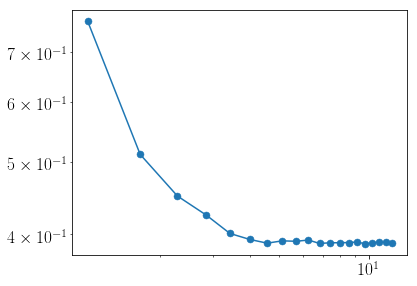

In [269]:
R,S,N = get_R('b3',2.5)

V = get_Ustats('b3',2.5)[0][0]*-1
tm = np.arange(len(R))/FPS

T = sum(curve_fit(R_sawford, tm[:20], R[:20], p0 = (0.05,0.02))[0])

F = np.fft.fft(R[:50])
f = np.fft.fftfreq(50, 1/FPS)
x,y = f[1:50], F[1:50]
E = x**3 * np.gradient(  np.gradient(y) / np.gradient(x) / x ) / np.gradient(x)

fig, ax = plt.subplots()
ax.loglog(x[1:21]*T, y[1:21] , '-o')

#ax.semilogx(f[3:25]*t_eta, 1000*f[3:25]**-1.33, 'k--')
#ax.loglog(f[18:50], 190*f[18:50]**-2, 'k--')
#ax.loglog(f[8:19], 1500000*f[8:19]**-4, 'k--')

In [260]:
N = 10000000
x = np.linspace(0,3,num=N)
T1,T2 = curve_fit(R_sawford, tm[:20], R[:20], p0 = (0.05,0.02))[0]
T = T1+T2
y = R_sawford(x,T1,T2) / T

F_sw = np.fft.fft(y) / N
f_sw = np.fft.fftfreq(len(y), x[1]-x[0])

y = np.exp(-x / T) / T

F_exp = np.fft.fft(y) / N
f_exp = np.fft.fftfreq(len(y), x[1]-x[0])


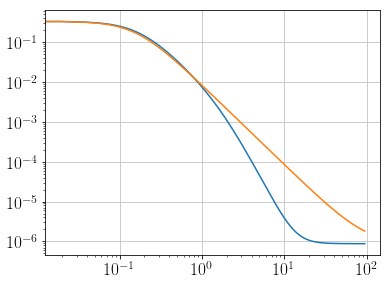

In [267]:
fig, ax = plt.subplots()

T = T1+T2
ax.loglog(f_sw[:5000]*T, F_sw[:5000])
ax.loglog(f_exp[:5000]*T, F_exp[:5000])
#ax.loglog(f_sw[400:1000]*T, f_sw[400:1000]**-3*30000000)

#z = 1/(1 + (f*2*np.pi)**2)
ax.grid()

# Plot Eurlerian structure function with fits:

<IPython.core.display.Javascript object>


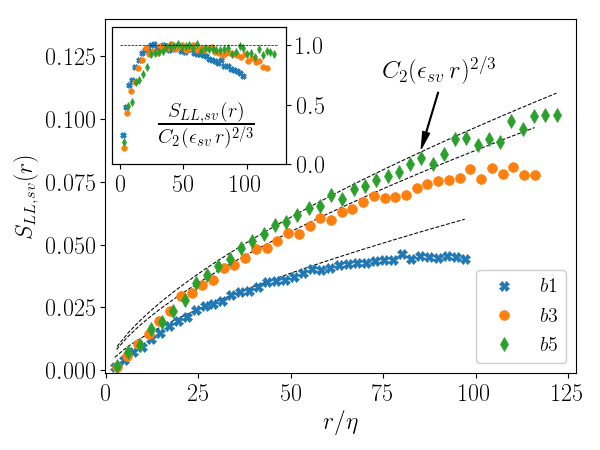

In [32]:
fig, ax = plt.subplots()
inset = fig.add_axes((0.187,0.635,0.29,0.305))
inset2 = inset.twinx()
inset.set_yticks([])


func = lambda r, esp: 2.1 * (eps * r)**(2.0/3.0)

U = 2.5
for e, sv in enumerate(['b1','b3','b5']):
    eps = get_eps(sv,U)
    eta = (nu**3 / eps)**0.25
    r,S2 = get_S2(sv, U)
    ax.plot(r/eta, func(r, eps), 'k--', lw=.75)
    ax.plot(r/eta, S2, shapes[e], label=r'$%s$'%sv)
    inset2.plot(r/eta, S2/func(r, eps), shapes[e], ms=4, label=r'$%s$'%sv)

ax.annotate(r'$C_2 (\epsilon_{sv} \, r)^{2/3}$', xy=(85, 0.087), xytext=(75, 0.115),
            arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5), fontsize=18,
            )
    
ax.legend(loc=4)
ax.set_xlabel(r'$r/\eta$')
ax.set_ylabel(r'$S_{LL,sv}(r)$')

ax.set_xlim(-.1,127)
ax.set_ylim(-0.001,0.14)


inset2.text(30, 0.15, r'$\frac{S_{LL,sv}(r)}{C_2 (\epsilon_{sv} \, r)^{2/3}}$', fontsize=21)
inset2.set_ylim(0,1.15)
inset2.plot([0,125], [1,1], 'k--', lw=0.5)
inset2.set_yticks([0,0.5,1])
inset2.set_xticks([0,50,100])


#ax.set_xscale('log')
#ax.set_yscale('log')

plt.tight_layout()

fig.savefig('S2_sv.pdf')

<IPython.core.display.Javascript object>


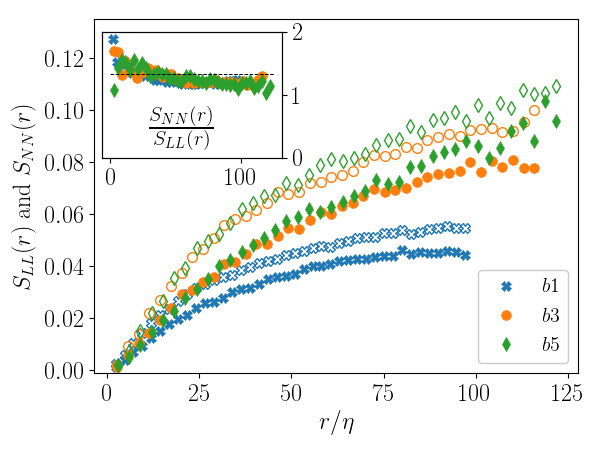

In [44]:
fig, ax = plt.subplots()

    
inset = fig.add_axes((0.17,0.65,0.3,0.28))
inset2 = inset.twinx()
inset.set_yticks([])
inset2.plot()


U = 2.5
for e, sv in enumerate(['b1', 'b3', 'b5']):
    eps = get_eps(sv,U)
    eta = (nu**3 / eps)**0.25
    
    fname = sv+'_2.5fg_data.npz'
    path = os.path.join('../small_scales/Trajectories', fname)
    data = np.load(path)
    ax.plot(data['r']/eta, data['f'], shapes[e], color=colors[e], label=r'$%s$'%sv)
    ax.plot(data['r']/eta, data['g'], shapes[e], color=colors[e], fillstyle='none', mew=1)
    
    inset2.plot(data['r']/eta, data['g'] / data['f'], shapes[e], color=colors[e])
    
inset2.set_ylim(0.,2)
inset2.plot([0,125], [4.0/3.0, 4.0/3.0], 'k--', lw=0.7)
inset2.text(30, 0.15, r'$\frac{S_{NN}(r)}{S_{LL}(r)}$', fontsize=21)
ax.set_ylim(-0.001,0.135)


ax.legend(loc=4)
ax.set_xlabel(r'$r/\eta$')
ax.set_ylabel(r'$S_{LL}(r)$  and  $S_{NN}(r)$')

plt.tight_layout()

fig.savefig('Eu_Sf_trans_and_long.pdf')

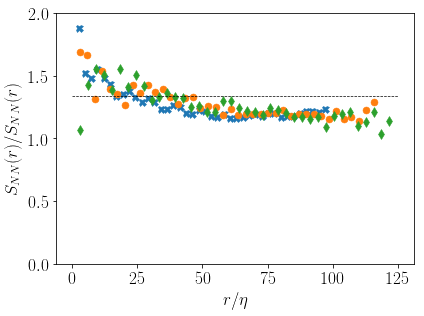

In [5]:
fig, ax = plt.subplots()



U = 2.5
for e, sv in enumerate(['b1', 'b3', 'b5']):
    eps = get_eps(sv,U)
    eta = (nu**3 / eps)**0.25
    
    fname = sv+'_2.5fg_data.npz'
    path = os.path.join('../small_scales/Trajectories', fname)
    data = np.load(path)
    
    ax.plot(data['r']/eta, data['g'] / data['f'], shapes[e], color=colors[e])
    
ax.set_ylim(0.,2)
ax.plot([0,125], [4.0/3.0, 4.0/3.0], 'k--', lw=0.7)

ax.set_xlabel(r'$r/\eta$')
ax.set_ylabel(r'$ S_{NN}(r) / S_{NN}(r)$')

plt.tight_layout()

fig.savefig('Eu_Sf_trans_over_long.pdf')

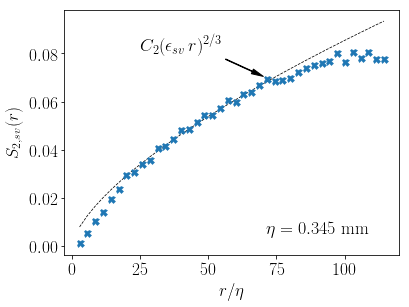

In [24]:
fig, ax = plt.subplots()

func = lambda r, esp: 2.1 * (eps * r)**(2.0/3.0)

U = 2.5
for e, sv in enumerate(['b3']):
    eps = get_eps(sv,U)*0.95
    eta = (nu**3 / eps)**0.25
    r,S2 = get_S2(sv, U)
    ax.plot(r/eta, func(r, eps), 'k--', lw=.75)
    ax.plot(r/eta, S2, shapes[e], label=r'$%s$'%sv)

ax.annotate(r'$C_2 (\epsilon_{sv} \, r)^{2/3}$', xy=(71, 0.07), xytext=(25, 0.08),
            arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5), fontsize=18,
            )

ax.text(71, 0.005, r'$\eta=%.3f$ mm'%(eta*1000), fontsize=18)

#ax.legend()
ax.set_xlabel(r'$r/\eta$')
ax.set_ylabel(r'$S_{2,sv}(r)$')

fig.savefig('S_LL_b3.pdf')

# Looking at the wake production effect:


using results from Poggi Katul and Cassiani 2008:


$$ \overline{\epsilon} \equiv \frac{2\sigma_x^2}{C_{0,i} T_i} \quad ; \quad \epsilon = \epsilon_m $$


$$  \epsilon_m - \overline{\epsilon} = W_p\frac{\eta}{Lw} = W_p \frac{0.21 \eta}{d} $$


$$ \Rightarrow W_p = \frac{d}{0.21 \, \eta} (\epsilon_m - \overline{\epsilon}) $$

now I can ask does the $W_p$ estimation defined above scale as $\langle u \rangle^3$ ?

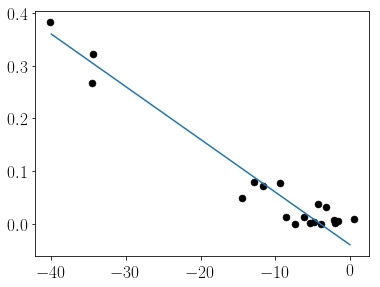

In [21]:
fig, ax = plt.subplots()

U = 2.5
for sv in subvolumes[:-1]:
    
    eps = get_eps(sv,U)
    eta = (nu**3 / eps)**0.25
    
    sigma_x = get_Ustats(sv, U)[1][0]**0.5
    Tx = get_TL(sv, U, kind = 'x')
    
    data = np.load( os.path.join('DL_data', 'DL_%s_%d.npz'%(sv, U*10) ) )
    tm = np.arange(50)/FPS
    c0 = max(data['DL'][1:50,1] / tm[1:] / eps)
    
    eps_line = 2 * sigma_x**2 / c0 / Tx
    
    d = 0.004
    Wp =  (eps - eps_line) * d / 0.21 / eta
    
    ux = -1*get_Ustats(sv, U)[0][0]
    
    ax.plot([Wp], [ux**3], 'ko')

x = np.linspace(-40,0)
ax.plot(x, x*-0.01 - 0.04)

the wake productino here turns out negative, which is not physical. the reason may be that $\overline{\epsilon} \equiv \frac{2\sigma_x^2}{C_{0,i} T_i}$ cannot be used with $\sigma_x$, but with a "wake" associated velocity fluctuations.

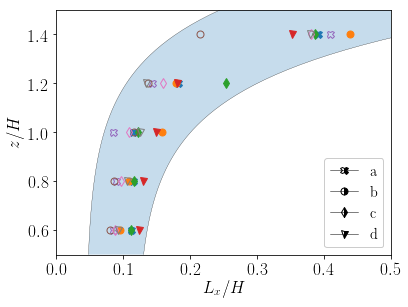

In [132]:
fig, ax = plt.subplots()

L = []

U = 2.5

shape_dic = dict( zip(['a','b','c','d'],shapes[:4]) )
col_dic1 = dict( zip(['a','b','c','d'] , colors[:4]) )
col_dic2 = dict( zip(['a','b','c','d'] , colors[4:8]) )

for U in [2.5, 4.0]:
    for sv in subvolumes[:]:
    
        eps = get_eps(sv,U)
        eta = (nu**3 / eps)**0.25
    
        sigma_x = get_Ustats(sv, U)[1][0]**0.5
        sigma_y = get_Ustats(sv, U)[1][1]**0.5
        sigma_z = get_Ustats(sv, U)[1][2]**0.5
        Tx = get_TL(sv, U, kind = 'x')
    
        data = np.load( os.path.join('DL_data', 'DL_%s_%d.npz'%(sv, U*10) ) )
        tm = np.arange(50)/FPS
        c0 = max(data['DL'][1:50,1] / tm[1:] / eps)
    
        eps_line = 2 * sigma_x**2 / c0 / Tx
        
        z = (int(sv[-1])-1)*0.2 + 0.6
        H = 0.1
        L = Tx*sigma_x
        
        fill= 'full'
        if U == 4.0: fill = 'none'
        col_dic = col_dic1
        if U == 4.0: col_dic = col_dic2
        ax.plot([L/H], z, shape_dic[sv[0]], fillstyle = fill, mew = 1, color = col_dic[sv[0]])
        
        #L.append(Tx * sigma_x)
    
#x = np.linspace(-40,0)
#ax.plot(x, x*-0.01 - 0.04)
#ax.hist(L)

for e,hloc in enumerate(['a','b','c','d']):
    ax.plot([],[],'k-'+shapes[e],lw = 0.5, fillstyle = 'right', label = hloc,mew=1)
ax.legend(loc=4)

ax.set_xlim([0, 0.5])
ax.set_ylim([0.5, 1.5])

yy = np.linspace(0.5,1.5)
xx1 = 0.2 * (np.exp( (yy-1.5)*4))+0.045
xx2 = 0.6 * (np.exp( (yy-1.5)*4))+0.12

ax.fill_betweenx(yy, xx1, xx2, alpha = 0.25)
ax.plot(xx1, yy, 'k-', lw=.25)
ax.plot(xx2, yy, 'k-', lw=.25)

ax.set_xlabel(r'$L_{x} / H$')
ax.set_ylabel(r'$z / H$')

fig.savefig('lagrangian_length.pdf')

# a Longitudinal Lagrangian Structure function:

$$ \vec{\delta x}(\tau) = \vec{x}(t_0+\tau) - \vec{x}(t_0) $$


$$ v_{\delta x}(\tau) = \frac{\vec{v} \cdot \vec{\delta x}}{|\vec{\delta x}|} $$ 

defined to be $|\vec{v}|$ at $\tau=0$

$$ \Delta_\tau v_{\delta x} = v_{\delta x}(t_0 + \tau) - v_{\delta x}(t_0)$$


$$ D_{LL}(\tau) = \langle \Delta_\tau v_{\delta x}^2 \rangle$$

In [34]:
def get_v_dx(tr):
    dx = tr.pos() - tr.pos()[0,:]
    dx_ = np.sum(dx**2, axis = 1)**0.5
    v_dx = np.sum(tr.velocity()[1:] * dx[1:], axis = 1) / dx_[1:]
    return np.append(np.sum(tr.velocity()[0,:]**2)**0.5, v_dx)


N = 60
dv_bins = [[] for i in range(N)]
dv_bins[0] = [0]


for tr in t[:]:
    v = get_v_dx(tr)
    
    for i in range(len(v)):
        for j in range(i+1,len(v)):
            if j-i+1 > N: continue
            dv_bins[j-i].append(v[j]-v[i])

DLL = [np.mean(np.array(lst)**2) for lst in dv_bins]

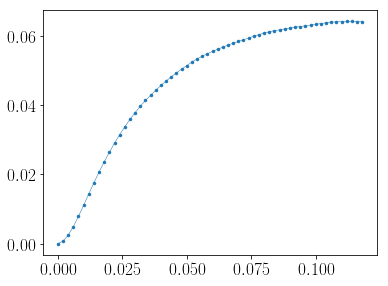

In [37]:
fig, ax = plt.subplots()
tm = np.arange(len(DLL))/FPS
ax.plot(tm, DLL, 'o-', ms=3, lw=.5)

# Using the Novikov 1963 estimate $\epsilon^*$:

Define a Lagrangian dissipation 

$$\epsilon^* = \frac{\langle v^2 \rangle}{T_L}$$

assuming Kolmogorov similarity gives $\epsilon^* = \frac{C_0}{2}\epsilon$. Taking the Langevin equation:

$$ \frac{dv}{dt} = -\frac{v}{T_L} + f(t) $$

where $f(t)$ is a random force per fluid mass, multiplying by $v$ and averaging gives:

$$ \frac{1}{2} \left\langle\frac{dv^2}{dt} \right\rangle = \langle v\,f\rangle - \epsilon^* $$ 

So in the stationary flow case:

$$ \epsilon^* = \langle v \, f \rangle $$.

However in the 3D-PTV and the canopy flow experiment the process is probably not stationary. Here I examine this:

* note, all the veocities are relative to the mean $U = \langle v \rangle$.

In [18]:
U_ = get_Ustats(subvol,U)[0]

dv2dt_lst = []
v2_lst = []

for tr in t:
    dv2dt_lst += list(tr.accel()[:,0] * (tr.velocity()[:,0] - U_[0]))
    v2_lst += list( (tr.velocity()[:,0] - U_[0])**2 )
    


T = get_TL(subvol, U)
eps = np.mean(v2_lst)/ T

print '%.3f'%(np.mean(dv2dt_lst) / eps)

0.030


so, empirically I obtained:

$$ \frac{1}{2} \left\langle\frac{dv^2}{dt} \right\rangle \approx 0.03 \epsilon^* $$

meaning that the process is to a good approximation stationary.

<br>
Just for the interest, look at the random force directly:

$$ f = \frac{v}{T} + \frac{dv}{dt} $$

0.5 14.9 0.6 15.3


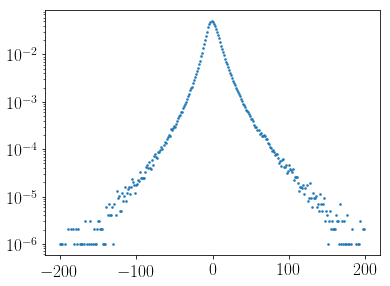

In [56]:
#f_lst = []

#for tr in t:
#    f_lst += list( -tr.accel()[:,0] - (tr.velocity()[:,0] - U_[0])/T)
    
fig, ax = plt.subplots()
xx, yy = hist_lines(f_lst, np.linspace(-200,200,num=300))
ax.semilogy(xx, yy, 'o', ms=2)
#ax.set_ylim(1e-5, 1e-1)
#ax.set_xlim(-150, 150)

M = np.trapz(xx * yy,xx)
Var = np.trapz( (xx-M)**2 * yy,xx)
Sk = np.trapz( (xx-M)**3 * yy,xx) / Var**(3.0/2.0)
F = np.trapz( (xx-M)**4 * yy,xx) / Var**(2.0)
print '%.1f %.1f %.1f %.1f'%(M, Var**0.5, Sk, F)

In [23]:
U_ = get_Ustats(subvol,U)[0]

P_lst = []
eps_lst = []

T = get_TL(subvol, U)

for tr in t[:]:
    v = tr.velocity()[:,0]-U_[0]
    f = tr.accel()[:,0] + v/T
    P_lst += list(f * v)
    eps = v**2 / T
    eps_lst += list(eps)
    
print 'P=%.2f, eps=%.2f'%(np.mean(P_lst), np.mean(eps_lst))
    

P=1.79, eps=1.77


###### calculate and save for all subvolumes:

In [28]:
dirname = os.path.join('../small_scales','Trajectories',)

#t = get_traj_list( os.path.join(dirname, '%s_%.1f.h5'%(subvol,U)) )
results = []

for U in [2.5, 4.0]:
    
    for sv in subvolumes:
        U_ = get_Ustats(subvol,U)[0]
        S = Scene(os.path.join(dirname, '%s_%.1f.h5'%(sv,U)))
        
        P_lst = []
        eps_lst = []

        for tr in S.iter_trajectories():
            v = tr.velocity()[:,0]-U_[0]
            f = tr.accel()[:,0] + v/T
            P_lst += list(f * v)
            eps = v**2 / T
            eps_lst += list(eps)
        
        results.append((sv, U, np.mean(P_lst), np.mean(eps_lst)))
        
np.savez('Lagrange_eps_prod.npz', results = results)

<IPython.core.display.Javascript object>


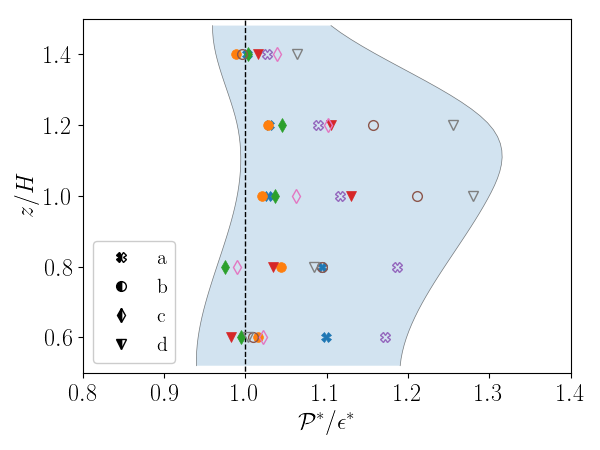

In [107]:
data = np.load('Lagrange_eps_prod.npz')
results = data['results']

dic = {'a':0, 'b':1, 'c':2, 'd':3}



fig, ax = plt.subplots()

# dashed line:
ax.plot([1.0,1.0], [0.4,1.6], 'k--', lw=1)

# the data:
for i in range(results.shape[0]):
    
    sv = results[i,0]
    z = 0.4 + 0.2*float(sv[1])
    r = float(results[i,2]) / float(results[i,3])
    U = results[i,1]
    
    
    
    if U == '2.5':
        ax.plot(r, z, shapes[dic[sv[0]]], color= colors[dic[sv[0]]])
    if U == '4.0':
        ax.plot(r, z, shapes[dic[sv[0]]], color= colors[dic[sv[0]] + 4],
               fillstyle='none', mew=1)

        
# the legend:
for sv in ['a','b','c','d']:
    ax.plot([],[], shapes[dic[sv]]+'k', mew=1, fillstyle='left', label=sv)
ax.legend(loc=3)
    
        
        
        
# the shaded region:
from scipy.interpolate import interp1d

zz = [0.51,0.8,1.0,1.2, 1.3, 1.49]
c_max = np.array([1.19,1.245,1.3,1.3,1.24, 1.1])
c_min = np.array([.95,.975,1.0,1.0, .987,.97])-.01

env_max = interp1d(zz, c_max, kind='cubic')
env_min = interp1d(zz, c_min, kind='cubic')

z_new = np.linspace(.52, 1.48)
ax.plot(env_min(z_new), z_new, 'k-', lw = 0.5, fillstyle='none', alpha=.5)
ax.plot(env_max(z_new), z_new, 'k-', lw = 0.5, fillstyle='none', alpha=.5)
ax.fill_betweenx(z_new, env_min(z_new), x2=env_max(z_new), alpha=.2)
        
        
        
        
        
        
        
        
ax.set_xlim(0.8,1.4)
ax.set_ylim(0.5,1.5)

ax.set_xlabel(r'$\mathcal{P}^* / \epsilon^*$')
ax.set_ylabel(r'$z/H$')


plt.tight_layout()

fig.savefig('lagrange_prod_vs_eps.pdf')

In [32]:
sum(np.array(list_of_values)>1), len(list_of_values)

(34, 40)

<IPython.core.display.Javascript object>


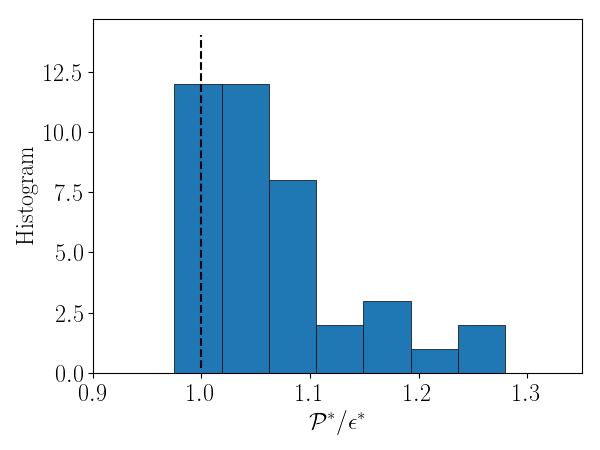

In [28]:
data = np.load('Lagrange_eps_prod.npz')
results = data['results']



fig, ax = plt.subplots()

N = results.shape[0]
list_of_values = [float(results[i,2]) / float(results[i,3]) for i in range(N)]

ax.hist(list_of_values, edgecolor='black', linewidth=0.5, bins=7)
ax.plot([1, 1], [0.2,14], 'k--')

ax.set_xlim(0.9,1.35)
#ax.set_ylim(0.5,1.5)

ax.set_xlabel(r'$\mathcal{P}^* / \epsilon^*$')
ax.set_ylabel(r'Histogram')


plt.tight_layout()

fig.savefig('lagrange_prod_vs_eps_hist.pdf')

## statistics of $\Delta_\tau v$

In [23]:
ind_lst = np.arange(1,47,2)
dv_bins = [[] for i in range(len(ind_lst))]

for tr in t:
    for i in range(len(ind_lst)):
        ind = ind_lst[i]
        dv_bins[i] += list(tr.velocity()[:-ind,0] - tr.velocity()[ind:,0])
        #dv_bins[i] += list(tr.velocity()[:-ind,1] - tr.velocity()[ind:,1])
        #dv_bins[i] += list(tr.velocity()[:-ind,2] - tr.velocity()[ind:,2])
    

In [492]:
# skewness:
from scipy.stats import skew as skew
sk = np.array([skew(dv) for dv in dv_bins])
print sk

[ 0.419  0.349  0.28   0.236  0.199  0.18   0.165  0.161  0.168  0.173
  0.153  0.123  0.091  0.064  0.036  0.003 -0.014 -0.034 -0.051 -0.053
 -0.05  -0.046 -0.043]


In [24]:
# the kurtosis:        

from scipy.stats import kurtosis as krtsis
kr = np.array([krtsis(dv) for dv in dv_bins])

# errorbas for the kurtosis:
import random
kr_err, N = [], 5
for dv in dv_bins:
    tmp = []
    for i in range(N):
        sample = random.sample(dv, int(len(dv)/N))
        tmp.append(krtsis(sample))
    kr_err.append( 0.5*(max(tmp) - min(tmp)) )
    
    
    
v_lst = []
for tr in t:
    v_lst += list(tr.velocity()[:,0])
f0 = krtsis(v_lst)+3

<IPython.core.display.Javascript object>


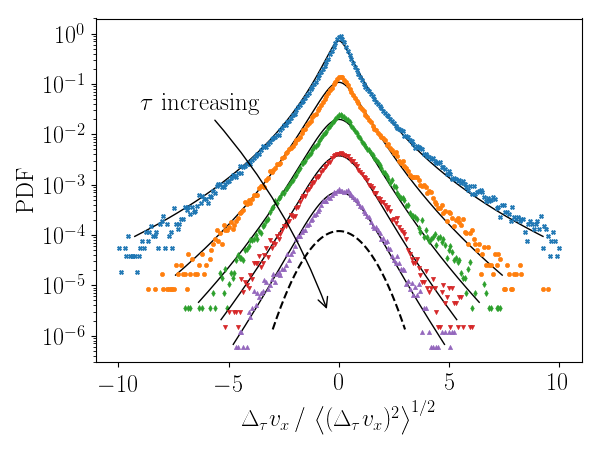

0.258, 13.510, 11.901
2.839, 7.679, 6.554
5.419, 5.805, 5.268
8.000, 4.757, 4.504
10.581, 4.354, 4.057


In [23]:
#from multifractal_model import MFLI

folder = 'velocity_increments_PDFs_b3'
files = sorted(os.listdir(folder))

eps = get_eps('b3', 2.5)
t_eta = (nu/eps)**0.5

Re = 440
T = get_TL('b3', 2.5)
c2 = 0.087
delta = 0.6
mfli = MFLI(Re, T, delta, c2, 3.8)


N = 501

dv0_dvn_lst = [(-.5, .5), (-2.0, 2.0), (-2.5, 2.5), (-2.6, 2.6), (-2.7, 2.7)]

fig, ax = plt.subplots()

for e,f in enumerate(files):
    fn = os.path.join(folder, f)
    data = np.load(fn)
    xx, yy, tm = data['xx'], data['yy'], data['tm']
    
    # plot the model:
    dv0, dvn = dv0_dvn_lst[e]
    dv_ax, Pdv = mfli.calc_P_dv(dv0, dvn, N, tm)
    fctr = np.trapz( Pdv, dv_ax )
    y_ = Pdv / fctr
    Smf = np.trapz( y_ * dv_ax**2, dv_ax )**0.5
    ax.semilogy(dv_ax/Smf, y_*Smf /5**e, 'k-', lw=1)
    
    #plot the data:
    ax.semilogy(xx, yy/5**e, shapes[e] ,color = colors[e], ms=3)
    M,S = get_M_S(xx,yy)
    f = np.trapz(yy*(xx-M)**4, xx) / S**4
    
    
    print '%.3f, %.3f, %.3f'%(tm / t_eta, f, np.trapz(y_ * (dv_ax)**4, dv_ax) / Smf**4)
    
    
ax.set_xlim(-11,11)
ax.set_ylim(3e-7,2)



x_ = np.linspace(-3.,3.,num=200)
y_ = Gauss(x_, 0, 1)
ax.semilogy(x_, y_ *3e-4, 'k--')


lbl = r'$  \Delta_\tau v_x  \, / \, \left\langle (\Delta_\tau v_x)^2 \right\rangle^{1/2}$'
ax.set_xlabel(lbl)
ax.set_ylabel(r'PDF')

ax.annotate(r'$\tau$ increasing', xy=(-.5,.3e-5), xytext = (-9,3e-2), fontsize=18,
            arrowprops=dict(facecolor='black', arrowstyle="->", connectionstyle = 'arc3,rad=-0.1'))

plt.tight_layout()

fig.savefig('dv_PDF.pdf')

In [6]:
# the multi fractal model with extra parameter (R):


class MFLI(object):
    '''
    a class that does the actual calculation. simply use the method
    calc_P_dv(...)
    '''
    
    
    def __init__(self, Re, T, delta, c2, R):
        '''
        model parameters - see the article
        '''
        self.Re = Re
        self.T = T
        self.d = delta
        self.c2 = c2
        self.c1 = 0.5 + c2
        
        self.Dh = lambda h: 1.0 - (h-self.c1)**2 /2.0/self.c2
        self.tau_eta = lambda h: self.T * self.Re**(-1.0/(2.0*h + 1))
        
        self.R = R
        
    def beta(self, h, tau):
        x1 = tau / self.T / self.R ;  x2 = tau / self.tau_eta(h) 
        return (x1)**h / (1 + x2**(-self.d))**((1-h)/self.d) 

    
    def P(self, h, tau):
        x1 = tau / self.T / self.R ;  x2 = tau / self.tau_eta(h)
        D = self.Dh(h)
        return (x1)**(1-D) / (1 + x2**(-self.d))**((D-1)/self.d) 
    
    
    def G(self, x):
        return 1.0 / (2.0*np.pi)**0.5 * np.exp(-0.5 * x**2)
    
    
    def Integrand(self, h, tau, dv):
        D = self.Dh(h)
        p = self.P(h, tau) #/ self.R**(1.0-D)
        b = self.beta(h, tau) #/ self.R**h
        return p / b * self.G(dv / b)
    
    
    def poke_P_dv(self, dv, tau):
        '''
        this integrates the integrand to find a single value P(dv)
        '''
        # the resolution of the integrand:
        dh = 0.005
        h, I = [-0.495], [self.Integrand(-0.495, tau, dv)]
        test = 1
        count = 0
        while test and count < 2000:
            h.append( h[-1] + dh )
            I.append( self.Integrand(h[-1], tau, dv))
            if I[-1] < I[0]/100:
                test = 0
            count += 1
        
        P_dv = np.trapz(I, h)
        #print 'steps needed %d'%(len(h))
        return P_dv
    
    
    def calc_P_dv(self, dv_min, dv_max, N, tau):
        '''
        iteratively uses poke_P_dv to obtain a function P_dv(tau)
        returns the function at N points between dv_min and dv_max
        '''
        
        d_dv = (dv_max - dv_min)/(1.0*N)
        dv_axes = np.array([ dv_min + d_dv*(i+0.5) for i in range(N)])
        P_dv = np.array([ self.poke_P_dv(dv, tau) for dv in dv_axes])
        return dv_axes, P_dv
        

In [410]:
# Now with the JHU trajectories:

np.arange(60)/FPS_jhu/t_eta_jhu
ind_lst = [1, 5, 9, 14, 18]

dv_bins = [[] for i in range(len(ind_lst))]
for tr in t_jhu:
    e=0
    for ind in ind_lst:
        dv_bins[e] += list( tr.velocity()[ind:, 0] - tr.velocity()[:-ind, 0])
        dv_bins[e] += list( tr.velocity()[ind:, 1] - tr.velocity()[:-ind, 1])
        dv_bins[e] += list( tr.velocity()[ind:, 2] - tr.velocity()[:-ind, 2])
        e+=1

In [444]:
PDFs = []

lims = [10,7,6,5,5]
for e, dv_lst in enumerate(dv_bins):
    s = np.var(dv_lst)**0.5
    xx, yy = hist_lines(np.array(dv_lst)/s, np.linspace(-lims[e], lims[e], num = 100))
    M,S = get_M_S(xx,yy)
    PDFs.append( [xx/S, yy*S])

<IPython.core.display.Javascript object>


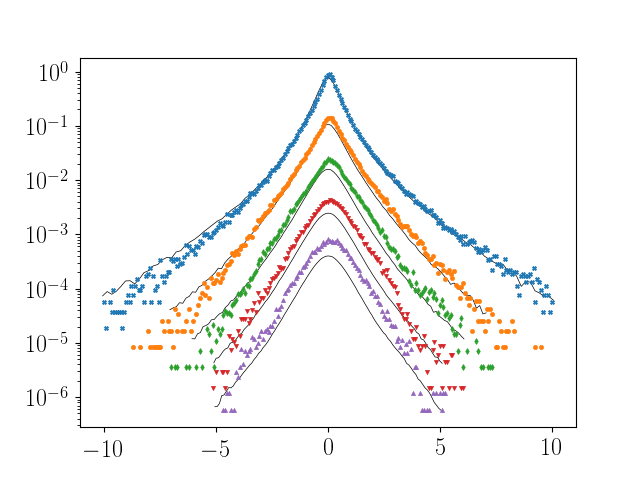

14.362311704234198
13.510265893830583
8.088601177556134
7.678652241756883
6.571929786911333
5.805335413606891
5.4943552379517735
4.757483217550517
5.290036586734319
4.353944220857231


In [446]:
fig, ax = plt.subplots()


folder = 'velocity_increments_PDFs_b3'
files = sorted(os.listdir(folder))


for e, pdf in enumerate(PDFs):
    xx, yy = pdf
    ax.semilogy(xx, yy/(6**e), 'k-', lw=0.5)
    M,S = get_M_S(xx,yy)
    F = np.trapz( (xx-M)**4 * yy, xx ) / S**4
    print F
    
    
    
    f = files[e]
    fn = os.path.join(folder, f)
    data = np.load(fn)
    xx, yy, tm = data['xx'], data['yy'], data['tm']
    ax.semilogy(xx, yy/5**e, shapes[e] ,color = colors[e], ms=3)
    
    M,S = get_M_S(xx,yy)
    F = np.trapz( (xx-M)**4 * yy, xx ) / S**4
    print F
    
    e = e+1

In [12]:
from scipy.stats import kurtosis as krtsis
ind_lst = range(1,25)

F_lst = []

for ind in ind_lst:
    
    dv_lst = []
    for tr in t_jhu:
        dv_lst += list( tr.velocity()[ind:, 0] - tr.velocity()[:-ind, 0])
        dv_lst += list( tr.velocity()[ind:, 1] - tr.velocity()[:-ind, 1])
        dv_lst += list( tr.velocity()[ind:, 2] - tr.velocity()[:-ind, 2])
        
    F_lst.append(krtsis(dv_lst) + 3)

In [34]:
np.savez('flatness_b3.npz', F_b3 = kr+3, tm_b3 = tm / t_eta, F_jhu = F_lst,
         tm_jhu = tm_jhu / t_eta_jhu, F_err_b3 = kr_err, F_mfli = Flt_mfli, t_mfli = tm_lst /t_eta,
        doc='flatness of velocity component increments at different times. time is normalized by t_eta')


<IPython.core.display.Javascript object>


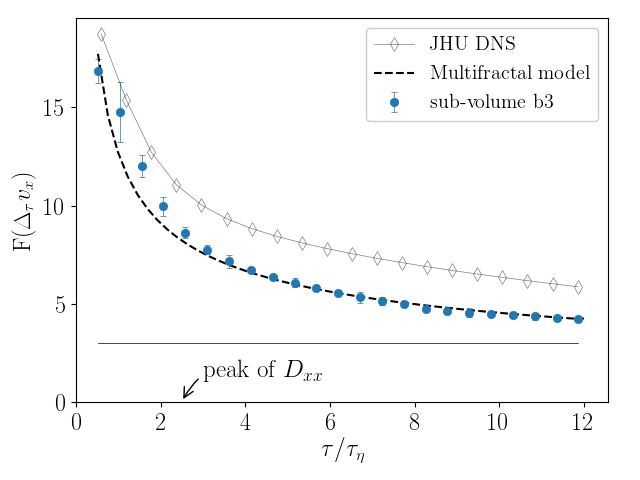

In [193]:

F_data = np.load('flatness_b3.npz')




fig, ax = plt.subplots()

eps = get_eps(subvol, U)
t_eta = (nu / eps)**0.5


lbl = ['sub-volume b3', 'JHU DNS', 'Multifractal model']
ax.errorbar(F_data['tm_b3'], F_data['F_b3'], yerr=F_data['F_err_b3'], fmt='o', lw=0.5, ms=6, capsize=2, label=lbl[0])
ax.plot(F_data['tm_jhu'][:-4], F_data['F_jhu'][:-4], shapes[2]+'k-', lw=0.5, fillstyle='none', alpha=0.5, label=lbl[1])
ax.plot(F_data['t_mfli'], F_data['F_mfli'], 'k--', label=lbl[2])
ax.plot(F_data['tm_b3'], np.ones(len(F_data['tm_b3']))*3, 'k-', lw=0.5)




a_ = 2.5
#ax.plot([a_,a_], [7,12], 'k-', lw=0.5)
ax.annotate(r'peak of $D_{xx}$', xy=(2.5,0.02), xytext = (3.,1.), fontsize=18,
            arrowprops=dict(facecolor='black', arrowstyle="->", connectionstyle = 'arc3,rad=0.5'))
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)

ax.legend()


ax.set_ylabel(r'F($\Delta_\tau v_x$)')
ax.set_xlabel(r'$\tau / \tau_\eta$')
plt.tight_layout()


fig.savefig('dv_kurt.pdf')

In [159]:
# calculate Flatness using the multifractal model:

Re = 440
T = get_TL('b3', 2.5)
c2 = 0.087
delta = 0.6
mfli = MFLI(Re, T, delta, c2, 3.8)

dv0, dvn = -15., 15.
N = 4000

Flt_mfli = []
tm_lst = np.linspace(2.0/FPS, 12*t_eta, num=50) #np.append(np.linspace(2.0/FPS, 3.*t_eta, num=3), [8*t_eta, 11*t_eta])

for tm in tm_lst:
    xx, yy = mfli.calc_P_dv(-15, 15, N, tm)
    I = np.trapz(yy, xx)
    yy = yy / I
    M, S = get_M_S(xx,yy)
    mu4 = np.trapz(xx**4 * yy, xx)
    Flt_mfli.append(mu4 / S**4)
    print '%.1f'%(mu4 / S**4)

17.7
14.6
12.7
11.5
10.6
9.8
9.3
8.8
8.4
8.0
7.7
7.5
7.2
7.0
6.8
6.7
6.5
6.3
6.2
6.1
6.0
5.9
5.8
5.7
5.6
5.5
5.4
5.3
5.2
5.2
5.1
5.0
5.0
4.9
4.9
4.8
4.8
4.7
4.7
4.6
4.6
4.5
4.5
4.4
4.4
4.4
4.3
4.3
4.2
4.2


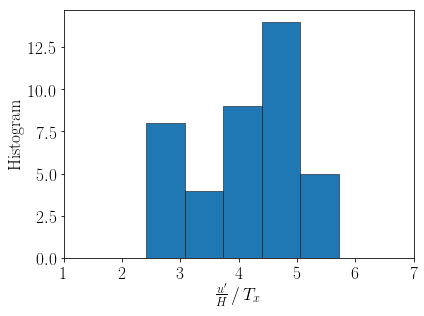

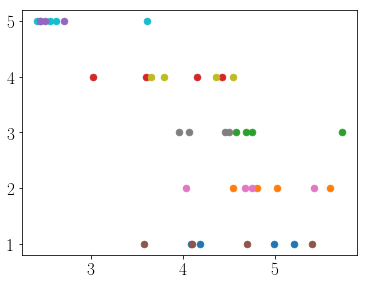

In [23]:
H = 0.1

lst = []

for U in [2.5, 4.0]:
    for subvol in subvolumes:
        urms = get_Ustats(subvol, U)[2]
        TL = get_TL(subvol, U)
        
        lst.append((H / urms) / TL)

fig, ax = plt.subplots()
ax.hist(lst,edgecolor='black', linewidth=0.5, bins = 5)
ax.set_xlim([1,7])
ax.set_xlabel(r"$\frac{u'}{H} \, / \, T_x$", fontsize=18)
ax.set_ylabel(r"Histogram")
plt.tight_layout()


fig, ax = plt.subplots()

for U in [2.5, 4.0]:
    for subvol in subvolumes:
        urms = get_Ustats(subvol, U)[2]
        TL = get_TL(subvol, U)
        z = subvol[1]
        ax.plot((H / urms) / TL, z,'o')

# Spatial Velocity Increments:

In [60]:
p = make_pairs_sequencially(t, N = 500, end_at=None)
print len(p)

503616


In [61]:
get_r = lambda p_: np.linalg.norm(p_.pos1 - p_.pos2, axis = 1)

def get_vl(p_):
    '''
    returns the longitudinal velocity component of a pair
    '''
    r = get_r(p_)
    vl = np.sum((p_.vel1 - p_.vel2)*(p_.pos1 - p_.pos2), axis = 1) / r
    return vl

In [102]:
H=0.1
r0, rn = 0.0005, 0.3*H
N = 16
r_bins = np.linspace(r0,rn,num=N+1)
vl_bins = [ [] for i in range(N)]

for p_ in p:
    
    r = get_r(p_)
    vl = get_vl(p_)
    
    for i in range(len(p_)):
        
        if r[i]>rn or r[i]<=r0:
            continue
            
        ind = int( (r[i] - r0)/(rn - r0) * N  )
        
        vl_bins[ind].append(vl[i])
        

/home/ron/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in divide
  


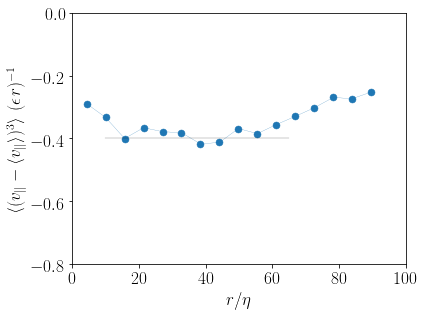

In [111]:
Sf_3 = []
for lst in vl_bins:
    M = np.mean(lst)
    Sf_3.append( np.mean((np.array(lst) - M)**3) )
    
Sf_3 = np.array(Sf_3)

fig, ax = plt.subplots()

x_ = (r_bins[:-1] + r_bins[1:])*0.5
ax.plot(x_/eta, Sf_3 / (x_ * eps), 'o-', lw=0.2)
ax.plot([10,65], [-0.4, -0.4], 'k-', lw=0.2)

#x_ = np.linspace(0,65)
#ax.plot(x_, x_ * (-0.00013))
ax.set_xlim(0,100)
ax.set_ylim(-0.8,0)


ax.set_xlabel(r'$r / \eta$')
ax.set_ylabel(r'$\langle (v_{||} - \langle v_{||} \rangle)^3 \rangle \,\, (\epsilon \, r)^{-1}$')

plt.tight_layout()
fig.savefig('Eu_S_3_b3.pdf')

4698
-0.420285686934


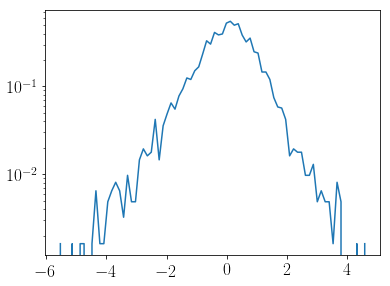

In [162]:
ind = 1
from scipy.stats import skew

print len(vl_bins[ind])
print skew(vl_bins[ind])

x,y = hist_lines(vl_bins[ind], 'auto')
S = np.std(vl_bins[ind])

fig, ax = plt.subplots()
ax.semilogy(x/S,y*S)

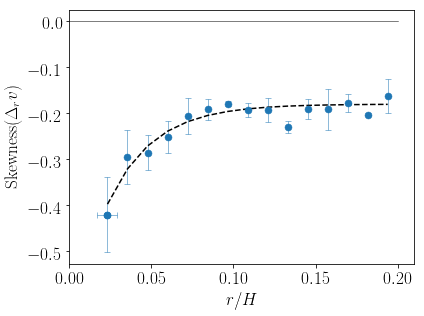

In [171]:
from scipy.stats import skew

skewness = [skew(vl) for vl in vl_bins]

skewness1 = [skew(vl[:len(vl)/2]) for vl in vl_bins]
skewness2 = [skew(vl[len(vl)/2:]) for vl in vl_bins]

mx = [ max([skewness1[i], skewness2[i]]) for i in range(len(skewness))]
mn = [ min([skewness1[i], skewness2[i]]) for i in range(len(skewness))]

def running_avg(x,win):
    return np.convolve(x, np.ones(win)/win, mode='same')

err = running_avg((np.array(mx) - np.array(mn))/2, 1)


fig, ax = plt.subplots()

x = 0.5*(r_bins[:-1]+r_bins[1:])


ax.plot(x[1:]/H, -0.18 - 0.5*np.exp(-x[1:]/H/0.028), 'k--')

#ax.plot(x[1:]/H, skewness[1:])
ax.errorbar(x[1:]/H, skewness[1:], yerr = err[1:], capsize=3, elinewidth=0.5, lw=0.5,
            fmt='o', color=colors[0])
dx = (r_bins[1]-r_bins[0])/H
ax.errorbar(x[1]/H, skewness[1], xerr = [dx/2], capsize=3, elinewidth=0.5, lw=0.5,
            fmt='o', color=colors[0])
#ax.plot(x[1:]/H, skewness[1:] + err[1:])
#ax.plot(x[1:]/H, skewness[1:] - err[1:])
ax.plot([0,0.2], [0,0], 'k-', lw=0.5)

ax.set_xlim(left=0)
ax.set_xlabel(r'$r/H$')
ax.set_ylabel(r'Skewness($\Delta_r v$)')
plt.tight_layout()

fig.savefig('dv_skewness_b3.pdf')


# Convergence of Lagrangian $\rho_i$:

In [ ]:
# obtain the error in terms of convergence in time:

ind = range(0,len(t),20000)
R_lst = []

for i in range(len(ind)-1):
    vx = [ tr.velocity()[:,0] for tr in t[ind[i]:ind[i+1]] ]
    R, S, N = list_corelation(vx)
    R_lst.append(R[:50])

    #ax.plot(R[:50])
        
mx = np.amax( np.array(R_lst) , axis=0)
mn = np.amin( np.array(R_lst) , axis=0)
err = (mx-mn)/2.0

In [221]:
# Convergence of the TL:

R_sawford = lambda t, T, te: ( np.exp(-t/T)  -  te/T * np.exp(-t/te) ) / (1.0 - te/T)
p0 = [0.03, 0.01]
urms = get_Ustats(subvol, U)[2]

           
ind = [1000, 5000, int(1e4), int(2e4), int(4e4), -1]
R_lst = []

for i in ind:
    vx = [ tr.velocity()[:,0] for tr in t[:i] ]
    R, S, N = list_corelation(vx)
    R_lst.append(R[:50])
    
    
    
TL_ind = []

for R in R_lst:
    tm =  np.arange(len(R))/500.0
    stop = 27
    T1,T2 = curve_fit(R_sawford, tm[:stop], R[:stop], p0 = p0)[0]
    Tl = (T1 + T2)
    #print Tl   
    TL_ind.append(Tl)

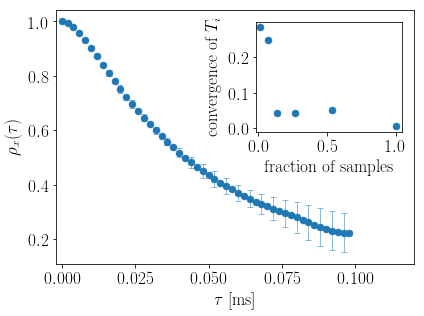

In [274]:
fig, ax = plt.subplots()

R,S,N = get_R('b3', 2.5)
tm = np.arange(len(R))/FPS
ax.errorbar(tm[:50], R[:50], yerr=err, fmt='o', lw=0.5, capsize=3,errorevery=2)

ax.set_xlim([-0.002, 0.12])
ax.set_xlabel(r'$\tau$ [ms]')
ax.set_ylabel(r'$\rho_x(\tau)$')

inset = fig.add_axes([0.6, 0.58, 0.34, 0.34])

ind[-1] = len(t)
ind = np.array(ind)
TL = get_TL('b3', 2.5, kind='x')
inset.plot(1.0*ind / ind[-1], np.abs((np.array(TL_ind) - TL)/TL), 'o' )
inset.set_ylim(bottom=-0.01)

inset.set_yticks([0,.1,.2])
inset.set_xticks([0,.5,1])
inset.set_xlim([-0.02,1.05])

inset.set_xlabel('fraction of samples')
inset.set_ylabel(r'convergence of $T_i$')

plt.tight_layout()
fig.savefig('convergence_autocorrelation.pdf')

# PDF of velocity differences:

In [45]:
ind_lst = [1,10,50]

dvx = []
dvy = []
dvz = []

for ind in ind_lst:
    dvx.append([])
    dvy.append([])
    dvz.append([])
    
    for tr in t:
        dv = tr.velocity()[ind:,:] - tr.velocity()[:-ind,:]
        for i in range(dv.shape[0]):
            dvx[-1].append(-1*dv[i,0])
            dvy[-1].append(dv[i,1])
            dvz[-1].append(dv[i,2])

3


<IPython.core.display.Javascript object>


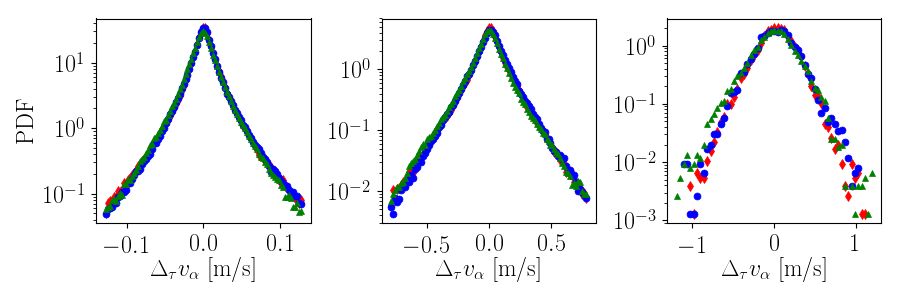

In [51]:
print len(dvx)

fig, ax = plt.subplots(1,len(ind_lst))

fig.set_size_inches(9,3)

for i in range(len(ind_lst)):
    S = np.std(dvx[i])
    
    num = 100 
    if i ==2: num=60
    
    x,y = hist_lines(dvy[i], np.linspace(-5*S,5*S,num=num))
    ax[i].plot(x,y, 'dr', ms=5)
    
    x,y = hist_lines(dvx[i], np.linspace(-5*S, 5*S,num=num))
    ax[i].plot(x, y, 'ob', ms=5)

    x,y = hist_lines(dvz[i], np.linspace(-5*S,5*S,num=num))
    ax[i].plot(x,y, '^g', ms=5)
    

    ax[i].set_yscale('log')
    ax[i].set_xlabel(r'$\Delta_\tau v_\alpha$ [m/s]')
    
ax[0].set_ylabel(r'PDF')
    
plt.tight_layout()
fig.savefig('dv_pdfs.pdf')

In [49]:
print np.array(ind_lst)/500.0
print [len(lst)**0.5 for lst in dvx]

[0.002 0.02  0.1  ]
[815.5697395072968, 566.7865559450048, 136.70040234030037]


# Integral length interpreted from the Lagrangian separation of scales

<IPython.core.display.Javascript object>


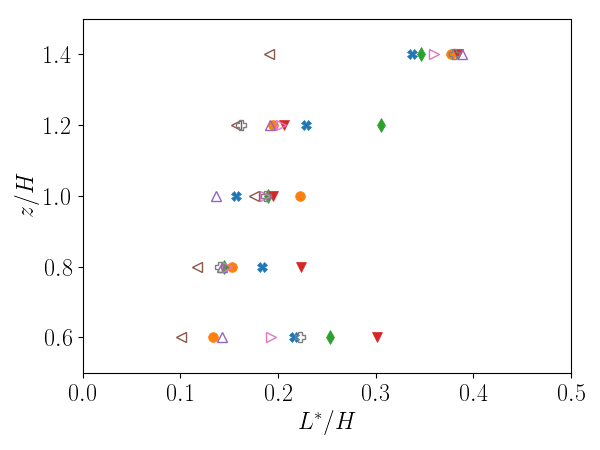

In [59]:
fig, ax = plt.subplots()
savedir = 'DL_data'
U=2.5

e = 0
z_lst = [0.6,0.8,1.0,1.2, 1.4]

H = 0.1


for ee, U in enumerate([2.5, 4.0]):
    for A in ['a','b','c','d']:
    
        lst = []
        j = 0
        for B in ['1','2','3','4','5']:
        
            subvol = A+B
        
            data = np.load( os.path.join(savedir, 'DL_%s_%d.npz'%(subvol, U*10) ) )
    
            eps = get_eps(subvol, U)
        
            urms = np.sum(get_Ustats(subvol, U)[1])**0.5 / (3**0.5)
            
            Tl = get_TL(subvol, U)
            t_eta = (nu/eps)**0.5
            
            Re_l = 12.6 * ( (Tl/t_eta)**(4.0/3.0) - 4.77 )**(3.0/4.0)
            
            #l = (15 * nu / eps)**0.5 * urms
            #Re_l = l * urms / nu
        
            eta = (nu**3 / eps)**0.25
        
            L = 15**(-3.0/4.0) * Re_l**1.5 * eta
        
            lst.append(L)
        
        if ee == 0:
            ax.plot(np.array(lst) / H, z_lst, ''+shapes[e], lw = 0.5)
        elif ee == 1:
            ax.plot(np.array(lst) / H, z_lst, ''+shapes[e], lw = 0.5, fillstyle='none', mew=1)
            
        e += 1
        
    ee+=1
    
    
ax.set_ylim(0.5,1.5)
ax.set_xlim(0,0.5)
    
z_ = np.linspace(0.48, 1.52)
low = 0.45 + 5.5*(z_/2)**6
high = 0.83+ 1.8*(z_/1.5)**5
#ax.plot(low, z_, 'k', lw=0.5)
#ax.plot(high, z_, 'k', lw=0.5)
#ax.fill_betweenx(z_, low, x2=high, alpha=0.2)

ax.set_ylabel(r'$z/H$')
ax.set_xlabel(r'$L^{*}/H$')
plt.tight_layout()

#fig.savefig('L_from_Eu_parameterization.pdf')

<IPython.core.display.Javascript object>


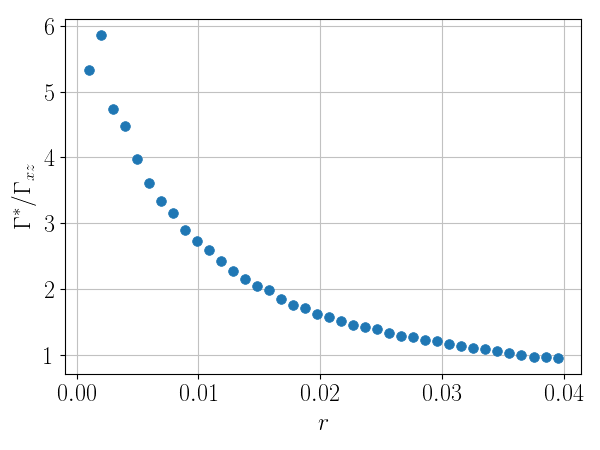

In [20]:





fg_b3 = np.load('../small_scales/Trajectories/b3_2.5fg_data.npz')


S_b3 = get_S('b3', Flow)
r = fg_b3['r']

fig, ax = plt.subplots()
ax.plot(r, fg_b3['g']**(0.5)/fg_b3['r'] / S_b3, 'o')
#ax.plot(r, np.ones(r.shape)*S_b3)
ax.set_ylabel(r'$\Gamma^* / \Gamma_{xz}$')
ax.set_xlabel(r'$r$')

plt.tight_layout()
ax.grid()



<IPython.core.display.Javascript object>


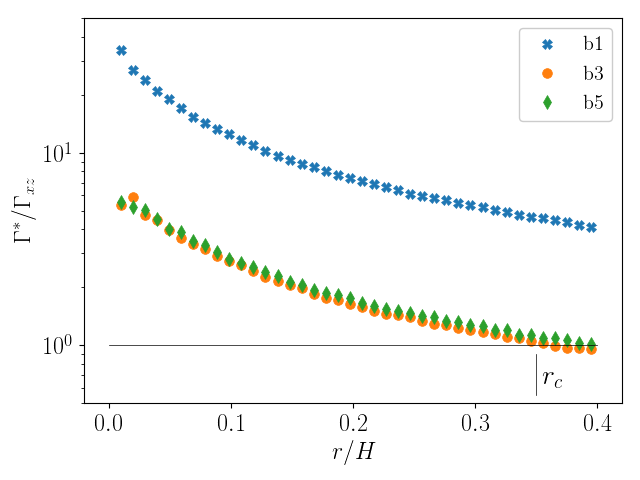

In [16]:
fig, ax = plt.subplots()
H=0.1

for e,sv in enumerate(['b1', 'b3', 'b5']):

    fg = np.load('../small_scales/Trajectories/%s_2.5fg_data.npz'%sv)


    S = get_S(sv, Flow)
    r = fg['r']


    ax.semilogy(r/H, fg['g']**(0.5)/r / S, shapes[e], label=sv)
    #ax.plot(r, np.ones(r.shape)*S_b3)
    ax.set_ylabel(r'$\Gamma^* / \Gamma_{xz}$')
    ax.set_xlabel(r'$r/H$')


ax.plot([0,0.4], [1,1], 'k-', lw=0.5)

ax.plot([.35,.35], [.55,.9], 'k-', lw=0.5)
ax.text(.355, 0.6, r'$r_c$', fontsize=20)


ax.set_ylim([0.5, 50])
ax.legend()
plt.tight_layout()

fig.savefig('local_vs_global_shear.pdf')
